In [6]:
#Notations : p prime, MesF Mestre test function, fnu inertia degree, lam = lambda

#MesF : Mestre test function. For these algorithms to be correct, MesF must be 
# Complactly supported in [-1,1], even function, positive Fourier transform

Mes(x) = (1-x)*cos(pi*x)+sin(pi*x)/pi


def liste_premier_lambda(lam):                         # Input : lam 
    C = floor(exp(lam))                                # Output : List of primes <= exp(lam)
    return prime_range(C+1)


#Only over Q
def Mestre_somme_premier_lambda(p,lam,MesF):            #Local Mestre sum          
    S,m,x = 0,1,p                                       
    while x<= exp(lam):
        S += (floor(2*sqrt(x)) * x^(-1) * MesF(m*math.log(p)/lam.numerical_approx())).numerical_approx()
        x *= x
        m += 1
    return numerical_approx(log(p)*S)


   
#Only works over Q.    
def Mestre_somme_lambda(lam,MesF):                        # Global Mestre sum 
    Liste = liste_premier_lambda(lam)
    Somme = 0
    for p in Liste:
        Somme += (Mestre_somme_premier_lambda(p,lam,MesF)).numerical_approx()
    return 2*Somme                                        #In the final formula this sum must be multiplied by two

#Only work over Q                                           
def somme_mult_badprimes_lambda(p,lam,MesF):                 # Local sum in the case of p|N i.e multiplicative reduction      
    S = p^(-1)*MesF(math.log(p)/lam.numerical_approx())
    m = 2
    x = p^2
    while x <= exp(lam):
        S= (S + x^(-1)*MesF(m*math.log(p)/lam.numerical_approx())).numerical_approx()
        x= p * x
        m = m+1
    return numerical_approx(log(p)*S)

                                                              #Additive reduciton : the sum is 0 we don't code it


#Only over Q - uses the Wil bound
#input : lambda, MesF,two lists of bad primes : one for multiplicative red and one for additive red



def Mestre_somme_withbadprimes_lambda(lam,MesF,mult_badprimes,add_badprimes): #Global sum with mult and add reductions
    Liste = liste_premier_lambda(lam)                                              
    Somme = 0
    for p in Liste:                                                  
        if p in mult_badprimes :                               #Correct sum for multiplicative red
            Somme += somme_mult_badprimes_lambda(p,lam,MesF)
        elif p in add_badprimes:
            Somme += 0                                         #Do nothing for additive reduction
        else:
            Somme += Mestre_somme_premier_lambda(p,lam,MesF)   # In case of good reduction
    return 2*Somme                                             #factor 2 in the final sum - present in Mestre explicit formula                                                           




#remark : the list we give in input are lists of primes CONTAINED in the set of primes of bad reduction.
#The algorithm stays worect if we forgot some primes of bad reduction, but the result is lee precise 
# that is to say the final bound is lwoer that it would be



#Function defining the integrals terms appearing. Not correct if MesF is not completly supported in [-1,1]


def Value_Phi_0(MesF):      #The integral term which will be multiplied by the rank. Fourier transform of MesF eval at 0
    return 2*numerical_integral(MesF(x),0,1)[0]


Constant_Mlambda = 2*math.log(2*pi)     #constant appearing in the formula, let's stock it



def Mlambda2(lam,MesF):
    aux(x) = MesF(x) * exp(-lam*x)/(1-exp(-lam*x)) - MesF(0) * exp(-lam*x)/(lam*x)
    a = numerical_integral(aux(x),0,1)[0]
    b = numerical_integral(exp(-x)/x, lam.numerical_approx() , Infinity )[0] #depends on lam, cannot be stocked :(
    return 2*(lam*a - MesF(0)*b) +   MesF(0)*Constant_Mlambda       #still a foctor two at the end, like the sum




#Final lower bound 

#Only over Q
def minorant_conducteur_lambda(lam,MesF,rk):      #Without knowing anything on the conductor
    K = lam * rk * Value_Phi_0(MesF)+Mlambda2(lam,MesF)-Mestre_somme_lambda(lam,MesF)
    return exp(K)

#Only over Q
def minorant_conducteur_lambda_withbadprimes(lam,MesF,rk,mult_badprimes,add_badprimes): #knowing some primes of add and mul reduction
    K = lam * rk *Value_Phi_0(MesF) + Mlambda2(lam,MesF)-Mestre_somme_withbadprimes_lambda(lam,MesF,mult_badprimes,add_badprimes)
    return exp(K)




In [7]:
#In number fields, without knowing anything about the bad primes, using only the Weil bound

def somme_premier_degre_ramifi(p,lam,MesF,fnu):
    q = p^fnu
    S,m,x = 0,1,q
    while x<= exp(lam):
        S += (floor(2*sqrt(x)) * x^(-1) * MesF(m*math.log(q)/lam.numerical_approx())).numerical_approx()
        x *=  q
        m +=  1
    return numerical_approx(log(q)*S)



def Mestre_somme_lambda_nbfield(lam,MesF,K):        #lam = lambda, MesF mestre test function, K number field            
    Liste = liste_premier_lambda(lam)
    Somme = 0
    for p in Liste:
        for pp in K.primes_above(p):
            fnu = pp.residue_class_degree()
            Somme += (somme_premier_degre_ramifi(p,lam,MesF,fnu)).numerical_approx()
    return 2 * Somme             # un facteur de 2 car deux termes conjugués dans la somme de Mestre



def minorant_conducteur_lambda_nbfield(lam,MesF,rk,K):     # K nb field (chose not to give polynomial in case of tower extension)  
    n = K.absolute_degree()
    disc = K.absolute_discriminant()
    lowbound = lam * rk * Value_Phi_0(MesF) + n * Mlambda2(lam,MesF) - Mestre_somme_lambda_nbfield(lam,MesF,K)
    return exp(lowbound)/(disc^2)




#With Frobenius. Here the functions are exact, no need to take abd in the formulas.

def Somme_Frob(p,fnu,lam,MesF,Frob):
    q = p^fnu 
    delt = Frob^2-4*q
    alpha = (Frob-I*sqrt(-delt))/2
    beta = (Frob+I*sqrt(-delt))/2
    a = alpha
    b = beta
    Somme = 0
    m = 1
    x = q
    while x <= exp(lam):
        Somme += (MesF(m*math.log(q)/numerical_approx(lam))*(a+b)/x).numerical_approx()   # compute the sum
        a     *= alpha                                             # powers of roots of Frob increment
        b     *= beta
        x     *= q                                                 # denominator of the sum increment
        m     += 1
    finalSomme = 2 * Somme * math.log(q)                           # factor  2 in the Mestre formula
    return numerical_approx(finalSomme)


def Mini_Somme_Frob(p,fnu,lam,MesF):       #take the minimal over all possible fors, return the frob and the sum 
    bound = floor(2*sqrt(p^fnu))
    MinFrob = - bound
    MinSomme = Somme_Frob(p,fnu,lam,MesF,MinFrob)
    for Frobenius in range(-bound+1,bound+1):
        C = Somme_Frob(p,fnu,lam,MesF,Frobenius)
        if C < MinSomme:
            MinFrob = Frobenius
            MinSomme = C
    return (MinFrob,MinSomme)


def Mestre_Somme_Frob(lam,MesF,K):
    Listeprime = liste_premier_lambda(lam)
    BigSomme = 0
    ListeFrob = []
    for p in Listeprime:
        for prims in K.primes_above(p):
            fnu = prims.residue_class_degree()
            frobenius,value = Mini_Somme_Frob(p,fnu,lam,MesF)
            BigSomme += value.numerical_approx()
            ListeFrob += [(p,fnu,frobenius)]
    return (ListeFrob,BigSomme)

def minorant_conducteur_nbfield_Frobenius(lam,MesF,rk,K):   # K nb field  
    n = K.absolute_degree()
    discri = K.absolute_discriminant()
    Listefrobs, MestreSomme = Mestre_Somme_Frob(lam,MesF,K)
    lowbound = lam * rk * Value_Phi_0(MesF) + n * Mlambda2(lam,MesF) + MestreSomme
    return Listefrobs , exp(lowbound)/(discri^2)





def Somme_liste_Frob(lam,MesF,lisfrobs):   #Input: the list of primes considered, with their fnu and attributed frobenius
    S = 0
    for k in lisfrobs:
        p,fnu,Frob = k
        S += (Somme_Frob(p,fnu,lam,MesF,Frob)).numerical_approx()
    return S

def minorant_liste_Frob(lam,MesF,rk,K,lisfrobs):
    n = K.absolute_degree()
    discri = K.absolute_discriminant()
    Mestresomme = Somme_liste_Frob(lam,MesF,lisfrobs)
    lowbound = lam * rk * Value_Phi_0(MesF) + n * Mlambda2(lam,MesF) + Mestresomme  #here we add the sum (it's a negative term)
    return  exp(lowbound)/(discri^2)
   
    
    
    
    
    
    

    
    
def somme_split_mult_badprimes_lambda(p,lam,MesF):           # Local sum in the case of p|N i.e split multiplicative reduction      
    S = - p^(-1)*MesF(math.log(p)/lam.numerical_approx())
    m = 2
    x = p^2
    while x <= exp(lam):
        S = ( S +   (  (-1)^m* x^(-1)*MesF(m*math.log(p)/lam.numerical_approx()) ).abs()  ).numerical_approx()
        x = p * x
        m = m+1
    return numerical_approx(2*log(p)*S)  #factor 2 in the m=Mestre formula  

    
    
    
def Mestre_somme_withbadprimes_listfrobs(lam,MesF,lisfrobs,mult_badprimes,add_badprimes):#Global sum with mult and add reductions
    Somme = 0
    for k in lisfrobs:
        pri,fnu,Frob = k    #fnu = 1 systemtically                                              
        if pri in mult_badprimes :                                    #Correct sum for multiplicative red
            Somme += somme_split_mult_badprimes_lambda(pri,lam,MesF)    #negative term to minimize in this case
        elif pri in add_badprimes: 
            Somme += 0                                      #Do nothing for additive reduction
        else:
            Somme += (Somme_Frob(pri,1,lam,MesF,Frob)).numerical_approx()   # In case of good reduction
    return Somme         #the factor 2 has already been put locally                                                                                                



def minorant_conducteur_withbadprimes_listfrobs(lam,MesF,rk,lisfrobs,mult_badprimes,add_badprimes): #knowing some primes of add and mul reduction
    K = lam * rk *Value_Phi_0(MesF) + Mlambda2(lam,MesF) + Mestre_somme_withbadprimes_listfrobs(lam,MesF,lisfrobs,mult_badprimes,add_badprimes)
    return exp(K)



In [8]:
#   optimisation de la fonction de Mestre dans un sous espace de dimesion 5 


def fonctiontest(a0,a1,a2,a3,a4): #output convolution square of a0 + a1cos(2pix) + a2cos(4pix) + a3cos(6pix) +a4cos(pix)sur [-1/2,1/2]
    norm=sqrt(a0^2+1/2*(a1^2+a2^2+a3^2+a4^2) +2*(2/pi*a4*(a0+a1/3-a2/15+a3/35)))
    b0,b1,b2,b3,b4=a0/norm,a1/norm,a2/norm,a3/norm,a4/norm
    aux(x)=b0^2*g00(x)+b1^2*g11(x)+b2^2*g22(x)+b3^2*g33(x)+b4^2/2*Mes(x)+2*(b0*b1*g01(x)+b0*b2*g02(x)+b0*b3*g03(x)+b1*b2*g12(x)+b1*b3*g13(x)+b2*b3*g23(x)+b0*b4*gm0(x)+b1*b4*gm1(x)+b2*b4*gm2(x)+b3*b4*gm3(x))
    return aux

g00(x)= -x + 1
g01(x)= 1/2*sin(2*pi*x)/pi
g02(x)= -1/4*sin(4*pi*x)/pi
g03(x)= 1/6*sin(6*pi*x)/pi

g11(x)= 1/8*(2*pi*cos(2*pi*x) - sin(2*pi*x))/pi + 1/8*(2*(pi - 2*pi*x)*cos(2*pi*x) - sin(2*pi*x))/pi 
g12(x)= 1/3*sin(4*pi*x)/pi - 1/6*sin(2*pi*x)/pi
g13(x)= -3/16*sin(6*pi*x)/pi + 1/16*sin(2*pi*x)/pi

g22(x)= 1/16*(4*pi*cos(4*pi*x) - sin(4*pi*x))/pi + 1/16*(4*(pi - 2*pi*x)*cos(4*pi*x) - sin(4*pi*x))/pi
g23(x)= 3/10*sin(6*pi*x)/pi - 1/5*sin(4*pi*x)/pi

g33(x)= 1/24*(6*pi*cos(6*pi*x) - sin(6*pi*x))/pi + 1/24*(6*(pi - 2*pi*x)*cos(6*pi*x) - sin(6*pi*x))/pi

gm0(x) = cos(pi*x)/pi + 1/pi
gm1(x) = (1/6)*(sin(3/2*pi + 2*pi*x) + 3*sin(1/2*pi + 2*pi*x))/pi + 1/3*cos(pi*x)/pi
gm2(x) = (1/30)*(3*sin(5/2*pi + 4*pi*x) + 5*sin(3/2*pi + 4*pi*x))/pi - (1/15)*cos(pi*x)/pi
gm3(x) = (1/70)*(5*sin(7/2*pi + 6*pi*x) + 7*sin(5/2*pi + 6*pi*x))/pi + (1/35)*cos(pi*x)/pi

a00=1.27323954473516/2
a11=0.424413181578388
a22=-0.0848826363156775
a33=0.0363782727067189
b00=a00/sqrt(a00^2+1/2*(a11^2+a22^2+a33^2))
b11=a11/sqrt(a00^2+1/2*(a11^2+a22^2+a33^2))
b22=a22/sqrt(a00^2+1/2*(a11^2+a22^2+a33^2))
b33=a33/sqrt(a00^2+1/2*(a11^2+a22^2+a33^2))

def optimisitionfonction(lam,rk,K,lisfrobs,a0,a1,a2,a3,m0,pas,nb_iteration): #important condition : a0²+1/2(a1²+a2²+a3²+m0² 
    discri = K.absolute_discriminant()  #Notice I need to know the frobeniuses         + 2/pi(a0b0+a1b0/3 -a2b0/15 +a3b0/35)
    C00 = math.log(discri^2*minorant_liste_Frob(lam,g00,rk,K,lisfrobs))     #coefficient de ma fonction en a0,a1,a2,a3
    C01 = math.log(discri^2*minorant_liste_Frob(lam,g01,rk,K,lisfrobs)) 
    C02 = math.log(discri^2*minorant_liste_Frob(lam,g02,rk,K,lisfrobs)) 
    C03 = math.log(discri^2*minorant_liste_Frob(lam,g03,rk,K,lisfrobs)) 
    C11 = math.log(discri^2*minorant_liste_Frob(lam,g11,rk,K,lisfrobs)) 
    C12 = math.log(discri^2*minorant_liste_Frob(lam,g12,rk,K,lisfrobs)) 
    C13 = math.log(discri^2*minorant_liste_Frob(lam,g13,rk,K,lisfrobs)) 
    C22 = math.log(discri^2*minorant_liste_Frob(lam,g22,rk,K,lisfrobs)) 
    C23 = math.log(discri^2*minorant_liste_Frob(lam,g23,rk,K,lisfrobs)) 
    C33 = math.log(discri^2*minorant_liste_Frob(lam,g33,rk,K,lisfrobs))
    GM0 = math.log(discri^2*minorant_liste_Frob(lam,gm0,rk,K,lisfrobs))
    GM1 = math.log(discri^2*minorant_liste_Frob(lam,gm1,rk,K,lisfrobs))
    GM2 = math.log(discri^2*minorant_liste_Frob(lam,gm2,rk,K,lisfrobs))
    GM3 = math.log(discri^2*minorant_liste_Frob(lam,gm3,rk,K,lisfrobs))
    GG  = math.log(discri^2*minorant_liste_Frob(lam,Mes,rk,K,lisfrobs))
    b0 = a0#   optimisation de la fonction de Mestre dans un sous espace de dimesion 5 


def fonctiontest(a0,a1,a2,a3,a4): #output convolution square of a0 + a1cos(2pix) + a2cos(4pix) + a3cos(6pix) +a4cos(pix)sur [-1/2,1/2]
    norm=sqrt(a0^2+1/2*(a1^2+a2^2+a3^2+a4^2) +2*(2/pi*a4*(a0+a1/3-a2/15+a3/35)))
    b0,b1,b2,b3,b4=a0/norm,a1/norm,a2/norm,a3/norm,a4/norm
    aux(x)=b0^2*g00(x)+b1^2*g11(x)+b2^2*g22(x)+b3^2*g33(x)+b4^2/2*Mes(x)+2*(b0*b1*g01(x)+b0*b2*g02(x)+b0*b3*g03(x)+b1*b2*g12(x)+b1*b3*g13(x)+b2*b3*g23(x)+b0*b4*gm0(x)+b1*b4*gm1(x)+b2*b4*gm2(x)+b3*b4*gm3(x))
    return aux

g00(x)= -x + 1
g01(x)= 1/2*sin(2*pi*x)/pi
g02(x)= -1/4*sin(4*pi*x)/pi
g03(x)= 1/6*sin(6*pi*x)/pi

g11(x)= 1/8*(2*pi*cos(2*pi*x) - sin(2*pi*x))/pi + 1/8*(2*(pi - 2*pi*x)*cos(2*pi*x) - sin(2*pi*x))/pi 
g12(x)= 1/3*sin(4*pi*x)/pi - 1/6*sin(2*pi*x)/pi
g13(x)= -3/16*sin(6*pi*x)/pi + 1/16*sin(2*pi*x)/pi

g22(x)= 1/16*(4*pi*cos(4*pi*x) - sin(4*pi*x))/pi + 1/16*(4*(pi - 2*pi*x)*cos(4*pi*x) - sin(4*pi*x))/pi
g23(x)= 3/10*sin(6*pi*x)/pi - 1/5*sin(4*pi*x)/pi

g33(x)= 1/24*(6*pi*cos(6*pi*x) - sin(6*pi*x))/pi + 1/24*(6*(pi - 2*pi*x)*cos(6*pi*x) - sin(6*pi*x))/pi

gm0(x) = cos(pi*x)/pi + 1/pi
gm1(x) = (1/6)*(sin(3/2*pi + 2*pi*x) + 3*sin(1/2*pi + 2*pi*x))/pi + 1/3*cos(pi*x)/pi
gm2(x) = (1/30)*(3*sin(5/2*pi + 4*pi*x) + 5*sin(3/2*pi + 4*pi*x))/pi - (1/15)*cos(pi*x)/pi
gm3(x) = (1/70)*(5*sin(7/2*pi + 6*pi*x) + 7*sin(5/2*pi + 6*pi*x))/pi + (1/35)*cos(pi*x)/pi

a00=1.27323954473516/2
a11=0.424413181578388
a22=-0.0848826363156775
a33=0.0363782727067189
b00=a00/sqrt(a00^2+1/2*(a11^2+a22^2+a33^2))
b11=a11/sqrt(a00^2+1/2*(a11^2+a22^2+a33^2))
b22=a22/sqrt(a00^2+1/2*(a11^2+a22^2+a33^2))
b33=a33/sqrt(a00^2+1/2*(a11^2+a22^2+a33^2))

def optimisitionfonction(lam,rk,K,lisfrobs,a0,a1,a2,a3,m0,pas,nb_iteration): #important condition : a0²+1/2(a1²+a2²+a3²+m0² 
    discri = K.absolute_discriminant()  #Notice I need to know the frobeniuses         + 2/pi(a0b0+a1b0/3 -a2b0/15 +a3b0/35)
    C00 = math.log(discri^2*minorant_liste_Frob(lam,g00,rk,K,lisfrobs))     #coefficient de ma fonction en a0,a1,a2,a3
    C01 = math.log(discri^2*minorant_liste_Frob(lam,g01,rk,K,lisfrobs)) 
    C02 = math.log(discri^2*minorant_liste_Frob(lam,g02,rk,K,lisfrobs)) 
    C03 = math.log(discri^2*minorant_liste_Frob(lam,g03,rk,K,lisfrobs)) 
    C11 = math.log(discri^2*minorant_liste_Frob(lam,g11,rk,K,lisfrobs)) 
    C12 = math.log(discri^2*minorant_liste_Frob(lam,g12,rk,K,lisfrobs)) 
    C13 = math.log(discri^2*minorant_liste_Frob(lam,g13,rk,K,lisfrobs)) 
    C22 = math.log(discri^2*minorant_liste_Frob(lam,g22,rk,K,lisfrobs)) 
    C23 = math.log(discri^2*minorant_liste_Frob(lam,g23,rk,K,lisfrobs)) 
    C33 = math.log(discri^2*minorant_liste_Frob(lam,g33,rk,K,lisfrobs))
    GM0 = math.log(discri^2*minorant_liste_Frob(lam,gm0,rk,K,lisfrobs))
    GM1 = math.log(discri^2*minorant_liste_Frob(lam,gm1,rk,K,lisfrobs))
    GM2 = math.log(discri^2*minorant_liste_Frob(lam,gm2,rk,K,lisfrobs))
    GM3 = math.log(discri^2*minorant_liste_Frob(lam,gm3,rk,K,lisfrobs))
    GG  = math.log(discri^2*minorant_liste_Frob(lam,Mes,rk,K,lisfrobs))
    b0 = a0
    b1 = a1
    b2 = a2
    b3 = a3
    b4 = m0
    for i in range(nb_iteration):
        tempvalue = (b0^2*C00+b1^2*C11+b2^2*C22+b3^2*C33+b4^2/2*GG+2*(b0*b1*C01+b0*b2*C02+b0*b3*C03+b1*b2*C12+b1*b3*C13+b2*b3*C23+b0*b4*GM0 +b1*b4*GM1 +b2*b4*GM2 +b3*b4*GM3)).numerical_approx() 
        gradient0 = ((2*b0*C00+2*b1*C01+2*b2*C02+2*b3*C03+2*b4*GM0) -tempvalue*(2*b0 + 2/pi*b4)).numerical_approx()    #gradient of the function
        gradient1 = ((2*b0*C01+2*b1*C11+2*b2*C12+2*b3*C13+2*b4*GM1)  -tempvalue*(b1  + 2/(3*pi)*b4)).numerical_approx()      
        gradient2 = ((2*b0*C02+2*b1*C12+2*b2*C22+2*b3*C23+2*b4*GM2)  -tempvalue*(b2  - 2/(15*pi)*b4)).numerical_approx()     
        gradient3 = ((2*b0*C03+2*b1*C13+2*b2*C23+2*b3*C33+2*b4*GM3)  -tempvalue*(b3  + 2/(35*pi)*b4)).numerical_approx() 
        gradient4 = ((2*b4*GG+2*b0*GM0+2*b1*GM1+2*b2*GM2+2*b3*GM3)  -tempvalue*(2*b4 + 2/pi*b0 + 2/(3*pi)*b1 - 2/(15*pi)*b2 +2/(35*pi)*b3)).numerical_approx() 
        normgrad = sqrt(gradient0^2+gradient1^2+gradient2^2+gradient3^2+gradient4^2)
        c0=(b0+gradient0*pas/normgrad).numerical_approx()                               # We move the original coordinates in the direction of the gradient 
        c1=(b1+gradient1*pas/normgrad).numerical_approx()                                             
        c2=(b2+gradient2*pas/normgrad).numerical_approx() 
        c3=(b3+gradient3*pas/normgrad).numerical_approx() 
        c4=(b4+gradient4*pas/normgrad).numerical_approx() 
        norm=sqrt(c0^2+1/2*(c1^2+c2^2+c3^2+c4^2) +2*(2/pi*c4*(c0+c1/3-c2/15+c3/35))) #final renormalisation to have F(0)=1                                      
        b0=(c0/norm).numerical_approx()
        b1=(c1/norm).numerical_approx()
        b2=(c2/norm).numerical_approx()
        b3=(c3/norm).numerical_approx()
        b4=(c4/norm).numerical_approx()
    finavalue=b0^2*C00+b1^2*C11+b2^2*C22+b3^2*C33+b4^2/2*GG+2*(b0*b1*C01 + b0*b2*C02 + b0*b3*C03 + b1*b2*C12 + b1*b3*C13 + b2*b3*C23 + b0*b4*GM0 + b1*b4*GM1 + b2*b4*GM2 + b3*b4*GM3 )
    return (b0,b1,b2,b3,b4,(1/discri^2)*exp(finavalue))


# To find the best lambda with 0.01 precision:
def optimi_lam1(MesF,rk,K):
    earlylam = 1
    earlyval = minorant_conducteur_lambda_nbfield(earlylam,MesF,rk,K) 
    while minorant_conducteur_lambda_nbfield(earlylam + 1,MesF,rk,K) > earlyval:
        earlyval = minorant_conducteur_lambda_nbfield(earlylam + 1,MesF,rk,K)
        earlylam = earlylam + 1
    midlam = earlylam-0.9
    midval = minorant_conducteur_lambda_nbfield(midlam,MesF,rk,K)
    while minorant_conducteur_lambda_nbfield(midlam + 0.1,MesF,rk,K) > midval:
        midval = minorant_conducteur_lambda_nbfield(midlam + 0.1,MesF,rk,K)
        midlam = midlam + 0.1
    finlam = midlam-0.09
    finval = minorant_conducteur_lambda_nbfield(finlam,MesF,rk,K)
    while minorant_conducteur_lambda_nbfield(finlam+0.01,MesF,rk,K) > finval:
        finval = minorant_conducteur_lambda_nbfield(finlam+0.01,MesF,rk,K)
        finlam += 0.01
    return (finlam)

def optimi_lam(MesF,rk,K):
    midlam = 1
    midval = minorant_conducteur_nbfield_Frobenius(midlam,MesF,rk,K)[1] 
    while minorant_conducteur_nbfield_Frobenius(midlam + 0.1,MesF,rk,K)[1] > midval:
        midval = minorant_conducteur_nbfield_Frobenius(midlam + 0.1,MesF,rk,K)[1]
        midlam = midlam + 0.1
    finlam = midlam-0.09
    finval = minorant_conducteur_nbfield_Frobenius(finlam,MesF,rk,K)[1]
    while minorant_conducteur_nbfield_Frobenius(finlam+0.01,MesF,rk,K)[1] > finval:
        finval = minorant_conducteur_nbfield_Frobenius(finlam+0.01,MesF,rk,K)[1]
        finlam += 0.01
    return (finlam)
        
    b1 = a1
    b2 = a2
    b3 = a3
    b4 = m0
    for i in range(nb_iteration):
        tempvalue = (b0^2*C00+b1^2*C11+b2^2*C22+b3^2*C33+b4^2/2*GG+2*(b0*b1*C01+b0*b2*C02+b0*b3*C03+b1*b2*C12+b1*b3*C13+b2*b3*C23+b0*b4*GM0 +b1*b4*GM1 +b2*b4*GM2 +b3*b4*GM3)).numerical_approx() 
        gradient0 = ((2*b0*C00+2*b1*C01+2*b2*C02+2*b3*C03+2*b4*GM0) -tempvalue*(2*b0 + 2/pi*b4)).numerical_approx()    #gradient of the function
        gradient1 = ((2*b0*C01+2*b1*C11+2*b2*C12+2*b3*C13+2*b4*GM1)  -tempvalue*(b1  + 2/(3*pi)*b4)).numerical_approx()      
        gradient2 = ((2*b0*C02+2*b1*C12+2*b2*C22+2*b3*C23+2*b4*GM2)  -tempvalue*(b2  - 2/(15*pi)*b4)).numerical_approx()     
        gradient3 = ((2*b0*C03+2*b1*C13+2*b2*C23+2*b3*C33+2*b4*GM3)  -tempvalue*(b3  + 2/(35*pi)*b4)).numerical_approx() 
        gradient4 = ((2*b4*GG+2*b0*GM0+2*b1*GM1+2*b2*GM2+2*b3*GM3)  -tempvalue*(2*b4 + 2/pi*b0 + 2/(3*pi)*b1 - 2/(15*pi)*b2 +2/(35*pi)*b3)).numerical_approx() 
        normgrad = sqrt(gradient0^2+gradient1^2+gradient2^2+gradient3^2+gradient4^2)
        c0=(b0+gradient0*pas/normgrad).numerical_approx()                               # We move the original coordinates in the direction of the gradient 
        c1=(b1+gradient1*pas/normgrad).numerical_approx()                                             
        c2=(b2+gradient2*pas/normgrad).numerical_approx() 
        c3=(b3+gradient3*pas/normgrad).numerical_approx() 
        c4=(b4+gradient4*pas/normgrad).numerical_approx() 
        norm=sqrt(c0^2+1/2*(c1^2+c2^2+c3^2+c4^2) +2*(2/pi*c4*(c0+c1/3-c2/15+c3/35))) #final renormalisation to have F(0)=1                                      
        b0=(c0/norm).numerical_approx()
        b1=(c1/norm).numerical_approx()
        b2=(c2/norm).numerical_approx()
        b3=(c3/norm).numerical_approx()
        b4=(c4/norm).numerical_approx()
    finavalue=b0^2*C00+b1^2*C11+b2^2*C22+b3^2*C33+b4^2/2*GG+2*(b0*b1*C01 + b0*b2*C02 + b0*b3*C03 + b1*b2*C12 + b1*b3*C13 + b2*b3*C23 + b0*b4*GM0 + b1*b4*GM1 + b2*b4*GM2 + b3*b4*GM3 )
    return (b0,b1,b2,b3,b4,(1/discri^2)*exp(finavalue))


# To find the best lambda with 0.01 precision:
def optimi_lam1(MesF,rk,K):
    earlylam = 1
    earlyval = minorant_conducteur_lambda_nbfield(earlylam,MesF,rk,K) 
    while minorant_conducteur_lambda_nbfield(earlylam + 1,MesF,rk,K) > earlyval:
        earlyval = minorant_conducteur_lambda_nbfield(earlylam + 1,MesF,rk,K)
        earlylam = earlylam + 1
    midlam = earlylam-0.9
    midval = minorant_conducteur_lambda_nbfield(midlam,MesF,rk,K)
    while minorant_conducteur_lambda_nbfield(midlam + 0.1,MesF,rk,K) > midval:
        midval = minorant_conducteur_lambda_nbfield(midlam + 0.1,MesF,rk,K)
        midlam = midlam + 0.1
    finlam = midlam-0.09
    finval = minorant_conducteur_lambda_nbfield(finlam,MesF,rk,K)
    while minorant_conducteur_lambda_nbfield(finlam+0.01,MesF,rk,K) > finval:
        finval = minorant_conducteur_lambda_nbfield(finlam+0.01,MesF,rk,K)
        finlam += 0.01
    return (finlam)

def optimi_lam(MesF,rk,K):
    midlam = 1
    midval = minorant_conducteur_nbfield_Frobenius(midlam,MesF,rk,K)[1] 
    while minorant_conducteur_nbfield_Frobenius(midlam + 0.1,MesF,rk,K)[1] > midval:
        midval = minorant_conducteur_nbfield_Frobenius(midlam + 0.1,MesF,rk,K)[1]
        midlam = midlam + 0.1
    finlam = midlam-0.09
    finval = minorant_conducteur_nbfield_Frobenius(finlam,MesF,rk,K)[1]
    while minorant_conducteur_nbfield_Frobenius(finlam+0.01,MesF,rk,K)[1] > finval:
        finval = minorant_conducteur_nbfield_Frobenius(finlam+0.01,MesF,rk,K)[1]
        finlam += 0.01
    return (finlam)
        

In [9]:
# Degree 4, root discriminant <= 8

# Number fields downloaded from the LMFDB on 08 January 2024.
# Search link: https://www.lmfdb.org/NumberField/?degree=4&rd=1-8&showcol=rd
# Query "{'degree': 4, 'rd': {'$gte': 0.99999999995, '$lte': 8.00000000005}}" returned 354 fields, sorted by degree.

# Each entry in the following data list has the form:
#    [Label, Polynomial, Discriminant, Root discriminant, Galois group, Class group]
# For more details, see the definitions at the bottom of the file.

# To create a list of fields, type "fields = make_data()"


columns = ["label", "coeffs", "disc", "rd", "galois_label", "class_group"]
data4 = [
["4.0.117.1", [1, 1, -1, -1, 1], 117, "4T3", []],
["4.0.125.1", [1, -1, 1, -1, 1], 125, "4T1", []],
["4.0.144.1", [1, 0, -1, 0, 1], 144, "4T2", []],
["4.0.189.1", [1, 2, 0, -1, 1], 189, "4T3", []],
["4.0.225.1", [1, 1, 2, -1, 1], 225, "4T2", []],
["4.0.229.1", [1, -1, 0, 0, 1], 229, "4T5", []],
["4.0.256.1", [1, 0, 0, 0, 1], 256, "4T2", []],
["4.0.257.1", [1, -1, 1, 0, 1], 257, "4T5", []],
["4.0.272.1", [1, -2, 1, 0, 1], 272, "4T3", []],
["4.2.275.1", [-1, 2, 0, -1, 1], -275, "4T3", []],
["4.2.283.1", [-1, -1, 0, 0, 1], -283, "4T5", []],
["4.0.320.1", [2, 0, 0, -2, 1], 320, "4T3", []],
["4.2.331.1", [-1, 1, 1, -1, 1], -331, "4T5", []],
["4.0.333.1", [3, 0, -2, -1, 1], 333, "4T3", []],
["4.0.392.1", [1, 1, 0, -1, 1], 392, "4T3", []],
["4.2.400.1", [-1, 0, -1, 0, 1], -400, "4T3", []],
["4.0.400.1", [1, 0, 3, 0, 1], 400, "4T2", []],
["4.0.432.1", [3, 0, -3, 0, 1], 432, "4T3", []],
["4.0.441.1", [4, -2, -1, -1, 1], 441, "4T2", []],
["4.2.448.1", [1, -2, 1, -2, 1], -448, "4T3", []],
["4.2.475.1", [-1, -1, 2, -2, 1], -475, "4T3", []],
["4.2.491.1", [-1, 3, -1, -1, 1], -491, "4T5", []],
["4.2.507.1", [1, -1, -1, -1, 1], -507, "4T3", []],
["4.0.512.1", [2, 0, -2, 0, 1], 512, "4T3", []],
["4.0.513.1", [4, 2, -3, -1, 1], 513, "4T3", []],
["4.0.549.1", [3, 3, -2, -2, 1], 549, "4T3", []],
["4.2.563.1", [-1, -1, 1, -1, 1], -563, "4T5", []],
["4.0.576.1", [4, 0, -2, 0, 1], 576, "4T2", []],
["4.0.576.2", [4, 0, 2, 0, 1], 576, "4T2", []],
["4.0.592.1", [1, -2, 2, 0, 1], 592, "4T5", []],
["4.0.605.1", [1, 1, 1, -1, 1], 605, "4T3", []],
["4.2.643.1", [1, -2, 0, -1, 1], -643, "4T5", []],
["4.0.656.1", [2, 2, -1, -2, 1], 656, "4T3", []],
["4.0.657.1", [4, -2, 5, -1, 1], 657, "4T3", []],
["4.2.688.1", [-1, -2, 0, 0, 1], -688, "4T5", []],
["4.0.697.1", [2, -1, 2, -1, 1], 697, "4T5", []],
["4.4.725.1", [1, 1, -3, -1, 1], 725, "4T3", []],
["4.2.731.1", [-1, 0, 2, -1, 1], -731, "4T5", []],
["4.2.751.1", [-1, -1, 1, -2, 1], -751, "4T5", []],
["4.0.761.1", [1, 2, 1, -1, 1], 761, "4T5", []],
["4.2.775.1", [-1, -3, 0, -1, 1], -775, "4T3", []],
["4.0.784.1", [4, 0, -3, 0, 1], 784, "4T2", []],
["4.0.788.1", [2, -2, 2, -1, 1], 788, "4T5", []],
["4.0.832.1", [5, -2, 0, -2, 1], 832, "4T3", []],
["4.0.837.1", [7, -1, -3, -1, 1], 837, "4T3", []],
["4.2.848.1", [1, -2, -1, 0, 1], -848, "4T5", []],
["4.0.873.1", [7, 1, -4, -1, 1], 873, "4T3", []],
["4.0.892.1", [2, 0, -1, -1, 1], 892, "4T5", []],
["4.2.976.1", [-1, 0, 3, -2, 1], -976, "4T5", []],
["4.0.981.1", [7, 4, -4, -1, 1], 981, "4T3", []],
["4.0.985.1", [2, -3, 2, -1, 1], 985, "4T5", []],
["4.0.1008.1", [7, 0, -5, 0, 1], 1008, "4T3", []],
["4.0.1008.2", [7, 0, 5, 0, 1], 1008, "4T3", []],
["4.0.1016.1", [2, -2, 1, -1, 1], 1016, "4T5", []],
["4.2.1024.1", [-1, 0, -2, 0, 1], -1024, "4T3", []],
["4.0.1025.1", [4, -2, 3, -1, 1], 1025, "4T3", []],
["4.0.1040.1", [5, -2, -3, 0, 1], 1040, "4T3", []],
["4.0.1040.2", [4, -4, 1, 0, 1], 1040, "4T3", []],
["4.0.1076.1", [2, -3, 3, -1, 1], 1076, "4T5", []],
["4.0.1088.1", [3, -2, 1, -2, 1], 1088, "4T3", []],
["4.0.1088.2", [2, -4, 5, -2, 1], 1088, "4T3", []],
["4.0.1089.1", [9, -3, -2, -1, 1], 1089, "4T2", []],
["4.2.1099.1", [1, -3, 1, -1, 1], -1099, "4T5", []],
["4.2.1107.1", [-1, -2, 0, -1, 1], -1107, "4T5", []],
["4.4.1125.1", [1, 4, -4, -1, 1], 1125, "4T1", []],
["4.0.1129.1", [2, -1, 0, -1, 1], 1129, "4T5", []],
["4.2.1156.1", [1, -1, -2, -1, 1], -1156, "4T3", []],
["4.0.1161.1", [7, -1, 6, -1, 1], 1161, "4T3", []],
["4.0.1168.1", [5, -4, -1, 0, 1], 1168, "4T3", []],
["4.2.1192.1", [-1, 1, 2, -1, 1], -1192, "4T5", []],
["4.0.1197.1", [7, 5, -4, -2, 1], 1197, "4T3", []],
["4.0.1197.2", [9, 3, -5, -1, 1], 1197, "4T3", []],
["4.0.1225.1", [4, 2, 5, -1, 1], 1225, "4T2", []],
["4.0.1229.1", [3, -1, 3, -1, 1], 1229, "4T5", []],
["4.2.1255.1", [-1, -3, -1, 0, 1], -1255, "4T5", []],
["4.0.1257.1", [2, -1, -1, 0, 1], 1257, "4T5", []],
["4.0.1264.1", [1, -2, 3, 0, 1], 1264, "4T5", []],
["4.0.1280.1", [5, 0, -4, 0, 1], 1280, "4T3", []],
["4.2.1323.1", [1, -1, -3, -1, 1], -1323, "4T3", []],
["4.2.1328.1", [1, -2, -3, 0, 1], -1328, "4T5", []],
["4.2.1371.1", [-1, -1, 2, 0, 1], -1371, "4T5", []],
["4.0.1372.1", [2, -4, 3, -1, 1], 1372, "4T3", []],
["4.2.1375.1", [-4, 4, 1, -1, 1], -1375, "4T3", []],
["4.0.1384.1", [2, 2, -1, -1, 1], 1384, "4T5", []],
["4.0.1396.1", [2, -1, 1, -1, 1], 1396, "4T5", []],
["4.2.1399.1", [-2, 1, 0, -1, 1], -1399, "4T5", []],
["4.0.1413.1", [9, -3, 7, -1, 1], 1413, "4T3", []],
["4.0.1421.1", [2, -1, 2, -2, 1], 1421, "4T3", []],
["4.2.1423.1", [-1, -2, 1, -1, 1], -1423, "4T5", []],
["4.2.1424.1", [-1, -2, 1, 0, 1], -1424, "4T5", []],
["4.0.1424.1", [5, 2, -1, -2, 1], 1424, "4T3", []],
["4.0.1436.1", [2, 0, 3, -1, 1], 1436, "4T5", []],
["4.2.1456.1", [1, -2, -2, 0, 1], -1456, "4T5", []],
["4.2.1472.1", [-2, 0, 2, -2, 1], -1472, "4T5", []],
["4.2.1472.2", [-1, -2, 3, -2, 1], -1472, "4T3", []],
["4.2.1475.1", [-5, 5, -1, -1, 1], -1475, "4T3", []],
["4.0.1489.1", [2, -1, 4, -1, 1], 1489, "4T5", []],
["4.0.1492.1", [2, 0, 2, -1, 1], 1492, "4T5", []],
["4.0.1509.1", [1, 2, 2, -1, 1], 1509, "4T5", []],
["4.0.1521.1", [9, 3, 4, -1, 1], 1521, "4T2", [2]],
["4.0.1525.1", [5, -5, 6, -2, 1], 1525, "4T3", []],
["4.0.1552.1", [5, 4, -3, -2, 1], 1552, "4T3", []],
["4.0.1556.1", [2, 1, -1, -1, 1], 1556, "4T5", []],
["4.0.1568.1", [2, 0, -1, 0, 1], 1568, "4T3", []],
["4.2.1588.1", [2, 0, -3, -1, 1], -1588, "4T5", []],
["4.0.1593.1", [2, -1, 3, -2, 1], 1593, "4T5", []],
["4.2.1600.1", [-4, 0, -2, 0, 1], -1600, "4T3", []],
["4.0.1600.1", [4, 0, 6, 0, 1], 1600, "4T2", []],
["4.4.1600.1", [4, 0, -6, 0, 1], 1600, "4T2", []],
["4.0.1616.1", [2, -2, 0, 0, 1], 1616, "4T5", []],
["4.0.1629.1", [13, -7, 8, -2, 1], 1629, "4T3", []],
["4.2.1728.1", [1, -2, 0, -2, 1], -1728, "4T3", []],
["4.0.1728.1", [12, 0, -6, 0, 1], 1728, "4T3", []],
["4.2.1732.1", [-1, 3, 0, -1, 1], -1732, "4T5", []],
["4.0.1737.1", [12, 6, -5, -1, 1], 1737, "4T3", []],
["4.0.1765.1", [3, -1, -1, -1, 1], 1765, "4T5", []],
["4.2.1775.1", [-4, -2, 3, -2, 1], -1775, "4T3", []],
["4.2.1791.1", [1, -2, -1, -1, 1], -1791, "4T5", []],
["4.2.1792.1", [-2, -4, -2, 0, 1], -1792, "4T3", []],
["4.0.1805.1", [1, 1, 3, -1, 1], 1805, "4T3", []],
["4.0.1808.1", [8, -4, -3, 0, 1], 1808, "4T3", []],
["4.0.1809.1", [13, 5, -6, -1, 1], 1809, "4T3", []],
["4.0.1813.1", [2, 1, 0, -2, 1], 1813, "4T3", []],
["4.2.1823.1", [-2, 3, 0, -1, 1], -1823, "4T5", []],
["4.0.1825.1", [2, -1, 1, 0, 1], 1825, "4T5", []],
["4.2.1856.1", [-1, -2, 1, -2, 1], -1856, "4T5", []],
["4.0.1856.1", [10, -4, 0, -2, 1], 1856, "4T3", []],
["4.0.1872.1", [13, 0, 7, 0, 1], 1872, "4T3", [2]],
["4.2.1879.1", [1, -3, -2, -1, 1], -1879, "4T5", []],
["4.2.1927.1", [1, -3, 1, -2, 1], -1927, "4T5", []],
["4.0.1929.1", [2, -3, 4, -1, 1], 1929, "4T5", []],
["4.2.1931.1", [1, -3, 0, 0, 1], -1931, "4T5", []],
["4.0.1936.1", [9, 0, -5, 0, 1], 1936, "4T2", []],
["4.0.1937.1", [2, -3, 1, 0, 1], 1937, "4T5", []],
["4.0.1940.1", [2, 0, 0, -1, 1], 1940, "4T5", []],
["4.0.1953.1", [12, 6, -5, -2, 1], 1953, "4T3", []],
["4.0.1953.2", [13, -5, 8, -1, 1], 1953, "4T3", []],
["4.4.1957.1", [1, -1, -4, 0, 1], 1957, "4T5", []],
["4.2.1963.1", [-1, -2, 2, -1, 1], -1963, "4T5", []],
["4.2.1968.1", [2, -2, -4, 0, 1], -1968, "4T5", []],
["4.2.1975.1", [-5, 0, 1, -2, 1], -1975, "4T3", []],
["4.2.1984.1", [-2, 0, 1, -2, 1], -1984, "4T3", []],
["4.2.1984.2", [-1, 2, 2, -2, 1], -1984, "4T5", []],
["4.2.2000.1", [-5, 0, 0, 0, 1], -2000, "4T3", []],
["4.4.2000.1", [5, 0, -5, 0, 1], 2000, "4T1", []],
["4.0.2021.1", [2, -1, 0, 0, 1], 2021, "4T5", []],
["4.2.2048.1", [-2, 0, 0, 0, 1], -2048, "4T3", []],
["4.4.2048.1", [2, 0, -4, 0, 1], 2048, "4T1", []],
["4.0.2048.1", [2, 0, 0, 0, 1], 2048, "4T3", []],
["4.0.2048.2", [2, 0, 4, 0, 1], 2048, "4T1", []],
["4.2.2051.1", [1, 3, -1, -1, 1], -2051, "4T5", []],
["4.0.2057.1", [2, 3, 0, -1, 1], 2057, "4T5", []],
["4.0.2061.1", [13, -2, 8, -1, 1], 2061, "4T3", []],
["4.2.2068.1", [1, 3, -2, -1, 1], -2068, "4T5", []],
["4.0.2089.1", [3, 1, 0, -1, 1], 2089, "4T5", []],
["4.2.2092.1", [-2, -3, 1, -1, 1], -2092, "4T5", []],
["4.2.2096.1", [2, -2, -2, 0, 1], -2096, "4T5", []],
["4.0.2112.1", [2, 0, 1, -2, 1], 2112, "4T3", []],
["4.0.2112.2", [1, -2, 5, -2, 1], 2112, "4T3", []],
["4.2.2116.1", [-2, 0, 1, -1, 1], -2116, "4T5", []],
["4.0.2133.1", [13, 7, -6, -2, 1], 2133, "4T3", []],
["4.2.2151.1", [-2, -3, -1, 0, 1], -2151, "4T5", []],
["4.0.2156.1", [2, 4, 1, -1, 1], 2156, "4T3", []],
["4.0.2156.2", [4, 2, -2, -1, 1], 2156, "4T3", []],
["4.0.2169.1", [16, 4, -7, -1, 1], 2169, "4T3", []],
["4.2.2183.1", [-1, 1, 3, -2, 1], -2183, "4T5", []],
["4.2.2191.1", [-1, 0, 3, -1, 1], -2191, "4T5", []],
["4.0.2192.1", [10, -6, 7, -2, 1], 2192, "4T3", []],
["4.0.2197.1", [3, 4, 2, -1, 1], 2197, "4T1", []],
["4.0.2213.1", [3, -1, -2, 0, 1], 2213, "4T5", []],
["4.2.2219.1", [-1, -1, 3, -1, 1], -2219, "4T5", []],
["4.4.2225.1", [4, 2, -5, -1, 1], 2225, "4T3", []],
["4.2.2243.1", [-1, -3, -1, -1, 1], -2243, "4T5", []],
["4.0.2256.1", [2, -2, 2, 0, 1], 2256, "4T5", []],
["4.0.2272.1", [2, -2, 1, 0, 1], 2272, "4T5", []],
["4.2.2284.1", [-4, 2, 2, -2, 1], -2284, "4T5", []],
["4.0.2292.1", [4, -4, 2, -1, 1], 2292, "4T5", []],
["4.0.2296.1", [3, 1, -2, -1, 1], 2296, "4T5", []],
["4.0.2304.1", [1, 0, 4, 0, 1], 2304, "4T2", [2]],
["4.4.2304.1", [1, 0, -4, 0, 1], 2304, "4T2", []],
["4.0.2304.2", [9, 0, 0, 0, 1], 2304, "4T2", [2]],
["4.2.2312.1", [-2, 0, -3, 0, 1], -2312, "4T3", []],
["4.0.2312.1", [4, -2, 0, -1, 1], 2312, "4T3", []],
["4.2.2319.1", [2, 3, -2, -1, 1], -2319, "4T5", []],
["4.0.2320.1", [8, 4, -3, -2, 1], 2320, "4T3", []],
["4.0.2320.2", [9, -6, 1, 0, 1], 2320, "4T3", []],
["4.2.2327.1", [-2, -1, -1, 0, 1], -2327, "4T5", []],
["4.0.2349.1", [3, -3, 3, -1, 1], 2349, "4T5", []],
["4.0.2368.1", [10, 4, -4, -2, 1], 2368, "4T3", []],
["4.2.2375.1", [-4, -6, 1, -1, 1], -2375, "4T3", []],
["4.2.2412.1", [-2, 1, -1, -1, 1], -2412, "4T5", []],
["4.0.2429.1", [3, 2, -2, -1, 1], 2429, "4T5", []],
["4.2.2443.1", [-1, -3, 0, 0, 1], -2443, "4T5", []],
["4.0.2448.1", [10, -6, -1, 0, 1], 2448, "4T3", [2]],
["4.0.2457.1", [16, -4, 9, -1, 1], 2457, "4T3", [2]],
["4.0.2457.2", [19, -1, -6, -1, 1], 2457, "4T3", [2]],
["4.2.2475.1", [-5, -5, -1, -1, 1], -2475, "4T3", []],
["4.2.2480.1", [-2, -2, 0, 0, 1], -2480, "4T5", []],
["4.2.2488.1", [-2, 2, 1, -1, 1], -2488, "4T5", []],
["4.0.2493.1", [19, 1, -7, -1, 1], 2493, "4T3", []],
["4.4.2525.1", [5, 5, -4, -2, 1], 2525, "4T3", []],
["4.0.2560.1", [10, 0, -6, 0, 1], 2560, "4T3", []],
["4.0.2560.2", [10, 0, -2, 0, 1], 2560, "4T3", []],
["4.2.2563.1", [-1, -1, 4, -2, 1], -2563, "4T5", []],
["4.0.2597.1", [1, -1, 4, 0, 1], 2597, "4T5", []],
["4.0.2597.2", [4, -3, 4, -2, 1], 2597, "4T3", []],
["4.0.2601.1", [16, 4, 5, -1, 1], 2601, "4T2", []],
["4.2.2608.1", [-2, -2, -2, 0, 1], -2608, "4T5", []],
["4.2.2619.1", [3, 3, -3, -1, 1], -2619, "4T5", []],
["4.4.2624.1", [1, 2, -3, -2, 1], 2624, "4T3", []],
["4.0.2624.1", [3, -2, 3, -2, 1], 2624, "4T3", []],
["4.0.2673.1", [2, 1, 0, -1, 1], 2673, "4T5", []],
["4.0.2677.1", [3, -2, 0, -1, 1], 2677, "4T5", []],
["4.2.2687.1", [-2, -3, -3, 0, 1], -2687, "4T5", []],
["4.2.2696.1", [1, -3, 0, -1, 1], -2696, "4T5", []],
["4.2.2704.1", [-1, 0, -3, 0, 1], -2704, "4T3", []],
["4.0.2704.1", [9, 0, 7, 0, 1], 2704, "4T2", []],
["4.0.2709.1", [19, 7, -7, -1, 1], 2709, "4T3", []],
["4.0.2709.2", [21, -9, 10, -2, 1], 2709, "4T3", []],
["4.0.2725.1", [9, -3, 5, -1, 1], 2725, "4T3", []],
["4.2.2736.1", [-2, 2, 2, -2, 1], -2736, "4T5", []],
["4.0.2736.1", [19, 0, -8, 0, 1], 2736, "4T3", []],
["4.0.2736.2", [19, 0, 8, 0, 1], 2736, "4T3", []],
["4.0.2744.1", [2, 3, 3, -1, 1], 2744, "4T3", []],
["4.2.2763.1", [1, -3, -4, 0, 1], -2763, "4T5", []],
["4.2.2764.1", [-2, 1, -3, -1, 1], -2764, "4T5", []],
["4.2.2767.1", [2, -3, 0, -1, 1], -2767, "4T5", []],
["4.4.2777.1", [2, 1, -4, -1, 1], 2777, "4T5", []],
["4.0.2781.1", [19, 8, -6, -1, 1], 2781, "4T3", []],
["4.2.2787.1", [-3, -5, -1, -1, 1], -2787, "4T5", []],
["4.2.2816.1", [-1, -4, -2, 0, 1], -2816, "4T5", []],
["4.0.2817.1", [21, 3, -8, -1, 1], 2817, "4T3", []],
["4.2.2824.1", [2, -2, -1, -1, 1], -2824, "4T5", []],
["4.0.2836.1", [2, -4, 4, -1, 1], 2836, "4T5", []],
["4.2.2843.1", [-1, 2, 2, -1, 1], -2843, "4T5", []],
["4.2.2859.1", [-3, 3, -1, -1, 1], -2859, "4T5", []],
["4.0.2873.1", [4, -2, 1, -1, 1], 2873, "4T3", []],
["4.0.2880.1", [13, 2, -4, -2, 1], 2880, "4T3", [2]],
["4.0.2889.1", [1, 2, 3, -1, 1], 2889, "4T5", [2]],
["4.2.2911.1", [-2, -1, 1, 0, 1], -2911, "4T5", []],
["4.0.2917.1", [2, -1, 4, 0, 1], 2917, "4T5", []],
["4.0.2920.1", [4, -2, -1, 0, 1], 2920, "4T5", []],
["4.0.2925.1", [21, 6, -8, -1, 1], 2925, "4T3", [2]],
["4.2.2943.1", [-2, -1, 0, -1, 1], -2943, "4T5", []],
["4.0.2960.1", [10, 6, -5, -2, 1], 2960, "4T3", []],
["4.0.2960.2", [13, -4, -5, 0, 1], 2960, "4T3", []],
["4.0.2981.1", [2, -1, 4, -2, 1], 2981, "4T5", []],
["4.2.3008.1", [-4, 4, 3, -2, 1], -3008, "4T3", []],
["4.0.3024.1", [3, 0, 0, -2, 1], 3024, "4T5", []],
["4.0.3024.2", [21, 0, -9, 0, 1], 3024, "4T3", [2]],
["4.0.3025.1", [16, 0, 3, 0, 1], 3025, "4T2", [2]],
["4.0.3028.1", [2, 2, 0, -1, 1], 3028, "4T5", []],
["4.0.3033.1", [19, 8, -7, -2, 1], 3033, "4T3", []],
["4.2.3052.1", [-2, -1, 1, -1, 1], -3052, "4T5", []],
["4.0.3072.1", [3, 0, -2, 0, 1], 3072, "4T3", []],
["4.0.3072.2", [3, 0, 2, 0, 1], 3072, "4T3", []],
["4.0.3088.1", [13, -6, -3, 0, 1], 3088, "4T3", []],
["4.2.3119.1", [-4, -3, -2, -1, 1], -3119, "4T5", []],
["4.0.3136.1", [2, 0, 2, -2, 1], 3136, "4T4", []],
["4.0.3136.2", [2, -8, 9, -2, 1], 3136, "4T2", []],
["4.0.3136.3", [16, 0, 6, 0, 1], 3136, "4T2", [2]],
["4.0.3141.1", [21, -6, 10, -1, 1], 3141, "4T3", []],
["4.2.3163.1", [1, -2, -2, -1, 1], -3163, "4T5", []],
["4.0.3173.1", [4, -1, 0, -2, 1], 3173, "4T5", []],
["4.2.3175.1", [2, -3, -1, 0, 1], -3175, "4T5", []],
["4.2.3188.1", [2, -4, 1, -1, 1], -3188, "4T5", []],
["4.2.3216.1", [3, 0, -1, -2, 1], -3216, "4T5", []],
["4.0.3221.1", [2, -3, 2, 0, 1], 3221, "4T5", []],
["4.2.3223.1", [-1, 4, -1, -1, 1], -3223, "4T5", []],
["4.0.3229.1", [3, -4, 2, -1, 1], 3229, "4T5", []],
["4.0.3249.1", [25, -5, -4, -1, 1], 3249, "4T2", []],
["4.0.3261.1", [3, -2, 2, -1, 1], 3261, "4T5", []],
["4.2.3267.1", [-1, 1, 3, -1, 1], -3267, "4T5", []],
["4.2.3271.1", [-1, -1, 3, 0, 1], -3271, "4T5", []],
["4.2.3275.1", [-9, 6, 2, -1, 1], -3275, "4T3", []],
["4.2.3284.1", [-2, 0, -1, -1, 1], -3284, "4T5", []],
["4.2.3303.1", [1, -3, -1, 0, 1], -3303, "4T5", []],
["4.0.3305.1", [2, 1, 2, -1, 1], 3305, "4T5", []],
["4.2.3312.1", [-2, 2, -1, -2, 1], -3312, "4T3", []],
["4.2.3312.2", [1, -6, 1, 0, 1], -3312, "4T3", []],
["4.0.3316.1", [4, -2, 2, 0, 1], 3316, "4T5", []],
["4.0.3328.1", [13, 0, -4, 0, 1], 3328, "4T3", []],
["4.0.3357.1", [21, 9, -8, -2, 1], 3357, "4T3", []],
["4.0.3368.1", [4, -1, 1, -1, 1], 3368, "4T5", []],
["4.2.3376.1", [5, -4, 1, -2, 1], -3376, "4T5", []],
["4.0.3392.1", [17, -6, 0, -2, 1], 3392, "4T3", []],
["4.2.3407.1", [-3, 1, -2, -1, 1], -3407, "4T5", []],
["4.2.3411.1", [1, -2, -4, -1, 1], -3411, "4T5", []],
["4.2.3424.1", [2, -2, -3, 0, 1], -3424, "4T5", []],
["4.0.3429.1", [25, 5, -9, -1, 1], 3429, "4T3", []],
["4.2.3431.1", [-4, 2, 1, -1, 1], -3431, "4T5", []],
["4.2.3436.1", [-2, 2, -2, -1, 1], -3436, "4T5", []],
["4.2.3475.1", [-11, 8, -2, -1, 1], -3475, "4T3", []],
["4.2.3504.1", [-1, 0, 4, -2, 1], -3504, "4T5", []],
["4.0.3528.1", [4, -5, 5, -1, 1], 3528, "4T3", [2]],
["4.2.3544.1", [-2, -4, 1, 0, 1], -3544, "4T5", []],
["4.2.3559.1", [-2, -1, 3, -2, 1], -3559, "4T5", []],
["4.2.3571.1", [3, 5, -5, -1, 1], -3571, "4T5", []],
["4.0.3573.1", [27, 0, -8, -1, 1], 3573, "4T3", []],
["4.2.3600.1", [-9, 0, -3, 0, 1], -3600, "4T3", []],
["4.4.3600.1", [1, 8, -7, -2, 1], 3600, "4T2", []],
["4.0.3600.1", [4, 0, 1, 0, 1], 3600, "4T2", [2]],
["4.0.3600.2", [16, 0, -7, 0, 1], 3600, "4T2", [2]],
["4.0.3600.3", [25, 0, -5, 0, 1], 3600, "4T2", [2]],
["4.0.3624.1", [3, -3, 2, -1, 1], 3624, "4T5", []],
["4.0.3625.1", [11, -1, 6, -1, 1], 3625, "4T3", [2]],
["4.2.3632.1", [2, -2, 0, -2, 1], -3632, "4T5", []],
["4.0.3636.1", [4, 1, -1, -1, 1], 3636, "4T5", [2]],
["4.0.3648.1", [3, 2, -1, -2, 1], 3648, "4T3", []],
["4.0.3648.2", [6, 0, -1, -2, 1], 3648, "4T3", []],
["4.0.3681.1", [28, -10, 11, -2, 1], 3681, "4T3", []],
["4.0.3700.1", [4, -3, 5, -1, 1], 3700, "4T5", [2]],
["4.2.3723.1", [-1, 3, 1, -1, 1], -3723, "4T5", []],
["4.0.3725.1", [11, -7, 8, -2, 1], 3725, "4T3", []],
["4.0.3728.1", [13, 6, -5, -2, 1], 3728, "4T3", []],
["4.0.3732.1", [2, 0, 4, -1, 1], 3732, "4T5", []],
["4.2.3747.1", [-1, -3, 1, -1, 1], -3747, "4T5", []],
["4.2.3751.1", [-2, -3, -2, -1, 1], -3751, "4T5", []],
["4.0.3753.1", [3, 0, 3, -1, 1], 3753, "4T5", []],
["4.0.3753.2", [28, 2, -9, -1, 1], 3753, "4T3", []],
["4.0.3757.1", [2, -5, 6, -2, 1], 3757, "4T3", []],
["4.0.3760.1", [5, 0, -1, -2, 1], 3760, "4T5", []],
["4.0.3773.1", [4, 3, -2, -2, 1], 3773, "4T3", []],
["4.2.3775.1", [-11, 7, 0, -1, 1], -3775, "4T3", []],
["4.2.3776.1", [-2, 0, 0, -2, 1], -3776, "4T5", []],
["4.2.3776.2", [3, 2, -3, -2, 1], -3776, "4T5", []],
["4.0.3789.1", [25, -5, 11, -1, 1], 3789, "4T3", []],
["4.2.3816.1", [-2, -2, -1, -1, 1], -3816, "4T5", []],
["4.0.3856.1", [17, -8, 9, -2, 1], 3856, "4T3", []],
["4.2.3875.1", [-9, -3, 4, -2, 1], -3875, "4T3", []],
["4.0.3877.1", [3, -1, 2, 0, 1], 3877, "4T5", []],
["4.2.3887.1", [-1, 5, 0, -1, 1], -3887, "4T3", []],
["4.2.3888.1", [3, -6, 0, -2, 1], -3888, "4T5", []],
["4.0.3889.1", [3, -1, 1, -2, 1], 3889, "4T5", []],
["4.2.3891.1", [3, 0, -4, -1, 1], -3891, "4T5", []],
["4.0.3897.1", [27, 9, -8, -1, 1], 3897, "4T3", [3]],
["4.2.3899.1", [-3, 1, 2, -2, 1], -3899, "4T5", []],
["4.0.3904.1", [18, 0, -4, -2, 1], 3904, "4T3", []],
["4.2.3919.1", [-1, -3, 1, 0, 1], -3919, "4T5", []],
["4.2.3951.1", [-2, 1, 2, -1, 1], -3951, "4T5", []],
["4.2.3967.1", [1, 5, -2, -1, 1], -3967, "4T5", []],
["4.0.3973.1", [3, -5, 3, -1, 1], 3973, "4T5", []],
["4.4.3981.1", [1, 2, -4, -1, 1], 3981, "4T5", []],
["4.2.3984.1", [-3, 6, 2, -2, 1], -3984, "4T5", []],
["4.0.3988.1", [4, -2, 0, 0, 1], 3988, "4T5", []],
["4.0.3993.1", [4, 2, -1, -1, 1], 3993, "4T3", []],
["4.0.4001.1", [3, -4, 3, -1, 1], 4001, "4T5", []],
["4.2.4027.1", [-2, -1, -2, 0, 1], -4027, "4T5", []],
["4.2.4027.2", [-3, 2, 0, -1, 1], -4027, "4T5", []],
["4.2.4032.1", [-2, -4, -1, -2, 1], -4032, "4T3", []],
["4.0.4032.1", [28, 0, 10, 0, 1], 4032, "4T3", []],
["4.0.4032.2", [28, 0, -10, 0, 1], 4032, "4T3", []],
["4.2.4063.1", [1, -2, -3, -1, 1], -4063, "4T5", []],
["4.0.4077.1", [31, -11, 12, -2, 1], 4077, "4T3", []],
["4.2.4103.1", [-4, 5, -2, -1, 1], -4103, "4T5", []],
["4.2.4107.1", [-3, 0, 5, 0, 1], -4107, "4T3", []],
["4.2.4108.1", [-2, -2, 0, -1, 1], -4108, "4T5", []],
["4.0.4112.1", [16, -8, 1, 0, 1], 4112, "4T3", []],
["4.0.4113.1", [28, -8, 11, -1, 1], 4113, "4T3", []],
["4.2.4152.1", [-4, 0, 1, -1, 1], -4152, "4T5", []],
["4.2.4192.1", [-2, -2, 1, 0, 1], -4192, "4T5", []],
["4.2.4204.1", [-4, -2, 0, 0, 1], -4204, "4T5", []],
["4.4.4205.1", [1, -1, -5, -1, 1], 4205, "4T3", []],
["4.0.4212.1", [2, 1, 3, -1, 1], 4212, "4T5", []],
["4.0.4221.1", [31, 4, -10, -1, 1], 4221, "4T3", []],
["4.0.4221.2", [27, 9, -8, -2, 1], 4221, "4T3", []],
["4.4.4225.1", [4, 0, -9, 0, 1], 4225, "4T2", []],
["4.0.4225.1", [4, -3, 0, -1, 1], 4225, "4T4", [2]],
["4.0.4232.1", [1, 1, 4, -1, 1], 4232, "4T3", [3]],
["4.0.4240.1", [18, -6, -5, 0, 1], 4240, "4T3", []],
["4.0.4240.2", [17, -8, -1, 0, 1], 4240, "4T3", []],
["4.0.4257.1", [1, -2, 5, -1, 1], 4257, "4T5", [2]],
["4.2.4275.1", [-11, 1, 0, -2, 1], -4275, "4T3", []],
["4.0.4281.1", [3, 0, -1, -1, 1], 4281, "4T5", []],
["4.2.4287.1", [-2, -1, 2, -1, 1], -4287, "4T5", []],
["4.0.4312.1", [8, -1, -3, -1, 1], 4312, "4T3", []],
["4.0.4312.2", [7, -7, 2, -1, 1], 4312, "4T3", []],
["4.2.4319.1", [2, -1, -4, -1, 1], -4319, "4T5", []],
["4.0.4329.1", [31, 7, -10, -1, 1], 4329, "4T3", [2]],
["4.0.4329.2", [28, -2, 11, -1, 1], 4329, "4T3", [2]],
["4.0.4344.1", [5, -3, 4, -1, 1], 4344, "4T5", []],
["4.0.4345.1", [3, -2, 1, -1, 1], 4345, "4T5", []],
["4.0.4352.1", [6, -4, -2, 0, 1], 4352, "4T3", [2]],
["4.4.4352.1", [2, -4, -6, 0, 1], 4352, "4T3", []],
["4.0.4352.2", [17, 0, -8, 0, 1], 4352, "4T3", [2]],
["4.0.4360.1", [2, 2, 1, -1, 1], 4360, "4T5", []],
["4.2.4384.1", [-4, 0, 3, -2, 1], -4384, "4T5", []],
["4.2.4400.1", [-11, 0, -1, 0, 1], -4400, "4T3", []],
["4.0.4400.1", [11, 0, 7, 0, 1], 4400, "4T3", [2]],
["4.4.4400.1", [11, 0, -7, 0, 1], 4400, "4T3", []],
["4.0.4401.1", [28, 10, -9, -2, 1], 4401, "4T3", []],
["4.2.4423.1", [1, 4, -3, -1, 1], -4423, "4T5", []],
["4.2.4432.1", [3, -4, -1, -2, 1], -4432, "4T5", []],
["4.0.4464.1", [31, 0, -11, 0, 1], 4464, "4T3", []],
["4.0.4464.2", [31, 0, 11, 0, 1], 4464, "4T3", []],
["4.2.4475.1", [-11, -1, 2, -2, 1], -4475, "4T3", []],
["4.0.4477.1", [5, -4, 0, -1, 1], 4477, "4T3", []],
["4.0.4481.1", [5, 1, -2, -1, 1], 4481, "4T5", []],
["4.2.4491.1", [1, -3, -2, 0, 1], -4491, "4T5", []],
["4.2.4492.1", [-4, 1, -1, -1, 1], -4492, "4T5", []],
["4.0.4493.1", [3, -4, 4, -1, 1], 4493, "4T5", []],
["4.0.4496.1", [17, 2, -1, -2, 1], 4496, "4T3", []],
["4.2.4503.1", [-1, -3, 1, -2, 1], -4503, "4T5", []],
["4.0.4508.1", [4, -2, 6, -1, 1], 4508, "4T3", []],
["4.0.4508.2", [8, -6, 0, -1, 1], 4508, "4T3", []],
["4.4.4525.1", [9, 3, -7, -1, 1], 4525, "4T3", []],
["4.2.4544.1", [-1, -6, 1, -2, 1], -4544, "4T3", []],
["4.2.4564.1", [1, -5, 0, -1, 1], -4564, "4T5", []],
["4.2.4568.1", [-1, -3, 2, -1, 1], -4568, "4T5", []],
["4.2.4595.1", [1, -3, 0, -2, 1], -4595, "4T5", []],
["4.0.4596.1", [2, 3, 1, -1, 1], 4596, "4T5", []],
["4.2.4608.1", [-2, 0, -2, 0, 1], -4608, "4T3", []],
["4.2.4608.2", [-2, 0, 2, 0, 1], -4608, "4T3", []],
["4.0.4608.1", [18, 0, -6, 0, 1], 4608, "4T3", [2]],
["4.2.4615.1", [1, -4, 1, -1, 1], -4615, "4T5", []],
["4.0.4624.1", [16, 0, 9, 0, 1], 4624, "4T2", [2]],
["4.2.4648.1", [-4, -6, 1, 0, 1], -4648, "4T5", []],
["4.0.4649.1", [2, -3, 3, 0, 1], 4649, "4T5", []],
["4.2.4652.1", [2, 5, -3, -1, 1], -4652, "4T5", []],
["4.2.4663.1", [2, -5, 2, -1, 1], -4663, "4T5", []],
["4.2.4671.1", [-2, 1, 3, -2, 1], -4671, "4T5", []],
["4.0.4672.1", [2, 4, 3, -2, 1], 4672, "4T3", []],
["4.0.4672.2", [7, -2, 5, -2, 1], 4672, "4T3", []],
["4.2.4675.1", [-1, -3, 0, -2, 1], -4675, "4T5", []],
["4.0.4684.1", [5, -1, -2, -1, 1], 4684, "4T5", []],
["4.2.4703.1", [1, -3, -3, 0, 1], -4703, "4T5", []],
["4.0.4725.1", [31, -4, 12, -1, 1], 4725, "4T3", [2]],
["4.0.4729.1", [4, -1, 3, 0, 1], 4729, "4T5", []],
["4.2.4744.1", [2, -4, -3, 0, 1], -4744, "4T5", []],
["4.2.4748.1", [2, -1, -3, -1, 1], -4748, "4T5", []],
["4.0.4749.1", [3, 3, -1, -1, 1], 4749, "4T5", []],
["4.2.4752.1", [3, -2, -3, 0, 1], -4752, "4T5", []],
["4.4.4752.1", [1, 4, -3, -2, 1], 4752, "4T3", []],
["4.0.4752.1", [6, -6, 3, 0, 1], 4752, "4T3", [2]],
["4.0.4761.1", [36, -6, -5, -1, 1], 4761, "4T2", [3]],
["4.2.4775.1", [-9, -9, 2, -1, 1], -4775, "4T3", []],
["4.2.4780.1", [2, -3, -3, -1, 1], -4780, "4T5", []],
["4.2.4799.1", [3, 5, -4, -1, 1], -4799, "4T5", []],
["4.0.4805.1", [8, -1, 2, -2, 1], 4805, "4T3", [3]],
["4.0.4825.1", [5, -3, 2, -1, 1], 4825, "4T5", []],
["4.2.4832.1", [-2, -4, -1, 0, 1], -4832, "4T5", []],
["4.0.4857.1", [3, -2, 5, -1, 1], 4857, "4T5", []],
["4.2.4864.1", [2, -4, 0, 0, 1], -4864, "4T5", []],
["4.0.4869.1", [31, 11, -10, -2, 1], 4869, "4T3", []],
["4.0.4880.1", [17, 8, -7, -2, 1], 4880, "4T3", []],
["4.0.4880.2", [20, -8, -3, 0, 1], 4880, "4T3", []],
["4.0.4892.1", [3, -1, 0, -1, 1], 4892, "4T5", []],
["4.0.4901.1", [3, -5, 6, -2, 1], 4901, "4T3", []],
["4.2.4907.1", [-1, -4, -2, -1, 1], -4907, "4T5", []],
["4.4.4913.1", [1, 1, -6, -1, 1], 4913, "4T1", []],
["4.2.4944.1", [-1, -4, -1, 0, 1], -4944, "4T5", []],
["4.2.4975.1", [-11, -7, -2, -1, 1], -4975, "4T3", []],
["4.0.4977.1", [37, 1, -10, -1, 1], 4977, "4T3", []],
["4.0.4977.2", [36, 6, -11, -1, 1], 4977, "4T3", []],
["4.2.4979.1", [1, -3, -1, -1, 1], -4979, "4T5", []],
["4.2.4999.1", [2, -1, -1, -2, 1], -4999, "4T5", []],
["4.0.5008.1", [18, 6, -5, -2, 1], 5008, "4T3", []],
["4.2.5036.1", [-2, -3, -1, -1, 1], -5036, "4T5", []],
["4.2.5056.1", [-4, -4, 5, -2, 1], -5056, "4T3", []],
["4.0.5056.1", [6, -4, 1, -2, 1], 5056, "4T5", []],
["4.0.5056.2", [3, -2, 5, -2, 1], 5056, "4T5", []],
["4.0.5073.1", [4, 1, -1, -2, 1], 5073, "4T5", []],
["4.0.5076.1", [4, -1, 3, -1, 1], 5076, "4T5", [2]],
["4.4.5125.1", [11, 7, -6, -2, 1], 5125, "4T3", []],
["4.2.5184.1", [-1, 2, 3, -2, 1], -5184, "4T5", []],
["4.0.5184.1", [2, -4, 6, -2, 1], 5184, "4T4", []],
["4.0.5193.1", [39, -12, 13, -2, 1], 5193, "4T3", []],
["4.0.5200.1", [2, -2, 4, 0, 1], 5200, "4T5", []],
["4.0.5216.1", [2, -4, 3, 0, 1], 5216, "4T5", []],
["4.2.5224.1", [-1, -5, 2, -1, 1], -5224, "4T5", []],
["4.0.5225.1", [16, -4, 7, -1, 1], 5225, "4T3", [2]],
["4.4.5225.1", [11, 1, -8, -1, 1], 5225, "4T3", []],
["4.2.5231.1", [-3, 2, -1, -1, 1], -5231, "4T5", []],
["4.2.5243.1", [-3, 5, -1, -1, 1], -5243, "4T5", []],
["4.2.5260.1", [-2, 3, 1, -1, 1], -5260, "4T5", []],
["4.0.5261.1", [7, -3, 4, -1, 1], 5261, "4T5", []],
["4.2.5275.1", [-11, -8, 0, -1, 1], -5275, "4T3", []],
["4.0.5300.1", [4, 4, 0, -1, 1], 5300, "4T5", []],
["4.0.5301.1", [39, 3, -11, -1, 1], 5301, "4T3", []],
["4.0.5301.2", [37, 10, -10, -1, 1], 5301, "4T3", []],
["4.2.5323.1", [-2, -1, 0, -2, 1], -5323, "4T5", []],
["4.0.5325.1", [3, 0, 2, -1, 1], 5325, "4T5", []],
["4.0.5328.1", [37, 0, 11, 0, 1], 5328, "4T3", [2]],
["4.0.5333.1", [3, -1, 1, -1, 1], 5333, "4T5", []],
["4.0.5341.1", [8, -5, 6, -2, 1], 5341, "4T3", []],
["4.2.5343.1", [-2, 1, -1, -2, 1], -5343, "4T5", []],
["4.2.5348.1", [-1, -1, 4, -1, 1], -5348, "4T5", []],
["4.0.5353.1", [3, -1, -1, 0, 1], 5353, "4T5", []],
["4.2.5371.1", [3, 1, -2, -2, 1], -5371, "4T5", []],
["4.0.5373.1", [5, 1, -3, -1, 1], 5373, "4T5", []],
["4.0.5373.2", [37, 11, -9, -1, 1], 5373, "4T3", []],
["4.0.5392.1", [20, 4, -3, -2, 1], 5392, "4T3", []],
["4.0.5400.1", [4, 2, 0, -1, 1], 5400, "4T3", [2]],
["4.0.5400.2", [6, 0, -3, 0, 1], 5400, "4T3", [2]],
["4.0.5409.1", [36, -6, 13, -1, 1], 5409, "4T3", []],
["4.2.5424.1", [-3, 0, 2, -2, 1], -5424, "4T5", []],
["4.2.5431.1", [-2, -1, -2, -1, 1], -5431, "4T5", []],
["4.2.5432.1", [-3, 1, 0, -1, 1], -5432, "4T5", []],
["4.0.5440.1", [25, -2, -4, -2, 1], 5440, "4T3", [2]],
["4.0.5440.2", [26, -8, 0, -2, 1], 5440, "4T3", [2]],
["4.0.5445.1", [3, -6, 4, -1, 1], 5445, "4T3", [2]],
["4.2.5448.1", [1, 5, -4, -1, 1], -5448, "4T5", []],
["4.2.5476.1", [2, 4, -1, -1, 1], -5476, "4T5", []],
["4.0.5477.1", [5, 3, -3, -1, 1], 5477, "4T5", []],
["4.2.5488.1", [-3, -4, 5, -2, 1], -5488, "4T3", []],
["4.2.5491.1", [-2, 3, -2, -2, 1], -5491, "4T3", []],
["4.0.5497.1", [9, -5, 0, -1, 1], 5497, "4T5", []],
["4.0.5517.1", [39, 9, -11, -1, 1], 5517, "4T3", [3]],
["4.0.5521.1", [3, -1, 3, -2, 1], 5521, "4T5", []],
["4.0.5537.1", [7, 0, 1, -2, 1], 5537, "4T3", []],
["4.2.5548.1", [-2, 4, 0, -1, 1], -5548, "4T5", []],
["4.2.5552.1", [3, -2, -4, 0, 1], -5552, "4T5", []],
["4.0.5556.1", [2, 6, 4, -1, 1], 5556, "4T5", []],
["4.2.5568.1", [2, 0, -2, -2, 1], -5568, "4T5", []],
["4.2.5591.1", [-9, 7, -2, -1, 1], -5591, "4T5", []],
["4.2.5595.1", [-1, 0, 4, -1, 1], -5595, "4T5", []],
["4.0.5613.1", [3, -3, 5, -1, 1], 5613, "4T5", []],
["4.2.5616.1", [-2, -2, 3, -2, 1], -5616, "4T3", []],
["4.2.5616.2", [-3, -6, -3, 0, 1], -5616, "4T3", []],
["4.0.5616.1", [39, 0, -12, 0, 1], 5616, "4T3", [2]],
["4.0.5616.2", [39, 0, 12, 0, 1], 5616, "4T3", [2]],
["4.0.5620.1", [2, 2, 2, -1, 1], 5620, "4T5", []],
["4.0.5621.1", [5, -3, -2, 0, 1], 5621, "4T5", []],
["4.0.5629.1", [5, -1, 5, -1, 1], 5629, "4T5", []],
["4.2.5636.1", [-2, -4, 5, -1, 1], -5636, "4T5", []],
["4.0.5637.1", [5, 3, 1, -1, 1], 5637, "4T5", []],
["4.2.5644.1", [-2, -4, -2, -1, 1], -5644, "4T5", []],
["4.0.5648.1", [20, 8, -7, -2, 1], 5648, "4T3", [3]],
["4.2.5675.1", [5, 1, -2, -2, 1], -5675, "4T5", []],
["4.0.5696.1", [7, -6, 7, -2, 1], 5696, "4T3", []],
["4.0.5696.2", [4, -4, 7, -2, 1], 5696, "4T3", []],
["4.0.5697.1", [37, -1, 12, -1, 1], 5697, "4T3", []],
["4.0.5724.1", [6, 0, -3, -1, 1], 5724, "4T5", []],
["4.4.5725.1", [11, 6, -8, -1, 1], 5725, "4T3", []],
["4.2.5732.1", [-1, -1, 6, -1, 1], -5732, "4T5", []],
["4.0.5733.1", [39, -9, 13, -1, 1], 5733, "4T3", [2]],
["4.0.5741.1", [1, 2, 4, -1, 1], 5741, "4T5", []],
["4.4.5744.1", [1, -2, -5, 0, 1], 5744, "4T5", []],
["4.0.5744.1", [3, -4, 1, 0, 1], 5744, "4T5", [2]],
["4.2.5748.1", [-4, -8, -1, 0, 1], -5748, "4T5", []],
["4.2.5755.1", [1, 4, 0, -1, 1], -5755, "4T5", []],
["4.0.5776.1", [25, 0, -9, 0, 1], 5776, "4T2", []],
["4.0.5780.1", [2, -5, 5, -1, 1], 5780, "4T5", []],
["4.2.5792.1", [-2, -2, -3, 0, 1], -5792, "4T5", []],
["4.0.5808.1", [3, 0, -1, 0, 1], 5808, "4T3", []],
["4.0.5808.2", [3, 0, 1, 0, 1], 5808, "4T3", []],
["4.2.5816.1", [-1, 5, -2, -1, 1], -5816, "4T5", []],
["4.0.5821.1", [2, 1, 2, -2, 1], 5821, "4T5", []],
["4.0.5853.1", [3, 1, -1, -1, 1], 5853, "4T5", []],
["4.2.5867.1", [-1, 3, 2, -2, 1], -5867, "4T5", []],
["4.2.5887.1", [4, -2, -3, -1, 1], -5887, "4T3", []],
["4.2.5888.1", [-7, -8, -4, 0, 1], -5888, "4T3", []],
["4.0.5904.1", [25, -6, -7, 0, 1], 5904, "4T3", [2]],
["4.0.5912.1", [2, -2, 5, -1, 1], 5912, "4T5", []],
["4.0.5925.1", [9, -6, 0, -1, 1], 5925, "4T5", []],
["4.0.5929.1", [1, 0, 9, 0, 1], 5929, "4T2", []],
["4.2.5932.1", [-2, 0, -2, -1, 1], -5932, "4T5", []],
["4.0.5949.1", [39, -3, 13, -1, 1], 5949, "4T3", []],
["4.2.5963.1", [-3, 1, 1, -1, 1], -5963, "4T5", []],
["4.2.5975.1", [-16, 8, 3, -1, 1], -5975, "4T3", []],
["4.2.5987.1", [-1, 1, 4, -2, 1], -5987, "4T5", []],
["4.0.6021.1", [43, 8, -12, -1, 1], 6021, "4T3", []],
["4.0.6025.1", [19, -7, 8, -1, 1], 6025, "4T3", [3]],
["4.0.6032.1", [26, -10, 11, -2, 1], 6032, "4T3", []],
["4.0.6032.2", [25, -8, -5, 0, 1], 6032, "4T3", []],
["4.2.6043.1", [1, -5, 3, -1, 1], -6043, "4T5", []],
["4.0.6057.1", [39, 12, -11, -2, 1], 6057, "4T3", []],
["4.2.6064.1", [1, -4, 1, -2, 1], -6064, "4T5", []],
["4.2.6071.1", [-1, 2, 3, -1, 1], -6071, "4T5", []],
["4.2.6075.1", [-1, 4, 0, -1, 1], -6075, "4T5", []],
["4.2.6079.1", [-1, -5, -3, 0, 1], -6079, "4T5", []],
["4.0.6088.1", [8, -1, 5, -1, 1], 6088, "4T5", []],
["4.2.6091.1", [-1, -3, 2, 0, 1], -6091, "4T5", []],
["4.0.6092.1", [6, 4, -1, -1, 1], 6092, "4T5", []],
["4.0.6096.1", [6, -2, 0, 0, 1], 6096, "4T5", []],
["4.0.6108.1", [6, 0, 1, -1, 1], 6108, "4T5", []],
["4.2.6124.1", [-2, 5, 1, -1, 1], -6124, "4T5", []],
["4.4.6125.1", [11, 9, -9, -1, 1], 6125, "4T1", []],
["4.0.6137.1", [4, 2, 1, -1, 1], 6137, "4T3", []],
["4.0.6144.1", [6, 0, -4, 0, 1], 6144, "4T3", []],
["4.0.6144.2", [6, 0, 4, 0, 1], 6144, "4T3", []],
["4.0.6192.1", [43, 0, -13, 0, 1], 6192, "4T3", []],
["4.0.6192.2", [43, 0, 13, 0, 1], 6192, "4T3", []],
["4.2.6199.1", [-4, -2, 1, -1, 1], -6199, "4T5", []],
["4.0.6208.1", [3, 2, 5, -2, 1], 6208, "4T3", []],
["4.0.6208.2", [8, -8, 9, -2, 1], 6208, "4T3", [3]],
["4.0.6209.1", [3, -1, 1, 0, 1], 6209, "4T5", []],
["4.0.6224.1", [3, -2, 4, 0, 1], 6224, "4T5", [2]],
["4.4.6224.1", [5, -2, -6, 0, 1], 6224, "4T5", []],
["4.0.6268.1", [6, -2, 5, -2, 1], 6268, "4T5", []],
["4.2.6275.1", [-19, 11, -3, -1, 1], -6275, "4T3", []],
["4.2.6283.1", [-2, -5, -2, 0, 1], -6283, "4T5", []],
["4.0.6289.1", [3, 2, -1, -1, 1], 6289, "4T5", []],
["4.2.6331.1", [-1, -3, 3, -1, 1], -6331, "4T5", []],
["4.2.6336.1", [-11, 0, 2, 0, 1], -6336, "4T3", []],
["4.2.6336.2", [-11, 0, -2, 0, 1], -6336, "4T3", []],
["4.2.6343.1", [1, -8, 1, 0, 1], -6343, "4T5", []],
["4.0.6348.1", [4, 2, 2, -1, 1], 6348, "4T3", [3]],
["4.0.6348.2", [9, 3, 0, -1, 1], 6348, "4T3", [3]],
["4.2.6371.1", [3, 4, -2, -1, 1], -6371, "4T5", []],
["4.0.6381.1", [43, -8, 14, -1, 1], 6381, "4T3", []],
["4.2.6387.1", [3, 4, -4, -1, 1], -6387, "4T5", []],
["4.2.6399.1", [-4, 7, 0, -1, 1], -6399, "4T5", []],
["4.0.6400.1", [9, 0, -4, 0, 1], 6400, "4T2", [2]],
["4.0.6400.2", [9, 0, 4, 0, 1], 6400, "4T2", [2]],
["4.0.6400.3", [25, 0, 0, 0, 1], 6400, "4T2", [2]],
["4.2.6411.1", [-3, -3, -2, 0, 1], -6411, "4T5", []],
["4.0.6413.1", [3, 1, 0, -2, 1], 6413, "4T3", []],
["4.0.6416.1", [25, -10, 1, 0, 1], 6416, "4T3", []],
["4.0.6425.1", [4, 3, -2, -1, 1], 6425, "4T5", [2]],
["4.0.6425.2", [6, 1, 2, -1, 1], 6425, "4T5", [2]],
["4.2.6444.1", [-2, -2, 2, -1, 1], -6444, "4T5", []],
["4.0.6452.1", [2, 4, 2, -1, 1], 6452, "4T5", []],
["4.0.6464.1", [26, 8, -8, -2, 1], 6464, "4T3", []],
["4.2.6480.1", [3, -8, 0, 0, 1], -6480, "4T5", []],
["4.0.6480.1", [3, -2, 0, 0, 1], 6480, "4T5", []],
["4.2.6484.1", [-1, -5, -4, -1, 1], -6484, "4T5", []],
["4.0.6489.1", [43, -5, 14, -1, 1], 6489, "4T3", []],
["4.0.6489.2", [48, 0, -11, -1, 1], 6489, "4T3", []],
["4.2.6507.1", [-5, -4, 0, -1, 1], -6507, "4T5", []],
["4.0.6508.1", [2, -4, 5, -1, 1], 6508, "4T5", []],
["4.0.6525.1", [19, -2, 8, -1, 1], 6525, "4T3", [2]],
["4.0.6544.1", [26, -10, -1, 0, 1], 6544, "4T3", []],
["4.0.6556.1", [3, -5, 4, -1, 1], 6556, "4T5", []],
["4.2.6571.1", [2, -3, -2, 0, 1], -6571, "4T5", []],
["4.2.6571.2", [1, 4, -2, -1, 1], -6571, "4T5", []],
["4.2.6571.3", [1, -5, 4, 0, 1], -6571, "4T5", []],
["4.0.6584.1", [10, 3, -5, -1, 1], 6584, "4T5", []],
["4.2.6591.1", [3, -9, 2, -1, 1], -6591, "4T3", []],
["4.2.6592.1", [-7, 2, -1, -2, 1], -6592, "4T3", []],
["4.0.6597.1", [49, -13, 14, -2, 1], 6597, "4T3", []],
["4.2.6603.1", [3, -3, -2, 0, 1], -6603, "4T5", []],
["4.2.6604.1", [2, -2, -2, -1, 1], -6604, "4T5", []],
["4.2.6611.1", [-3, 4, 0, -1, 1], -6611, "4T5", []],
["4.0.6616.1", [5, -1, 0, -1, 1], 6616, "4T5", []],
["4.0.6637.1", [3, 4, 0, -1, 1], 6637, "4T5", []],
["4.2.6656.1", [1, -4, 0, 0, 1], -6656, "4T5", []],
["4.0.6656.1", [26, 0, -10, 0, 1], 6656, "4T3", []],
["4.0.6656.2", [26, 0, -2, 0, 1], 6656, "4T3", []],
["4.2.6664.1", [-2, -2, -3, -1, 1], -6664, "4T5", []],
["4.0.6669.1", [3, 0, 0, -1, 1], 6669, "4T5", []],
["4.0.6669.2", [43, 13, -12, -2, 1], 6669, "4T3", [2]],
["4.0.6669.3", [49, 2, -12, -1, 1], 6669, "4T3", [2]],
["4.0.6681.1", [5, -3, 1, -2, 1], 6681, "4T5", []],
["4.0.6685.1", [3, -1, 4, -2, 1], 6685, "4T5", []],
["4.2.6687.1", [1, 4, -1, -1, 1], -6687, "4T5", []],
["4.2.6691.1", [-1, -2, 4, -1, 1], -6691, "4T5", []],
["4.2.6700.1", [-2, -5, -3, -1, 1], -6700, "4T5", []],
["4.0.6713.1", [8, 2, -1, -2, 1], 6713, "4T3", []],
["4.2.6724.1", [-4, 0, -5, 0, 1], -6724, "4T3", []],
["4.0.6725.1", [19, -9, 10, -2, 1], 6725, "4T3", []],
["4.0.6728.1", [9, -7, 0, -1, 1], 6728, "4T5", []],
["4.2.6739.1", [3, 7, -1, -1, 1], -6739, "4T5", []],
["4.2.6763.1", [-3, -5, -2, 0, 1], -6763, "4T5", []],
["4.2.6768.1", [-3, 0, 1, -2, 1], -6768, "4T3", []],
["4.2.6768.2", [-2, -6, -1, 0, 1], -6768, "4T3", []],
["4.2.6775.1", [-16, -4, 5, -2, 1], -6775, "4T3", []],
["4.2.6791.1", [-1, -4, -1, -1, 1], -6791, "4T5", []],
["4.2.6800.1", [-3, -2, -1, 0, 1], -6800, "4T5", []],
["4.0.6800.1", [26, 2, -1, -2, 1], 6800, "4T3", [2]],
["4.4.6809.1", [1, -1, -5, 0, 1], 6809, "4T5", []],
["4.0.6813.1", [49, 7, -13, -1, 1], 6813, "4T3", []],
["4.0.6832.1", [9, -2, -1, 0, 1], 6832, "4T5", []],
["4.2.6848.1", [2, 0, -4, -2, 1], -6848, "4T5", []],
["4.2.6848.2", [-1, -2, 5, -2, 1], -6848, "4T5", [2]],
["4.0.6849.1", [3, 0, 1, -1, 1], 6849, "4T5", [2]],
["4.0.6849.2", [4, -5, 2, -1, 1], 6849, "4T5", [2]],
["4.2.6863.1", [-2, -3, -4, -1, 1], -6863, "4T5", []],
["4.0.6868.1", [7, -2, 6, 0, 1], 6868, "4T5", []],
["4.0.6877.1", [8, -3, 4, -2, 1], 6877, "4T3", [3]],
["4.2.6880.1", [2, -4, -1, -2, 1], -6880, "4T5", []],
["4.2.6883.1", [4, 1, -2, -2, 1], -6883, "4T5", []],
["4.2.6883.2", [5, -2, -2, -1, 1], -6883, "4T5", []],
["4.2.6883.3", [3, -1, -5, -1, 1], -6883, "4T5", []],
["4.0.6885.1", [3, -1, 0, 0, 1], 6885, "4T5", []],
["4.2.6896.1", [-11, -4, -1, 0, 1], -6896, "4T5", []],
["4.0.6901.1", [7, -1, -1, -1, 1], 6901, "4T5", []],
["4.2.6912.1", [-3, 0, 0, 0, 1], -6912, "4T3", []],
["4.2.6912.2", [-6, -4, 0, 0, 1], -6912, "4T5", []],
["4.0.6921.1", [48, 12, -11, -1, 1], 6921, "4T3", []],
["4.2.6924.1", [-2, 5, -1, -1, 1], -6924, "4T5", []],
["4.2.6928.1", [9, -2, -5, 0, 1], -6928, "4T5", []],
["4.2.6928.2", [-4, 0, 6, -2, 1], -6928, "4T5", []],
["4.0.6928.1", [25, 8, -7, -2, 1], 6928, "4T3", []],
["4.2.6939.1", [-3, -1, 0, 0, 1], -6939, "4T5", []],
["4.2.6967.1", [-5, 1, 0, -1, 1], -6967, "4T5", []],
["4.2.6975.1", [-20, 10, -1, -1, 1], -6975, "4T3", []],
["4.2.6976.1", [2, -4, 1, -2, 1], -6976, "4T5", []],
["4.0.6976.1", [29, 6, -8, -2, 1], 6976, "4T3", []],
["4.2.6987.1", [-3, 3, -5, -1, 1], -6987, "4T5", []],
["4.0.6993.1", [49, 11, -12, -1, 1], 6993, "4T3", [2]],
["4.0.6993.2", [52, -14, 15, -2, 1], 6993, "4T3", [2]],
["4.0.6997.1", [3, -5, 2, 0, 1], 6997, "4T5", []],
["4.0.7025.1", [20, -10, 11, -2, 1], 7025, "4T3", [3]],
["4.4.7053.1", [3, 3, -4, -2, 1], 7053, "4T5", []],
["4.0.7056.1", [25, 0, 11, 0, 1], 7056, "4T2", [2]],
["4.4.7056.1", [1, 0, -5, 0, 1], 7056, "4T2", []],
["4.0.7056.2", [22, 2, -1, -2, 1], 7056, "4T2", [2]],
["4.0.7056.3", [49, 0, 7, 0, 1], 7056, "4T2", [2]],
["4.0.7065.1", [4, -3, -1, 0, 1], 7065, "4T5", [2]],
["4.2.7087.1", [-1, -1, 5, -2, 1], -7087, "4T5", []],
["4.2.7088.1", [6, -2, -4, 0, 1], -7088, "4T5", []],
["4.0.7088.1", [3, -2, 1, 0, 1], 7088, "4T5", []],
["4.0.7117.1", [3, -1, 5, -1, 1], 7117, "4T5", []],
["4.0.7137.1", [52, 4, -13, -1, 1], 7137, "4T3", [2]],
["4.0.7137.2", [49, -11, 14, -1, 1], 7137, "4T3", [2]],
["4.0.7148.1", [4, 3, 1, -1, 1], 7148, "4T5", []],
["4.2.7155.1", [-3, 0, 0, -1, 1], -7155, "4T5", []],
["4.4.7168.1", [7, 0, -6, 0, 1], 7168, "4T3", []],
["4.0.7168.1", [7, 0, 6, 0, 1], 7168, "4T3", [2]],
["4.0.7184.1", [29, -10, -3, 0, 1], 7184, "4T3", []],
["4.2.7199.1", [-3, -4, 5, 0, 1], -7199, "4T5", []],
["4.4.7225.1", [9, 0, -11, 0, 1], 7225, "4T2", []],
["4.4.7232.1", [4, 4, -5, -2, 1], 7232, "4T3", []],
["4.0.7232.1", [6, 4, -3, -2, 1], 7232, "4T3", []],
["4.0.7249.1", [1, -1, 5, 0, 1], 7249, "4T5", [3]],
["4.2.7259.1", [-1, -1, 4, 0, 1], -7259, "4T5", []],
["4.2.7267.1", [-3, 1, 0, -2, 1], -7267, "4T3", []],
["4.0.7273.1", [2, 3, 2, -1, 1], 7273, "4T5", []],
["4.0.7301.1", [8, 5, -4, -2, 1], 7301, "4T3", []],
["4.0.7312.1", [26, 10, -9, -2, 1], 7312, "4T3", []],
["4.0.7317.1", [49, -7, 15, -1, 1], 7317, "4T3", []],
["4.2.7331.1", [7, -6, 0, -1, 1], -7331, "4T5", []],
["4.2.7335.1", [-2, -1, -1, -2, 1], -7335, "4T5", []],
["4.2.7344.1", [-2, -2, 0, -2, 1], -7344, "4T5", []],
["4.2.7344.2", [9, -6, -3, 0, 1], -7344, "4T5", []],
["4.2.7351.1", [-4, 6, 3, -2, 1], -7351, "4T5", []],
["4.0.7353.1", [52, 10, -13, -1, 1], 7353, "4T3", []],
["4.0.7353.2", [48, 12, -11, -2, 1], 7353, "4T3", []],
["4.2.7375.1", [-19, 2, -1, -2, 1], -7375, "4T3", []],
["4.2.7407.1", [-2, -3, 1, 0, 1], -7407, "4T5", []],
["4.2.7412.1", [-2, 0, 3, -1, 1], -7412, "4T5", []],
["4.0.7424.1", [29, 0, -4, 0, 1], 7424, "4T3", []],
["4.0.7444.1", [2, -1, 5, -1, 1], 7444, "4T5", []],
["4.0.7461.1", [49, -2, 14, -1, 1], 7461, "4T3", []],
["4.2.7463.1", [-1, -8, 1, -2, 1], -7463, "4T5", []],
["4.2.7472.1", [-2, -2, 2, 0, 1], -7472, "4T5", []],
["4.0.7473.1", [3, -3, 1, 0, 1], 7473, "4T5", []],
["4.0.7488.1", [6, 0, 4, -2, 1], 7488, "4T3", [2]],
["4.4.7488.1", [1, 2, -4, -2, 1], 7488, "4T3", []],
["4.0.7488.2", [52, 0, 14, 0, 1], 7488, "4T3", [2]],
["4.0.7488.3", [52, 0, -14, 0, 1], 7488, "4T3", [2]],
["4.0.7488.4", [34, -4, -4, -2, 1], 7488, "4T3", [2]],
["4.2.7492.1", [-4, -2, 2, -1, 1], -7492, "4T5", []],
["4.0.7504.1", [1, -2, 5, 0, 1], 7504, "4T5", [2]],
["4.2.7528.1", [2, -2, -5, -1, 1], -7528, "4T5", []],
["4.2.7532.1", [-3, -2, -4, 0, 1], -7532, "4T5", []],
["4.0.7537.1", [4, -1, 5, 0, 1], 7537, "4T5", [2]],
["4.4.7537.1", [3, 4, -5, -1, 1], 7537, "4T5", []],
["4.0.7537.2", [5, -4, 5, -1, 1], 7537, "4T5", [2]],
["4.0.7540.1", [6, -1, 5, -1, 1], 7540, "4T5", []],
["4.0.7569.1", [49, 7, 8, -1, 1], 7569, "4T2", [3]],
["4.2.7571.1", [3, -5, 1, -1, 1], -7571, "4T5", []],
["4.0.7572.1", [4, -1, -1, -1, 1], 7572, "4T5", []],
["4.0.7573.1", [2, -5, 4, 0, 1], 7573, "4T5", []],
["4.2.7600.1", [-19, 0, -2, 0, 1], -7600, "4T3", []],
["4.0.7600.1", [19, 0, 9, 0, 1], 7600, "4T3", [2]],
["4.4.7600.1", [19, 0, -9, 0, 1], 7600, "4T3", []],
["4.0.7601.1", [5, -1, -3, 0, 1], 7601, "4T5", []],
["4.2.7616.1", [-7, -2, 3, -2, 1], -7616, "4T3", []],
["4.2.7616.2", [-9, 6, 5, -2, 1], -7616, "4T3", []],
["4.4.7625.1", [16, 4, -9, -1, 1], 7625, "4T3", []],
["4.0.7628.1", [4, 4, 1, -1, 1], 7628, "4T5", []],
["4.0.7636.1", [2, 5, 3, -1, 1], 7636, "4T5", []],
["4.0.7641.1", [6, -3, 6, -1, 1], 7641, "4T5", []],
["4.0.7641.2", [52, -10, 15, -1, 1], 7641, "4T3", []],
["4.2.7652.1", [-4, -2, 1, -2, 1], -7652, "4T5", []],
["4.2.7668.1", [2, 4, -3, -1, 1], -7668, "4T5", []],
["4.0.7673.1", [4, 1, -2, -1, 1], 7673, "4T5", []],
["4.0.7677.1", [57, -15, 16, -2, 1], 7677, "4T3", [3]],
["4.0.7688.1", [4, 2, 4, -1, 1], 7688, "4T3", [3]],
["4.2.7692.1", [-4, -2, 2, 0, 1], -7692, "4T5", []],
["4.0.7696.1", [29, 4, -3, -2, 1], 7696, "4T3", []],
["4.0.7696.2", [32, -8, -7, 0, 1], 7696, "4T3", []],
["4.2.7699.1", [3, -4, 0, -1, 1], -7699, "4T5", []],
["4.2.7703.1", [-3, -1, -1, 0, 1], -7703, "4T5", []],
["4.0.7709.1", [2, -3, 6, -2, 1], 7709, "4T5", []],
["4.2.7715.1", [5, 3, -4, -2, 1], -7715, "4T5", []],
["4.0.7721.1", [2, 1, 4, -1, 1], 7721, "4T5", []],
["4.2.7732.1", [2, -5, -1, -1, 1], -7732, "4T5", []],
["4.2.7744.1", [2, 0, -3, -2, 1], -7744, "4T5", []],
["4.0.7744.1", [3, -10, 11, -2, 1], 7744, "4T2", []],
["4.0.7744.2", [23, -2, 3, -2, 1], 7744, "4T2", []],
["4.2.7771.1", [2, -3, 0, -2, 1], -7771, "4T5", []],
["4.2.7775.1", [-19, -2, 3, -2, 1], -7775, "4T3", []],
["4.0.7776.1", [6, -2, 3, 0, 1], 7776, "4T5", []],
["4.2.7779.1", [-3, 1, -1, -1, 1], -7779, "4T5", []],
["4.2.7803.1", [1, -4, 0, -1, 1], -7803, "4T5", []],
["4.0.7816.1", [2, 2, 3, -1, 1], 7816, "4T5", []],
["4.0.7825.1", [5, 2, -3, -1, 1], 7825, "4T5", []],
["4.2.7864.1", [7, -3, -2, -1, 1], -7864, "4T5", []],
["4.0.7881.1", [7, -4, -1, -1, 1], 7881, "4T5", []],
["4.0.7889.1", [11, -4, 5, -2, 1], 7889, "4T3", []],
["4.0.7892.1", [5, -2, 0, 0, 1], 7892, "4T5", []],
["4.0.7893.1", [57, 6, -14, -1, 1], 7893, "4T3", []],
["4.2.7912.1", [-4, 6, 0, -1, 1], -7912, "4T5", []],
["4.0.7925.1", [2, -3, 4, 0, 1], 7925, "4T5", []],
["4.2.7936.1", [-7, -8, 0, 0, 1], -7936, "4T3", []],
["4.2.7947.1", [-2, -3, -4, 0, 1], -7947, "4T5", []],
["4.2.7948.1", [2, 4, -2, -1, 1], -7948, "4T5", []],
["4.0.7948.1", [6, -5, 3, -1, 1], 7948, "4T5", []],
["4.2.7952.1", [3, -4, -1, 0, 1], -7952, "4T5", []],
["4.2.7971.1", [-3, -7, 0, 0, 1], -7971, "4T5", []],
["4.2.7975.1", [-16, -12, 3, -1, 1], -7975, "4T3", [2]],
["4.2.7975.2", [-20, 0, 1, -2, 1], -7975, "4T3", [2]],
["4.2.7988.1", [6, -4, -1, -1, 1], -7988, "4T5", []],
["4.2.8000.1", [-20, 0, 0, 0, 1], -8000, "4T3", []],
["4.0.8000.1", [1, 2, 4, -2, 1], 8000, "4T3", [4]],
["4.4.8000.1", [20, 0, -10, 0, 1], 8000, "4T1", []],
["4.0.8000.2", [20, 0, 10, 0, 1], 8000, "4T1", [2]],
["4.0.8001.1", [52, 14, -13, -2, 1], 8001, "4T3", []],
["4.0.8001.2", [57, 9, -14, -1, 1], 8001, "4T3", [3]],
["4.2.8048.1", [-3, -4, -1, 0, 1], -8048, "4T5", []],
["4.0.8057.1", [2, -1, 5, -2, 1], 8057, "4T5", []],
["4.0.8069.1", [4, -1, -2, 0, 1], 8069, "4T5", [2]],
["4.4.8069.1", [1, 5, -5, -1, 1], 8069, "4T5", []],
["4.0.8069.2", [3, 5, 1, -1, 1], 8069, "4T5", [2]],
["4.0.8080.1", [29, 10, -9, -2, 1], 8080, "4T3", []],
["4.0.8080.2", [34, -6, -9, 0, 1], 8080, "4T3", []],
["4.0.8092.1", [6, -4, 5, -1, 1], 8092, "4T5", []],
["4.0.8096.1", [2, -6, 5, 0, 1], 8096, "4T5", []],
["4.2.8108.1", [-3, -4, 0, -2, 1], -8108, "4T5", []],
["4.2.8112.1", [-3, 0, -1, 0, 1], -8112, "4T3", []],
["4.0.8112.1", [3, 0, 5, 0, 1], 8112, "4T3", [2]],
["4.4.8112.1", [3, 0, -5, 0, 1], 8112, "4T3", []],
["4.2.8123.1", [-1, -4, 0, -1, 1], -8123, "4T5", []],
["4.2.8127.1", [-2, -7, 0, -1, 1], -8127, "4T5", []],
["4.2.8128.1", [-8, 0, 1, -2, 1], -8128, "4T3", []],
["4.2.8131.1", [-5, 6, -2, -1, 1], -8131, "4T5", []],
["4.2.8152.1", [-5, 3, -2, -1, 1], -8152, "4T5", []],
["4.2.8172.1", [-2, 4, -4, -1, 1], -8172, "4T5", []],
["4.2.8180.1", [-3, -5, 0, -1, 1], -8180, "4T5", []],
["4.2.8183.1", [1, -8, -3, 0, 1], -8183, "4T5", []],
["4.2.8196.1", [2, -6, 1, -2, 1], -8196, "4T5", []],
["4.2.8203.1", [2, -3, -4, 0, 1], -8203, "4T5", []],
["4.2.8207.1", [2, -5, 1, 0, 1], -8207, "4T5", []],
["4.2.8208.1", [-3, 0, 3, -2, 1], -8208, "4T5", []],
["4.0.8208.1", [57, 0, 15, 0, 1], 8208, "4T3", [2]],
["4.2.8236.1", [-1, -2, 6, 0, 1], -8236, "4T5", []],
["4.2.8248.1", [2, -6, 3, -1, 1], -8248, "4T5", []],
["4.2.8256.1", [-3, -6, 1, -2, 1], -8256, "4T5", []],
["4.0.8256.1", [11, 2, -3, -2, 1], 8256, "4T3", []],
["4.0.8256.2", [8, 0, 1, -2, 1], 8256, "4T3", []],
["4.2.8275.1", [-19, -9, -3, -1, 1], -8275, "4T3", []],
["4.0.8276.1", [2, -6, 6, -1, 1], 8276, "4T5", []],
["4.0.8281.1", [3, -4, 5, -1, 1], 8281, "4T4", [2]],
["4.0.8281.2", [25, 0, -3, 0, 1], 8281, "4T2", []],
["4.0.8285.1", [5, -5, 1, -1, 1], 8285, "4T5", []],
["4.2.8287.1", [5, -1, -1, -2, 1], -8287, "4T5", []],
["4.0.8289.1", [61, -1, -12, -1, 1], 8289, "4T3", []],
["4.2.8303.1", [-3, 4, -3, -1, 1], -8303, "4T5", []],
["4.0.8325.1", [61, 1, -13, -1, 1], 8325, "4T3", [2]],
["4.0.8336.1", [34, -10, -5, 0, 1], 8336, "4T3", []],
["4.0.8349.1", [3, 6, 2, -1, 1], 8349, "4T3", []],
["4.0.8349.2", [5, -3, 4, -2, 1], 8349, "4T3", []],
["4.0.8373.1", [3, -3, 2, 0, 1], 8373, "4T5", []],
["4.2.8375.1", [1, -3, -1, -2, 1], -8375, "4T5", [2]],
["4.2.8392.1", [-2, -1, -5, -1, 1], -8392, "4T5", []],
["4.0.8396.1", [8, -5, 5, -1, 1], 8396, "4T5", []],
["4.0.8405.1", [2, -7, 8, -2, 1], 8405, "4T3", []],
["4.0.8428.1", [14, 0, -5, -1, 1], 8428, "4T3", []],
["4.0.8428.2", [8, 6, 4, -1, 1], 8428, "4T3", []],
["4.0.8433.1", [57, -9, 16, -1, 1], 8433, "4T3", []],
["4.0.8448.1", [6, -4, 6, 0, 1], 8448, "4T3", [2]],
["4.0.8448.2", [9, -8, 0, 0, 1], 8448, "4T3", [2]],
["4.0.8464.1", [36, 0, -11, 0, 1], 8464, "4T2", [3]],
["4.4.8468.1", [4, 3, -5, -1, 1], 8468, "4T5", []],
["4.2.8492.1", [2, -4, 0, -1, 1], -8492, "4T5", []],
["4.4.8525.1", [19, 9, -8, -2, 1], 8525, "4T3", []],
["4.0.8525.1", [25, -5, 9, -1, 1], 8525, "4T3", [2]],
["4.0.8532.1", [8, -5, 3, -1, 1], 8532, "4T5", []],
["4.0.8541.1", [57, -6, 16, -1, 1], 8541, "4T3", [2]],
["4.0.8541.2", [63, -15, 16, -2, 1], 8541, "4T3", [2]],
["4.0.8545.1", [2, 1, 3, -2, 1], 8545, "4T5", []],
["4.2.8571.1", [3, -3, -1, -1, 1], -8571, "4T5", []],
["4.0.8572.1", [6, 4, -3, -1, 1], 8572, "4T5", [3]],
["4.2.8579.1", [1, 8, -4, -1, 1], -8579, "4T5", []],
["4.0.8581.1", [3, 1, 3, -1, 1], 8581, "4T5", []],
["4.2.8587.1", [8, -3, -4, 0, 1], -8587, "4T5", []],
["4.2.8591.1", [-2, -3, -3, -2, 1], -8591, "4T5", []],
["4.0.8597.1", [5, 1, 2, -1, 1], 8597, "4T5", []],
["4.2.8619.1", [-3, -6, -4, -1, 1], -8619, "4T3", []],
["4.2.8619.2", [-3, -1, 2, -2, 1], -8619, "4T3", []],
["4.2.8624.1", [2, 6, 2, -2, 1], -8624, "4T5", []],
["4.2.8640.1", [1, -2, -3, -2, 1], -8640, "4T3", []],
["4.2.8640.2", [-2, 4, -3, -2, 1], -8640, "4T3", []],
["4.2.8640.3", [-6, 0, 6, -2, 1], -8640, "4T5", []],
["4.0.8649.1", [64, -8, -7, -1, 1], 8649, "4T2", [3]],
["4.2.8667.1", [-5, -1, -3, -1, 1], -8667, "4T5", []],
["4.2.8672.1", [-4, -4, 1, 0, 1], -8672, "4T5", []],
["4.2.8676.1", [1, -5, 2, -1, 1], -8676, "4T5", []],
["4.2.8684.1", [1, -6, 0, 0, 1], -8684, "4T5", []],
["4.0.8704.1", [34, 0, -10, 0, 1], 8704, "4T3", [2]],
["4.0.8704.2", [34, 0, -6, 0, 1], 8704, "4T3", [2]],
["4.2.8707.1", [3, -1, -3, -1, 1], -8707, "4T5", []],
["4.2.8712.1", [-2, 0, 5, 0, 1], -8712, "4T3", []],
["4.2.8712.2", [4, -2, -4, -1, 1], -8712, "4T3", []],
["4.0.8720.1", [37, -12, 13, -2, 1], 8720, "4T3", []],
["4.0.8720.2", [32, 8, -7, -2, 1], 8720, "4T3", []],
["4.2.8724.1", [-2, 8, -1, -1, 1], -8724, "4T5", []],
["4.4.8725.1", [19, 2, -10, -1, 1], 8725, "4T3", []],
["4.2.8739.1", [-3, 3, 1, -1, 1], -8739, "4T5", []],
["4.2.8752.1", [-2, 2, -2, -2, 1], -8752, "4T5", []],
["4.2.8752.2", [-2, 2, 3, -2, 1], -8752, "4T5", []],
["4.2.8752.3", [-2, -2, 4, -2, 1], -8752, "4T5", []],
["4.0.8757.1", [57, 15, -14, -2, 1], 8757, "4T3", []],
["4.0.8757.2", [61, 13, -13, -1, 1], 8757, "4T3", []],
["4.2.8763.1", [-3, 3, 2, -2, 1], -8763, "4T5", []],
["4.4.8768.1", [7, 6, -5, -2, 1], 8768, "4T3", []],
["4.0.8768.1", [9, -2, 3, -2, 1], 8768, "4T3", []],
["4.0.8784.1", [61, 0, 14, 0, 1], 8784, "4T3", [2]],
["4.2.8787.1", [3, -6, 2, -1, 1], -8787, "4T5", []],
["4.4.8789.1", [1, -2, -6, -1, 1], 8789, "4T5", []],
["4.0.8828.1", [7, -1, -2, -1, 1], 8828, "4T5", []],
["4.2.8856.1", [-2, 2, -3, -1, 1], -8856, "4T5", []],
["4.2.8867.1", [5, -3, -2, -2, 1], -8867, "4T5", []],
["4.2.8875.1", [-19, -11, 1, -1, 1], -8875, "4T3", []],
["4.0.8884.1", [6, -2, 4, -1, 1], 8884, "4T5", []],
["4.2.8896.1", [-2, 0, 4, -2, 1], -8896, "4T5", []],
["4.2.8896.2", [-2, -4, -3, -2, 1], -8896, "4T5", []],
["4.2.8912.1", [-5, -8, 0, 0, 1], -8912, "4T5", []],
["4.0.8912.1", [2, 2, 2, -2, 1], 8912, "4T5", []],
["4.0.8937.1", [3, -3, 3, 0, 1], 8937, "4T5", [2]],
["4.0.8937.2", [64, 8, -15, -1, 1], 8937, "4T3", []],
["4.4.8957.1", [1, 1, -5, -1, 1], 8957, "4T3", []],
["4.2.8960.1", [-2, -4, 0, 0, 1], -8960, "4T5", []],
["4.2.8972.1", [-4, -4, 0, -1, 1], -8972, "4T5", []],
["4.0.8973.1", [63, 12, -14, -1, 1], 8973, "4T3", []],
["4.2.8975.1", [-20, -10, -1, -1, 1], -8975, "4T3", []],
["4.0.9000.1", [6, -6, 1, -1, 1], 9000, "4T3", [4]],
["4.0.9000.2", [10, 0, 5, 0, 1], 9000, "4T3", [4]],
["4.2.9004.1", [-2, 1, 3, -1, 1], -9004, "4T5", []],
["4.2.9008.1", [2, -2, -1, -2, 1], -9008, "4T5", []],
["4.2.9008.2", [1, -4, -1, 0, 1], -9008, "4T5", []],
["4.2.9012.1", [-2, -4, -1, -1, 1], -9012, "4T5", []],
["4.2.9015.1", [3, -3, -5, 0, 1], -9015, "4T5", []],
["4.0.9016.1", [9, -3, 8, -1, 1], 9016, "4T3", []],
["4.0.9016.2", [11, 9, -2, -1, 1], 9016, "4T3", []],
["4.2.9019.1", [-3, -1, 1, -1, 1], -9019, "4T5", []],
["4.0.9025.1", [36, 0, 7, 0, 1], 9025, "4T2", [4]],
["4.2.9028.1", [4, 6, -2, -1, 1], -9028, "4T5", []],
["4.2.9036.1", [-2, 1, 5, -1, 1], -9036, "4T5", []],
["4.0.9045.1", [3, -3, 6, -2, 1], 9045, "4T5", []],
["4.0.9052.1", [6, -1, -1, -1, 1], 9052, "4T5", []],
["4.2.9059.1", [-1, -7, 2, 0, 1], -9059, "4T5", []],
["4.2.9071.1", [-1, -4, 1, -1, 1], -9071, "4T5", []],
["4.0.9081.1", [67, -16, 17, -2, 1], 9081, "4T3", []],
["4.2.9099.1", [-3, -3, 0, 0, 1], -9099, "4T5", []],
["4.0.9104.1", [34, 6, -5, -2, 1], 9104, "4T3", []],
["4.2.9127.1", [4, 6, -5, -1, 1], -9127, "4T5", []],
["4.0.9133.1", [3, 1, 1, -1, 1], 9133, "4T5", []],
["4.2.9136.1", [-2, -2, -2, -2, 1], -9136, "4T5", []],
["4.2.9136.2", [-3, -2, -2, 0, 1], -9136, "4T5", []],
["4.2.9155.1", [-1, 9, 2, -2, 1], -9155, "4T5", []],
["4.2.9163.1", [-3, -8, 1, 0, 1], -9163, "4T5", []],
["4.2.9187.1", [-2, -3, -2, -2, 1], -9187, "4T5", []],
["4.0.9189.1", [63, -12, 16, -1, 1], 9189, "4T3", []],
["4.0.9200.1", [7, -8, 4, 0, 1], 9200, "4T5", []],
["4.2.9216.1", [-9, 0, -6, 0, 1], -9216, "4T3", []],
["4.0.9217.1", [4, -3, 2, -1, 1], 9217, "4T5", []],
["4.4.9225.1", [19, 7, -10, -1, 1], 9225, "4T3", []],
["4.0.9232.1", [36, -12, 1, 0, 1], 9232, "4T3", []],
["4.2.9247.1", [-1, 6, -3, -1, 1], -9247, "4T5", []],
["4.2.9248.1", [-2, 0, 3, 0, 1], -9248, "4T3", []],
["4.4.9248.1", [2, 0, -5, 0, 1], 9248, "4T3", []],
["4.2.9251.1", [3, 1, -4, -2, 1], -9251, "4T5", []],
["4.2.9260.1", [-4, -2, 4, -2, 1], -9260, "4T5", []],
["4.0.9281.1", [9, -8, 1, 0, 1], 9281, "4T5", []],
["4.0.9297.1", [61, 14, -13, -2, 1], 9297, "4T3", []],
["4.4.9301.1", [3, 1, -5, -1, 1], 9301, "4T5", []],
["4.2.9356.1", [-4, 3, -1, -1, 1], -9356, "4T5", []],
["4.0.9360.1", [34, 10, -9, -2, 1], 9360, "4T3", [2]],
["4.0.9360.2", [37, -12, -1, 0, 1], 9360, "4T3", [2]],
["4.2.9364.1", [-1, 7, -2, -1, 1], -9364, "4T5", []],
["4.0.9364.1", [6, -2, 6, -1, 1], 9364, "4T5", []],
["4.2.9384.1", [-6, 6, 1, -1, 1], -9384, "4T5", []],
["4.2.9395.1", [3, -2, -2, -1, 1], -9395, "4T5", []],
["4.2.9408.1", [1, -2, -4, -2, 1], -9408, "4T3", []],
["4.2.9408.2", [9, -6, 0, -2, 1], -9408, "4T3", []],
["4.2.9423.1", [3, -10, 3, 0, 1], -9423, "4T5", []],
["4.0.9428.1", [4, -3, 1, -1, 1], 9428, "4T5", []],
["4.2.9452.1", [-2, -6, -4, -1, 1], -9452, "4T5", []],
["4.0.9457.1", [11, 4, -3, -2, 1], 9457, "4T3", []],
["4.2.9463.1", [-4, 3, 0, -1, 1], -9463, "4T5", []],
["4.0.9472.1", [3, -4, 2, 0, 1], 9472, "4T5", []],
["4.0.9472.2", [2, -4, 4, 0, 1], 9472, "4T5", []],
["4.0.9472.3", [37, 0, -12, 0, 1], 9472, "4T3", []],
["4.2.9475.1", [-25, 10, 4, -1, 1], -9475, "4T3", []],
["4.2.9484.1", [-2, 6, -2, -1, 1], -9484, "4T5", []],
["4.2.9488.1", [-9, -8, -4, 0, 1], -9488, "4T5", []],
["4.0.9488.1", [40, -4, -11, 0, 1], 9488, "4T3", []],
["4.2.9491.1", [1, -3, -3, -1, 1], -9491, "4T5", []],
["4.0.9513.1", [64, -8, 17, -1, 1], 9513, "4T3", []],
["4.0.9513.2", [63, -3, 16, -1, 1], 9513, "4T3", []],
["4.0.9517.1", [4, -3, 6, -2, 1], 9517, "4T5", []],
["4.2.9519.1", [2, -7, 5, 0, 1], -9519, "4T5", []],
["4.2.9527.1", [3, 4, -3, -1, 1], -9527, "4T5", []],
["4.2.9531.1", [1, 8, -6, -1, 1], -9531, "4T5", []],
["4.0.9536.1", [41, 2, -8, -2, 1], 9536, "4T3", []],
["4.0.9565.1", [5, -4, 4, -1, 1], 9565, "4T5", []],
["4.2.9583.1", [-7, 0, -3, 0, 1], -9583, "4T3", []],
["4.2.9612.1", [-2, -1, -3, -1, 1], -9612, "4T5", []],
["4.0.9612.1", [3, 3, 0, -1, 1], 9612, "4T5", []],
["4.0.9616.1", [37, 2, -1, -2, 1], 9616, "4T3", []],
["4.0.9621.1", [63, 15, -14, -2, 1], 9621, "4T3", []],
["4.0.9648.1", [67, 0, -16, 0, 1], 9648, "4T3", []],
["4.0.9648.2", [67, 0, 16, 0, 1], 9648, "4T3", []],
["4.0.9653.1", [3, 2, 0, -1, 1], 9653, "4T5", []],
["4.0.9653.2", [14, -7, 8, -2, 1], 9653, "4T3", []],
["4.2.9663.1", [-3, 0, -1, -1, 1], -9663, "4T5", []],
["4.2.9664.1", [-7, -6, -3, -2, 1], -9664, "4T3", []],
["4.2.9667.1", [2, -1, -2, -2, 1], -9667, "4T5", []],
["4.2.9680.1", [-1, -4, 1, 0, 1], -9680, "4T5", []],
["4.0.9680.1", [5, 0, 3, 0, 1], 9680, "4T3", [2]],
["4.0.9684.1", [4, 4, 2, -1, 1], 9684, "4T5", [2]],
["4.0.9684.2", [6, -3, 1, -1, 1], 9684, "4T5", [2]],
["4.2.9687.1", [3, -3, -4, -1, 1], -9687, "4T5", []],
["4.2.9704.1", [1, -3, -4, -1, 1], -9704, "4T5", []],
["4.0.9725.1", [29, -8, 10, -1, 1], 9725, "4T3", []],
["4.2.9728.1", [1, -4, -4, 0, 1], -9728, "4T5", []],
["4.0.9745.1", [3, -1, 5, 0, 1], 9745, "4T5", []],
["4.2.9747.1", [-12, 0, 3, 0, 1], -9747, "4T3", []],
["4.2.9748.1", [-2, -5, 3, -1, 1], -9748, "4T5", []],
["4.2.9751.1", [1, 5, 3, -2, 1], -9751, "4T5", []],
["4.2.9783.1", [4, -1, -1, -2, 1], -9783, "4T5", []],
["4.4.9792.1", [7, 2, -7, -2, 1], 9792, "4T3", []],
["4.0.9792.1", [6, 0, 7, -2, 1], 9792, "4T3", [2]],
["4.0.9800.1", [8, 0, -3, -1, 1], 9800, "4T5", []],
["4.0.9800.2", [14, 7, -5, -1, 1], 9800, "4T3", [2]],
["4.2.9823.1", [-1, 4, 1, -1, 1], -9823, "4T5", []],
["4.0.9836.1", [8, -2, 4, -1, 1], 9836, "4T5", []],
["4.0.9837.1", [67, -11, 17, -1, 1], 9837, "4T3", []],
["4.2.9843.1", [-3, 0, 2, -1, 1], -9843, "4T5", []],
["4.0.9872.1", [41, -8, -9, 0, 1], 9872, "4T3", []],
["4.2.9875.1", [-29, 14, -4, -1, 1], -9875, "4T3", []],
["4.2.9887.1", [-3, -1, 3, -2, 1], -9887, "4T5", []],
["4.2.9888.1", [2, -4, -1, 0, 1], -9888, "4T5", []],
["4.2.9896.1", [-3, -1, -4, -1, 1], -9896, "4T5", []],
["4.0.9897.1", [5, -7, 5, 0, 1], 9897, "4T5", []],
["4.2.9899.1", [-1, -5, -2, 0, 1], -9899, "4T5", []],
["4.0.9909.1", [73, -17, 18, -2, 1], 9909, "4T3", []],
["4.4.9909.1", [3, -3, -6, 0, 1], 9909, "4T5", []],
["4.0.9936.1", [9, -2, -3, 0, 1], 9936, "4T5", [2]],
["4.2.9972.1", [-2, 2, 5, -2, 1], -9972, "4T5", []],
["4.0.10004.1", [4, -5, 3, -1, 1], 10004, "4T5", []],
["4.4.10025.1", [20, 10, -11, -1, 1], 10025, "4T3", []],
["4.0.10040.1", [8, -2, -2, -1, 1], 10040, "4T5", []],
["4.2.10048.1", [7, 2, -3, -2, 1], -10048, "4T5", []],
["4.0.10048.1", [45, -6, -4, -2, 1], 10048, "4T3", []],
["4.0.10053.1", [67, -5, 17, -1, 1], 10053, "4T3", []],
["4.2.10059.1", [3, -6, -2, -1, 1], -10059, "4T5", []],
["4.2.10064.1", [-7, -2, -1, 0, 1], -10064, "4T5", []],
["4.2.10079.1", [-4, 2, 3, -1, 1], -10079, "4T5", []],
["4.2.10091.1", [-9, 1, 3, -1, 1], -10091, "4T5", []],
["4.2.10120.1", [-2, -2, 3, -1, 1], -10120, "4T5", []],
["4.2.10152.1", [2, -2, -3, -1, 1], -10152, "4T5", []],
["4.2.10156.1", [-5, -2, -2, 0, 1], -10156, "4T5", []],
["4.2.10160.1", [-1, -2, 4, 0, 1], -10160, "4T5", []],
["4.0.10161.1", [7, -1, -1, -2, 1], 10161, "4T5", [2]],
["4.0.10161.2", [6, -3, 4, -1, 1], 10161, "4T5", [2]],
["4.0.10161.3", [73, 7, -16, -1, 1], 10161, "4T3", []],
["4.2.10163.1", [9, 1, -5, -1, 1], -10163, "4T5", []],
["4.2.10187.1", [-1, -4, 2, -1, 1], -10187, "4T5", []],
["4.2.10192.1", [-1, -4, -1, -2, 1], -10192, "4T5", []],
["4.0.10216.1", [8, 8, -1, -1, 1], 10216, "4T5", [3]],
["4.2.10224.1", [-8, -12, -7, 0, 1], -10224, "4T3", []],
["4.2.10224.2", [-3, -6, 7, -2, 1], -10224, "4T3", []],
["4.0.10225.1", [29, -3, 10, -1, 1], 10225, "4T3", [3]],
["4.0.10233.1", [67, 16, -15, -2, 1], 10233, "4T3", []],
["4.2.10247.1", [-2, -1, 3, 0, 1], -10247, "4T5", []],
["4.2.10252.1", [-4, 4, 2, -1, 1], -10252, "4T5", []],
["4.0.10256.1", [37, 12, -11, -2, 1], 10256, "4T3", []],
["4.0.10269.1", [73, 10, -16, -1, 1], 10269, "4T3", []],
["4.0.10269.2", [75, 0, -14, -1, 1], 10269, "4T3", []],
["4.4.10273.1", [2, 1, -5, -2, 1], 10273, "4T5", []],
["4.2.10287.1", [-4, -2, 3, -1, 1], -10287, "4T5", []],
["4.2.10288.1", [-3, -2, 1, 0, 1], -10288, "4T5", []],
["4.2.10288.2", [14, -6, -5, 0, 1], -10288, "4T5", []],
["4.2.10296.1", [4, -6, -1, 0, 1], -10296, "4T5", []],
["4.4.10304.1", [8, 8, -7, -2, 1], 10304, "4T3", []],
["4.0.10304.1", [14, -4, 7, -2, 1], 10304, "4T3", [4]],
["4.4.10309.1", [-1, 8, -6, -1, 1], 10309, "4T3", []],
["4.0.10309.1", [4, -1, 2, 0, 1], 10309, "4T5", []],
["4.2.10339.1", [-3, 2, -2, -1, 1], -10339, "4T5", []],
["4.2.10348.1", [4, -4, -2, -1, 1], -10348, "4T5", []],
["4.2.10351.1", [-5, -9, -2, -1, 1], -10351, "4T5", []],
["4.2.10355.1", [-1, 5, -1, -1, 1], -10355, "4T5", []],
["4.2.10367.1", [-2, -3, -1, -2, 1], -10367, "4T5", []],
["4.0.10377.1", [76, -16, 17, -2, 1], 10377, "4T3", []],
["4.2.10404.1", [-2, 7, -1, -1, 1], -10404, "4T3", []],
["4.0.10457.1", [5, -2, -1, -1, 1], 10457, "4T5", []],
["4.2.10475.1", [1, -5, 2, 0, 1], -10475, "4T5", [2]],
["4.2.10475.2", [-25, -5, 6, -2, 1], -10475, "4T3", []],
["4.2.10476.1", [-3, -6, 0, 0, 1], -10476, "4T5", []],
["4.0.10484.1", [16, -8, 4, -1, 1], 10484, "4T5", []],
["4.0.10496.1", [9, -8, 4, 0, 1], 10496, "4T3", [2]],
["4.0.10496.2", [14, -4, 6, 0, 1], 10496, "4T3", [2]],
["4.0.10496.3", [41, 0, -8, 0, 1], 10496, "4T3", [2]],
["4.0.10512.1", [6, -6, 7, -2, 1], 10512, "4T3", [4]],
["4.4.10512.1", [1, -6, -7, 0, 1], 10512, "4T3", []],
["4.0.10512.2", [73, 0, -17, 0, 1], 10512, "4T3", [4]],
["4.0.10512.3", [40, 4, -3, -2, 1], 10512, "4T3", [4]],
["4.0.10525.1", [29, -11, 12, -2, 1], 10525, "4T3", [3]],
["4.2.10531.1", [5, 4, -4, -1, 1], -10531, "4T5", []],
["4.0.10544.1", [9, -6, -1, 0, 1], 10544, "4T5", []],
["4.2.10559.1", [-3, -1, 1, -2, 1], -10559, "4T5", []],
["4.2.10611.1", [-1, -5, -3, -1, 1], -10611, "4T5", []],
["4.0.10636.1", [7, 3, -4, -1, 1], 10636, "4T5", []],
["4.2.10640.1", [-1, -8, 4, 0, 1], -10640, "4T5", []],
["4.0.10661.1", [5, -3, 6, -2, 1], 10661, "4T5", []],
["4.0.10664.1", [12, -2, 7, 0, 1], 10664, "4T5", []],
["4.2.10688.1", [-9, -6, 7, -2, 1], -10688, "4T3", []],
["4.2.10691.1", [-3, -1, -1, -1, 1], -10691, "4T5", []],
["4.2.10704.1", [-5, -6, 1, 0, 1], -10704, "4T5", []],
["4.0.10712.1", [11, 1, -2, -1, 1], 10712, "4T5", []],
["4.2.10719.1", [-3, -3, -3, 0, 1], -10719, "4T5", []],
["4.2.10720.1", [-2, -4, -5, 0, 1], -10720, "4T5", []],
["4.2.10732.1", [2, -5, 1, -1, 1], -10732, "4T5", []],
["4.2.10735.1", [-2, -3, 1, -2, 1], -10735, "4T5", []],
["4.0.10740.1", [5, 0, 4, -2, 1], 10740, "4T5", []],
["4.2.10751.1", [-2, -3, 2, -1, 1], -10751, "4T5", []],
["4.0.10768.1", [45, -6, -11, 0, 1], 10768, "4T3", []],
["4.0.10769.1", [3, 5, 4, -1, 1], 10769, "4T3", []],
["4.2.10771.1", [-2, 1, -2, -2, 1], -10771, "4T5", []],
["4.2.10775.1", [-29, 11, 2, -1, 1], -10775, "4T3", []],
["4.2.10796.1", [-4, 5, -3, -1, 1], -10796, "4T5", []],
["4.2.10800.1", [-1, -4, 0, -2, 1], -10800, "4T5", [2]],
["4.2.10800.2", [4, -8, 0, -2, 1], -10800, "4T5", []],
["4.0.10800.1", [3, 0, 3, -2, 1], 10800, "4T5", []],
["4.0.10800.2", [75, 0, -15, 0, 1], 10800, "4T3", [2]],
["4.0.10809.1", [75, 15, -14, -1, 1], 10809, "4T3", []],
["4.2.10816.1", [-4, 0, -6, 0, 1], -10816, "4T3", []],
["4.2.10816.2", [4, -8, -2, 0, 1], -10816, "4T5", []],
["4.4.10816.1", [-1, 10, -9, -2, 1], 10816, "4T2", []],
["4.0.10816.1", [2, 4, 2, -2, 1], 10816, "4T4", []],
["4.0.10816.2", [27, 2, -1, -2, 1], 10816, "4T2", [3]],
["4.2.10832.1", [5, -2, -5, 0, 1], -10832, "4T5", []],
["4.0.10832.1", [6, -2, 0, -2, 1], 10832, "4T5", []],
["4.0.10844.1", [5, 3, 0, -1, 1], 10844, "4T5", []],
["4.2.10859.1", [3, 5, -1, -1, 1], -10859, "4T5", []],
["4.0.10865.1", [4, -5, 4, -1, 1], 10865, "4T5", []],
["4.0.10881.1", [73, -7, 18, -1, 1], 10881, "4T3", [2]],
["4.0.10881.2", [76, 14, -15, -1, 1], 10881, "4T3", [2]],
["4.4.10889.1", [1, 2, -5, -1, 1], 10889, "4T5", []],
["4.0.10889.1", [4, -1, 1, -2, 1], 10889, "4T5", [2]],
["4.0.10889.2", [4, -7, 4, -1, 1], 10889, "4T5", [2]],
["4.2.10895.1", [2, 5, 0, -1, 1], -10895, "4T5", []],
["4.2.10912.1", [2, -6, -1, 0, 1], -10912, "4T5", []],
["4.0.10917.1", [79, 4, -16, -1, 1], 10917, "4T3", []],
["4.0.10929.1", [8, -3, -2, -1, 1], 10929, "4T5", []],
["4.0.10933.1", [9, -3, -1, -1, 1], 10933, "4T3", []],
["4.0.10944.1", [76, 0, 16, 0, 1], 10944, "4T3", []],
["4.0.10944.2", [76, 0, -16, 0, 1], 10944, "4T3", []],
["4.0.10949.1", [1, -2, 6, -1, 1], 10949, "4T5", []],
["4.2.10951.1", [-4, 7, -2, -1, 1], -10951, "4T5", []],
["4.2.10960.1", [-4, 8, 2, -2, 1], -10960, "4T5", []],
["4.2.10975.1", [-4, -5, -3, 0, 1], -10975, "4T5", [2]],
["4.2.10975.2", [-31, 13, -2, -1, 1], -10975, "4T3", []],
["4.0.10976.1", [14, 0, 7, 0, 1], 10976, "4T3", [2]],
["4.2.11003.1", [-3, -2, 0, -1, 1], -11003, "4T5", []],
["4.2.11003.2", [-2, -3, 0, -2, 1], -11003, "4T5", []],
["4.2.11003.3", [-3, -5, -3, -1, 1], -11003, "4T5", []],
["4.0.11020.1", [2, 0, 5, -1, 1], 11020, "4T5", []],
["4.0.11024.1", [40, 12, -11, -2, 1], 11024, "4T3", []],
["4.0.11024.2", [41, 8, -7, -2, 1], 11024, "4T3", []],
["4.4.11025.1", [16, 0, -13, 0, 1], 11025, "4T2", []],
["4.0.11025.1", [15, -15, 4, -1, 1], 11025, "4T2", [2]],
["4.0.11025.2", [4, 0, 11, 0, 1], 11025, "4T2", [2]],
["4.0.11025.3", [81, -9, -8, -1, 1], 11025, "4T2", [2]],
["4.0.11028.1", [6, 1, 5, -1, 1], 11028, "4T5", []],
["4.2.11043.1", [3, -3, 0, -2, 1], -11043, "4T5", []],
["4.0.11045.1", [7, 1, -2, -2, 1], 11045, "4T5", []],
["4.2.11052.1", [4, -8, 2, -1, 1], -11052, "4T5", []],
["4.0.11072.1", [50, -12, 0, -2, 1], 11072, "4T3", []],
["4.0.11085.1", [7, 2, -4, -1, 1], 11085, "4T5", []],
["4.0.11097.1", [5, -2, 3, -1, 1], 11097, "4T5", []],
["4.0.11109.1", [3, -5, 5, -1, 1], 11109, "4T5", []],
["4.2.11112.1", [2, 6, -5, -1, 1], -11112, "4T5", []],
["4.0.11124.1", [3, 0, 6, -2, 1], 11124, "4T5", []],
["4.0.11125.1", [31, -1, 11, -1, 1], 11125, "4T3", [2]],
["4.2.11127.1", [1, -7, 2, -1, 1], -11127, "4T5", []],
["4.0.11133.1", [73, 17, -16, -2, 1], 11133, "4T3", []],
["4.0.11152.1", [41, 10, -9, -2, 1], 11152, "4T3", [2]],
["4.0.11152.2", [45, -12, -5, 0, 1], 11152, "4T3", [2]],
["4.2.11155.1", [-4, 4, 5, -1, 1], -11155, "4T5", []],
["4.2.11163.1", [-3, 0, -7, 0, 1], -11163, "4T3", []],
["4.0.11188.1", [8, -3, 5, -1, 1], 11188, "4T5", []],
["4.0.11197.1", [2, 3, 2, -2, 1], 11197, "4T5", [2]],
["4.4.11197.1", [1, 3, -4, -2, 1], 11197, "4T5", []],
["4.0.11197.2", [5, -6, 2, -1, 1], 11197, "4T5", [2]],
["4.2.11200.1", [-2, 0, -2, -2, 1], -11200, "4T5", []],
["4.2.11200.2", [-14, 8, 3, -2, 1], -11200, "4T3", [2]],
["4.0.11216.1", [6, 2, 2, -2, 1], 11216, "4T5", []],
["4.0.11225.1", [31, -12, 13, -2, 1], 11225, "4T3", [3]],
["4.0.11232.1", [6, -2, -3, 0, 1], 11232, "4T5", []],
["4.0.11241.1", [79, 13, -16, -1, 1], 11241, "4T3", []],
["4.2.11252.1", [3, -1, -4, -1, 1], -11252, "4T5", []],
["4.0.11253.1", [5, 3, -2, -2, 1], 11253, "4T3", []],
["4.0.11253.2", [9, 3, -3, -1, 1], 11253, "4T3", []],
["4.0.11264.1", [11, 0, -6, 0, 1], 11264, "4T3", []],
["4.0.11264.2", [11, 0, 6, 0, 1], 11264, "4T3", []],
["4.2.11275.1", [-31, 12, 0, -1, 1], -11275, "4T3", []],
["4.2.11275.2", [-29, 3, -2, -2, 1], -11275, "4T3", []],
["4.2.11279.1", [-2, 3, 2, -1, 1], -11279, "4T5", []],
["4.2.11280.1", [-1, -8, -1, 0, 1], -11280, "4T5", []],
["4.0.11289.1", [1, 2, 5, -1, 1], 11289, "4T5", [3]],
["4.2.11300.1", [-2, 0, -3, -1, 1], -11300, "4T5", []],
["4.0.11316.1", [6, -3, -1, -1, 1], 11316, "4T5", []],
["4.0.11321.1", [15, -8, 1, -2, 1], 11321, "4T5", []],
["4.4.11324.1", [2, 4, -5, -1, 1], 11324, "4T5", []],
["4.0.11328.1", [12, -4, 5, -2, 1], 11328, "4T3", []],
["4.0.11328.2", [9, -6, 9, -2, 1], 11328, "4T3", []],
["4.4.11344.1", [3, 4, -4, -2, 1], 11344, "4T5", []],
["4.0.11344.1", [13, -2, -6, 0, 1], 11344, "4T5", [2]],
["4.0.11348.1", [11, -2, 6, 0, 1], 11348, "4T5", [2]],
["4.4.11348.1", [2, 1, -5, -1, 1], 11348, "4T5", []],
["4.0.11348.2", [12, -4, 6, -1, 1], 11348, "4T5", [4]],
["4.0.11349.1", [81, 9, -17, -1, 1], 11349, "4T3", [2]],
["4.0.11349.2", [75, 15, -14, -2, 1], 11349, "4T3", [4]],
["4.0.11368.1", [18, -9, -1, -1, 1], 11368, "4T3", [2]],
["4.0.11368.2", [11, 5, 6, -1, 1], 11368, "4T3", [2]],
["4.0.11376.1", [79, 0, -17, 0, 1], 11376, "4T3", []],
["4.0.11376.2", [79, 0, 17, 0, 1], 11376, "4T3", []],
["4.0.11380.1", [10, -3, 5, -1, 1], 11380, "4T5", []],
["4.2.11403.1", [1, 5, 2, -2, 1], -11403, "4T5", []],
["4.2.11404.1", [2, -2, -4, -1, 1], -11404, "4T5", []],
["4.2.11407.1", [-1, 3, 3, -2, 1], -11407, "4T5", []],
["4.2.11408.1", [-3, 2, 7, -2, 1], -11408, "4T5", []],
["4.0.11417.1", [9, -1, -5, 0, 1], 11417, "4T5", []],
["4.0.11417.2", [16, -6, 7, -2, 1], 11417, "4T3", []],
["4.2.11419.1", [-3, -1, -2, 0, 1], -11419, "4T5", []],
["4.0.11421.1", [5, -1, 0, -2, 1], 11421, "4T5", []],
["4.2.11440.1", [-1, -6, -4, 0, 1], -11440, "4T5", []],
["4.2.11448.1", [-8, 8, -3, -1, 1], -11448, "4T5", []],
["4.0.11448.1", [11, -5, 6, -1, 1], 11448, "4T5", []],
["4.0.11457.1", [84, -18, 19, -2, 1], 11457, "4T3", []],
["4.0.11457.2", [76, -2, 17, -1, 1], 11457, "4T3", [3]],
["4.2.11500.1", [-4, 2, 4, -2, 1], -11500, "4T5", [2]],
["4.0.11505.1", [6, -3, 5, -2, 1], 11505, "4T5", []],
["4.0.11520.1", [45, 0, -12, 0, 1], 11520, "4T3", [2]],
["4.4.11525.1", [25, 5, -11, -1, 1], 11525, "4T3", []],
["4.0.11529.1", [76, 16, -15, -2, 1], 11529, "4T3", [2]],
["4.0.11529.2", [79, -13, 18, -1, 1], 11529, "4T3", [4]],
["4.0.11545.1", [8, 3, -2, -1, 1], 11545, "4T5", []],
["4.2.11552.1", [-13, -2, 4, -2, 1], -11552, "4T5", []],
["4.2.11568.1", [-2, -6, 4, 0, 1], -11568, "4T5", []],
["4.0.11576.1", [14, -5, 7, -1, 1], 11576, "4T5", []],
["4.0.11584.1", [50, 0, -8, -2, 1], 11584, "4T3", []],
["4.2.11588.1", [-3, -1, 2, -1, 1], -11588, "4T5", []],
["4.2.11596.1", [-2, 5, -5, -1, 1], -11596, "4T5", []],
["4.2.11600.1", [-29, 0, -3, 0, 1], -11600, "4T3", [2]],
["4.2.11600.2", [-29, 0, 3, 0, 1], -11600, "4T3", [2]],
["4.0.11600.1", [29, 0, 11, 0, 1], 11600, "4T3", [2]],
["4.2.11607.1", [-6, -3, 1, -2, 1], -11607, "4T5", []],
["4.2.11627.1", [7, 0, -4, -1, 1], -11627, "4T5", []],
["4.0.11637.1", [7, 2, 0, -1, 1], 11637, "4T5", []],
["4.0.11641.1", [2, -5, 7, -2, 1], 11641, "4T5", []],
["4.0.11656.1", [8, 0, 5, -1, 1], 11656, "4T5", []],
["4.4.11661.1", [3, 5, -4, -2, 1], 11661, "4T3", []],
["4.0.11661.1", [9, -3, 3, -1, 1], 11661, "4T3", [2]],
["4.0.11672.1", [8, -6, -1, 0, 1], 11672, "4T5", []],
["4.0.11673.1", [84, 6, -17, -1, 1], 11673, "4T3", []],
["4.2.11675.1", [-1, -1, 5, -1, 1], -11675, "4T5", []],
["4.0.11697.1", [3, -6, 5, -1, 1], 11697, "4T5", []],
["4.0.11705.1", [5, -1, 3, 0, 1], 11705, "4T5", []],
["4.0.11728.1", [6, -2, -1, 0, 1], 11728, "4T5", [2]],
["4.2.11731.1", [5, -3, 0, -2, 1], -11731, "4T5", []],
["4.0.11736.1", [16, -8, 2, -1, 1], 11736, "4T5", [2]],
["4.0.11737.1", [5, -7, 6, -1, 1], 11737, "4T3", []],
["4.0.11772.1", [2, 4, 3, -1, 1], 11772, "4T5", []],
["4.0.11777.1", [3, 2, 1, -1, 1], 11777, "4T5", []],
["4.0.11789.1", [5, 4, -2, -1, 1], 11789, "4T5", []],
["4.2.11812.1", [-2, 4, 1, -1, 1], -11812, "4T5", []],
["4.0.11821.1", [11, -3, 8, -1, 1], 11821, "4T5", []],
["4.2.11823.1", [1, -4, -1, -1, 1], -11823, "4T5", []],
["4.0.11825.1", [4, -5, 1, 0, 1], 11825, "4T5", [2]],
["4.0.11829.1", [3, -3, 4, 0, 1], 11829, "4T5", []],
["4.2.11843.1", [-1, 2, 4, -1, 1], -11843, "4T5", []],
["4.0.11848.1", [2, -1, 7, -1, 1], 11848, "4T5", []],
["4.0.11853.1", [79, -4, 18, -1, 1], 11853, "4T3", []],
["4.2.11884.1", [-1, -6, 2, 0, 1], -11884, "4T5", []],
["4.0.11885.1", [7, 2, 2, -1, 1], 11885, "4T5", []],
["4.0.11889.1", [84, 12, -17, -1, 1], 11889, "4T3", []],
["4.2.11907.1", [1, -7, -3, -1, 1], -11907, "4T5", []],
["4.0.11920.1", [50, -14, 15, -2, 1], 11920, "4T3", [3]],
["4.0.11920.2", [45, 6, -5, -2, 1], 11920, "4T3", []],
["4.2.11943.1", [6, 3, -5, -2, 1], -11943, "4T5", []],
["4.2.11944.1", [-4, -2, 3, 0, 1], -11944, "4T5", []],
["4.2.11948.1", [-16, 8, 0, -1, 1], -11948, "4T5", []],
["4.2.11975.1", [-25, -15, 4, -1, 1], -11975, "4T3", []],
["4.2.11979.1", [-2, 5, -4, -2, 1], -11979, "4T3", []],
["4.0.11997.1", [79, 17, -16, -2, 1], 11997, "4T3", []],
["4.0.11997.2", [81, -9, 19, -1, 1], 11997, "4T3", []],
["4.0.12001.1", [7, -3, -3, 0, 1], 12001, "4T5", []],
["4.2.12023.1", [4, 6, -3, -1, 1], -12023, "4T5", []],
["4.2.12032.1", [-14, -12, -6, 0, 1], -12032, "4T3", []],
["4.2.12047.1", [-3, 5, 2, -1, 1], -12047, "4T5", []],
["4.2.12080.1", [5, -10, 2, 0, 1], -12080, "4T5", []],
["4.2.12080.2", [1, -10, -3, 0, 1], -12080, "4T5", []],
["4.2.12083.1", [5, -1, -3, -1, 1], -12083, "4T5", []],
["4.2.12096.1", [5, 2, -3, -2, 1], -12096, "4T5", []],
["4.0.12096.1", [84, 0, -18, 0, 1], 12096, "4T3", [2]],
["4.0.12096.2", [84, 0, 18, 0, 1], 12096, "4T3", [2]],
["4.2.12103.1", [1, -6, 7, -1, 1], -12103, "4T5", []],
["4.2.12119.1", [-3, -2, 1, -1, 1], -12119, "4T5", []],
["4.2.12148.1", [5, -9, 0, -1, 1], -12148, "4T5", []],
["4.0.12176.1", [50, -10, -9, 0, 1], 12176, "4T3", [5]],
["4.4.12197.1", [1, 3, -5, -1, 1], 12197, "4T5", []],
["4.2.12204.1", [-2, -4, 0, -1, 1], -12204, "4T5", []],
["4.2.12224.1", [-8, -8, -1, -2, 1], -12224, "4T3", []],
["4.2.12235.1", [3, -7, 3, -1, 1], -12235, "4T5", []],
["4.0.12248.1", [10, -1, 7, -1, 1], 12248, "4T5", []],
["4.2.12263.1", [-1, 0, 5, -1, 1], -12263, "4T5", []],
["4.2.12267.1", [-2, -3, 2, 0, 1], -12267, "4T5", []],
["4.2.12275.1", [-31, 1, 0, -2, 1], -12275, "4T3", []],
["4.2.12279.1", [-5, 4, 5, -2, 1], -12279, "4T5", []],
["4.2.12287.1", [-1, 8, -5, -1, 1], -12287, "4T5", []],
["4.2.12292.1", [-1, 7, -4, -1, 1], -12292, "4T5", []],
["4.0.12304.1", [45, 12, -11, -2, 1], 12304, "4T3", []],
["4.0.12317.1", [5, -3, 3, -1, 1], 12317, "4T5", []],
["4.0.12321.1", [81, 9, 10, -1, 1], 12321, "4T2", [4]],
["4.0.12325.1", [7, -1, -4, 0, 1], 12325, "4T5", []],
["4.2.12344.1", [2, -6, -5, -1, 1], -12344, "4T5", []],
["4.0.12348.1", [16, 10, -4, -1, 1], 12348, "4T3", [2]],
["4.0.12352.1", [17, -2, -3, -2, 1], 12352, "4T3", []],
["4.0.12352.2", [14, -8, 9, -2, 1], 12352, "4T3", [5]],
["4.4.12357.1", [3, 3, -5, -1, 1], 12357, "4T5", []],
["4.2.12375.1", [-29, -11, -4, -1, 1], -12375, "4T3", [2]],
["4.2.12392.1", [-3, 5, -4, -1, 1], -12392, "4T5", []],
["4.0.12397.1", [14, 7, -6, -2, 1], 12397, "4T3", []],
["4.0.12397.2", [16, -1, 2, -2, 1], 12397, "4T3", []],
["4.2.12400.1", [-31, 0, -1, 0, 1], -12400, "4T3", []],
["4.4.12400.1", [31, 0, -12, 0, 1], 12400, "4T3", []],
["4.0.12400.1", [31, 0, 12, 0, 1], 12400, "4T3", [4]],
["4.2.12407.1", [-1, -4, 3, -1, 1], -12407, "4T5", []],
["4.0.12409.1", [6, -5, -1, 0, 1], 12409, "4T5", [3]],
["4.2.12427.1", [-2, -3, 4, -2, 1], -12427, "4T3", []],
["4.0.12429.1", [91, -19, 20, -2, 1], 12429, "4T3", []],
["4.2.12435.1", [-9, 3, 2, -2, 1], -12435, "4T5", []],
["4.0.12436.1", [8, -2, 4, 0, 1], 12436, "4T5", []],
["4.2.12447.1", [3, -3, -3, 0, 1], -12447, "4T5", []],
["4.2.12475.1", [-31, -1, 2, -2, 1], -12475, "4T3", []],
["4.2.12487.1", [-2, -5, -2, -1, 1], -12487, "4T5", []],
["4.0.12496.1", [2, -2, 6, -2, 1], 12496, "4T5", []],
["4.0.12501.1", [91, -1, -15, -1, 1], 12501, "4T3", []],
["4.2.12515.1", [5, 0, -4, -1, 1], -12515, "4T5", []],
["4.2.12524.1", [-6, 1, 1, -1, 1], -12524, "4T5", []],
["4.0.12528.1", [3, -4, 3, 0, 1], 12528, "4T5", []],
["4.0.12537.1", [84, -6, 19, -1, 1], 12537, "4T3", []],
["4.0.12537.2", [91, 1, -16, -1, 1], 12537, "4T3", []],
["4.2.12539.1", [2, 7, 4, -2, 1], -12539, "4T5", []],
["4.4.12544.1", [9, 0, -8, 0, 1], 12544, "4T2", []],
["4.0.12544.1", [9, 0, 8, 0, 1], 12544, "4T2", [4]],
["4.0.12544.2", [49, 0, 0, 0, 1], 12544, "4T2", [4]],
["4.2.12547.1", [7, 1, -5, -1, 1], -12547, "4T5", []],
["4.0.12560.1", [52, -8, -11, 0, 1], 12560, "4T3", []],
["4.0.12560.2", [49, -14, 1, 0, 1], 12560, "4T3", []],
["4.0.12576.1", [2, -2, 5, 0, 1], 12576, "4T5", []],
["4.0.12608.1", [50, 12, -12, -2, 1], 12608, "4T3", []],
["4.0.12625.1", [36, -6, 11, -1, 1], 12625, "4T3", [4]],
["4.2.12643.1", [-3, -4, -2, -1, 1], -12643, "4T5", []],
["4.2.12651.1", [-3, -3, -1, -1, 1], -12651, "4T5", []],
["4.0.12657.1", [3, -1, 5, -2, 1], 12657, "4T5", []],
["4.2.12675.1", [-1, -8, 0, -1, 1], -12675, "4T3", [2]],
["4.0.12688.1", [53, -4, -13, 0, 1], 12688, "4T3", []],
["4.0.12688.2", [50, -14, -1, 0, 1], 12688, "4T3", []],
["4.0.12696.1", [6, 0, 1, 0, 1], 12696, "4T3", [3]],
["4.0.12696.2", [1, -1, 8, -1, 1], 12696, "4T3", [3]],
["4.0.12700.1", [12, -8, -1, 0, 1], 12700, "4T5", []],
["4.2.12704.1", [2, -4, -5, 0, 1], -12704, "4T5", []],
["4.0.12724.1", [2, 2, 4, -1, 1], 12724, "4T5", []],
["4.4.12725.1", [29, 11, -10, -2, 1], 12725, "4T3", []],
["4.2.12736.1", [-2, -4, -2, -2, 1], -12736, "4T5", []],
["4.2.12736.2", [-7, -10, 1, -2, 1], -12736, "4T3", []],
["4.0.12753.1", [84, 18, -17, -2, 1], 12753, "4T3", [4]],
["4.0.12753.2", [93, -18, 19, -2, 1], 12753, "4T3", [2]],
["4.2.12763.1", [1, -3, -2, -2, 1], -12763, "4T5", []],
["4.2.12763.2", [-2, 1, 4, -2, 1], -12763, "4T5", []],
["4.2.12763.3", [1, -5, 1, -1, 1], -12763, "4T5", []],
["4.0.12765.1", [5, 0, -2, -1, 1], 12765, "4T5", []],
["4.2.12771.1", [1, 5, -3, -1, 1], -12771, "4T5", []],
["4.2.12780.1", [-2, -2, -4, -1, 1], -12780, "4T5", []],
["4.0.12789.1", [16, 1, 0, -2, 1], 12789, "4T3", [2]],
["4.2.12800.1", [-3, -4, -4, 0, 1], -12800, "4T5", []],
["4.0.12800.1", [50, 0, -10, 0, 1], 12800, "4T3", [2]],
["4.2.12811.1", [5, -3, -6, 0, 1], -12811, "4T5", []],
["4.0.12816.1", [52, -12, -7, 0, 1], 12816, "4T3", [2]],
["4.0.12825.1", [4, -1, 0, -1, 1], 12825, "4T5", [2]],
["4.0.12825.2", [91, 11, -18, -1, 1], 12825, "4T3", [2]],
["4.2.12844.1", [-4, -3, 3, -1, 1], -12844, "4T5", [2]],
["4.0.12849.1", [3, 0, 5, -1, 1], 12849, "4T5", []],
["4.0.12861.1", [93, 3, -17, -1, 1], 12861, "4T3", []],
["4.0.12864.1", [11, 6, -5, -2, 1], 12864, "4T3", []],
["4.0.12864.2", [8, 8, 3, -2, 1], 12864, "4T3", []],
["4.2.12875.1", [1, -6, 6, -1, 1], -12875, "4T5", [2]],
["4.2.12940.1", [8, 2, -4, -2, 1], -12940, "4T5", []],
["4.0.12944.1", [50, 2, -1, -2, 1], 12944, "4T3", []],
["4.2.12952.1", [-1, 3, 6, -1, 1], -12952, "4T5", []],
["4.2.12976.1", [12, -8, 0, -2, 1], -12976, "4T5", []],
["4.0.13008.1", [7, -6, 4, 0, 1], 13008, "4T5", []],
["4.2.13024.1", [-2, 0, -5, -2, 1], -13024, "4T5", []],
["4.4.13025.1", [29, 3, -12, -1, 1], 13025, "4T3", []],
["4.2.13036.1", [-2, 7, -3, -1, 1], -13036, "4T5", []],
["4.2.13036.2", [-14, -3, 1, -1, 1], -13036, "4T5", []],
["4.2.13056.1", [-1, -4, 2, 0, 1], -13056, "4T5", []],
["4.4.13068.1", [1, -1, -6, -1, 1], 13068, "4T3", []],
["4.0.13068.1", [16, -4, 0, -1, 1], 13068, "4T3", [2]],
["4.0.13069.1", [3, 2, 2, -1, 1], 13069, "4T5", []],
["4.0.13077.1", [91, 16, -16, -1, 1], 13077, "4T3", []],
["4.0.13089.1", [9, -6, 3, -1, 1], 13089, "4T5", []],
["4.2.13100.1", [-4, -4, 2, -1, 1], -13100, "4T5", [2]],
["4.0.13104.1", [91, 0, -19, 0, 1], 13104, "4T3", [2]],
["4.0.13104.2", [91, 0, 19, 0, 1], 13104, "4T3", [2]],
["4.0.13104.3", [91, 0, 17, 0, 1], 13104, "4T3", [2]],
["4.0.13104.4", [91, 0, -17, 0, 1], 13104, "4T3", [2]],
["4.0.13120.1", [53, 10, -12, -2, 1], 13120, "4T3", [2]],
["4.0.13120.2", [58, -8, -4, -2, 1], 13120, "4T3", [2]],
["4.2.13127.1", [-5, 6, -3, -1, 1], -13127, "4T5", []],
["4.0.13132.1", [16, -10, 8, -1, 1], 13132, "4T3", []],
["4.0.13132.2", [18, -12, 5, -1, 1], 13132, "4T3", []],
["4.2.13136.1", [7, -4, -3, 0, 1], -13136, "4T5", []],
["4.2.13136.2", [-11, 6, 2, -2, 1], -13136, "4T5", []],
["4.0.13148.1", [16, -4, -2, 0, 1], 13148, "4T5", []],
["4.0.13149.1", [91, 17, -15, -1, 1], 13149, "4T3", []],
["4.2.13175.1", [-1, 1, 5, -2, 1], -13175, "4T5", [2]],
["4.2.13176.1", [-2, 2, 3, -1, 1], -13176, "4T5", []],
["4.0.13189.1", [5, -1, 3, -1, 1], 13189, "4T5", []],
["4.0.13204.1", [8, -2, 0, -2, 1], 13204, "4T5", []],
["4.2.13211.1", [-3, -1, 2, 0, 1], -13211, "4T5", []],
["4.0.13225.1", [49, 0, 9, 0, 1], 13225, "4T2", [3]],
["4.2.13231.1", [1, -5, 1, 0, 1], -13231, "4T5", []],
["4.2.13232.1", [-2, -2, -4, 0, 1], -13232, "4T5", []],
["4.2.13240.1", [-5, 5, -2, -1, 1], -13240, "4T5", []],
["4.2.13248.1", [4, -4, -1, -2, 1], -13248, "4T3", []],
["4.2.13248.2", [-5, -12, -4, 0, 1], -13248, "4T3", []],
["4.2.13248.3", [-14, 4, -3, -2, 1], -13248, "4T3", []],
["4.0.13257.1", [3, -5, 3, 0, 1], 13257, "4T5", []],
["4.0.13269.1", [7, -1, 5, -1, 1], 13269, "4T5", []],
["4.0.13273.1", [3, 4, 1, -1, 1], 13273, "4T5", []],
["4.2.13275.1", [-29, -14, 2, -1, 1], -13275, "4T3", []],
["4.0.13293.1", [93, 15, -17, -1, 1], 13293, "4T3", []],
["4.0.13293.2", [97, -19, 20, -2, 1], 13293, "4T3", []],
["4.2.13324.1", [-2, 10, -6, -1, 1], -13324, "4T5", []],
["4.2.13327.1", [-1, -2, 5, -1, 1], -13327, "4T5", []],
["4.0.13328.1", [53, -14, -3, 0, 1], 13328, "4T3", [2]],
["4.0.13332.1", [16, 5, -7, -1, 1], 13332, "4T5", []],
["4.0.13333.1", [8, -6, 5, -1, 1], 13333, "4T5", []],
["4.2.13351.1", [-3, -7, -2, -1, 1], -13351, "4T3", []],
["4.2.13356.1", [-2, 7, -7, -1, 1], -13356, "4T5", []],
["4.2.13359.1", [2, -3, -2, -1, 1], -13359, "4T5", []],
["4.0.13376.1", [12, 4, -3, -2, 1], 13376, "4T3", []],
["4.0.13376.2", [19, -10, 1, -2, 1], 13376, "4T3", []],
["4.2.13387.1", [2, -5, -6, 0, 1], -13387, "4T5", []],
["4.0.13392.1", [2, 2, 3, -2, 1], 13392, "4T5", [2]],
["4.0.13392.2", [93, 0, -18, 0, 1], 13392, "4T3", [2]],
["4.2.13395.1", [5, -5, -3, -1, 1], -13395, "4T5", []],
["4.0.13396.1", [1, -2, 8, 0, 1], 13396, "4T5", [5]],
["4.0.13401.1", [91, -11, 20, -1, 1], 13401, "4T3", [3]],
["4.0.13424.1", [11, -6, -3, 0, 1], 13424, "4T5", []],
["4.0.13433.1", [6, -1, 4, -1, 1], 13433, "4T5", []],
["4.2.13444.1", [-2, -6, 1, -2, 1], -13444, "4T5", []],
["4.2.13448.1", [-8, 0, 3, 0, 1], -13448, "4T3", []],
["4.4.13448.1", [2, 0, -7, 0, 1], 13448, "4T3", []],
["4.2.13456.1", [-1, 0, -5, 0, 1], -13456, "4T3", []],
["4.0.13456.1", [49, 0, 15, 0, 1], 13456, "4T2", [3]],
["4.0.13460.1", [6, -4, 6, -1, 1], 13460, "4T5", []],
["4.0.13473.1", [2, -5, 6, -1, 1], 13473, "4T5", []],
["4.0.13473.2", [97, 5, -18, -1, 1], 13473, "4T3", []],
["4.2.13475.1", [-31, -12, -2, -1, 1], -13475, "4T3", []],
["4.2.13488.1", [-7, -2, 5, 0, 1], -13488, "4T5", []],
["4.0.13500.1", [1, -1, 6, -1, 1], 13500, "4T3", [4]],
["4.0.13500.2", [15, 0, 0, 0, 1], 13500, "4T3", [4]],
["4.0.13509.1", [91, -8, 20, -1, 1], 13509, "4T3", []],
["4.0.13509.2", [93, -15, 19, -1, 1], 13509, "4T3", []],
["4.4.13525.1", [29, 8, -12, -1, 1], 13525, "4T3", []],
["4.0.13537.1", [8, -1, -1, 0, 1], 13537, "4T5", []],
["4.2.13539.1", [3, -7, -6, 0, 1], -13539, "4T5", []],
["4.0.13549.1", [9, -6, 2, -1, 1], 13549, "4T5", []],
["4.2.13552.1", [-2, 6, -5, -2, 1], -13552, "4T3", []],
["4.2.13552.2", [-11, 0, 1, -2, 1], -13552, "4T3", []],
["4.0.13564.1", [12, -2, 6, -1, 1], 13564, "4T5", []],
["4.0.13568.1", [53, 0, -4, 0, 1], 13568, "4T3", []],
["4.0.13573.1", [18, -3, 4, -2, 1], 13573, "4T3", []],
["4.2.13575.1", [-1, -5, -1, 0, 1], -13575, "4T5", [2]],
["4.2.13575.2", [-1, -6, -5, -1, 1], -13575, "4T5", []],
["4.0.13576.1", [6, -4, 5, 0, 1], 13576, "4T5", [5]],
["4.0.13577.1", [4, -1, 3, -2, 1], 13577, "4T5", []],
["4.2.13583.1", [-1, -8, 9, -2, 1], -13583, "4T3", []],
["4.2.13591.1", [4, 5, -2, -1, 1], -13591, "4T5", []],
["4.2.13619.1", [-3, -2, -2, -1, 1], -13619, "4T5", []],
["4.4.13625.1", [31, 12, -11, -2, 1], 13625, "4T3", []],
["4.2.13631.1", [4, -3, -3, 0, 1], -13631, "4T5", []],
["4.0.13652.1", [8, 2, -2, -2, 1], 13652, "4T5", []],
["4.0.13673.1", [4, -2, 7, -1, 1], 13673, "4T3", []],
["4.4.13676.1", [1, 7, -6, -1, 1], 13676, "4T5", []],
["4.2.13679.1", [4, -5, -7, 0, 1], -13679, "4T5", []],
["4.0.13693.1", [16, -4, 3, 0, 1], 13693, "4T5", []],
["4.0.13712.1", [50, 14, -13, -2, 1], 13712, "4T3", []],
["4.0.13716.1", [4, 5, 3, -1, 1], 13716, "4T5", [2]],
["4.2.13723.1", [1, 5, 1, -1, 1], -13723, "4T5", []],
["4.4.13725.1", [31, 1, -13, -1, 1], 13725, "4T3", []],
["4.0.13725.1", [4, -1, 2, -2, 1], 13725, "4T3", [2]],
["4.0.13725.2", [9, -3, 10, -1, 1], 13725, "4T3", [2]],
["4.0.13725.3", [91, 17, -16, -2, 1], 13725, "4T3", [2]],
["4.2.13743.1", [-4, 1, 0, -1, 1], -13743, "4T5", []],
["4.0.13765.1", [2, 1, 4, -2, 1], 13765, "4T5", []],
["4.4.13768.1", [2, 2, -5, -1, 1], 13768, "4T5", []],
["4.0.13769.1", [16, 6, -5, -2, 1], 13769, "4T3", []],
["4.2.13775.1", [-31, -13, 0, -1, 1], -13775, "4T3", [2]],
["4.2.13775.2", [-36, 12, 5, -1, 1], -13775, "4T3", [2]],
["4.2.13776.1", [3, -6, 1, 0, 1], -13776, "4T5", []],
["4.0.13785.1", [12, -3, 2, -1, 1], 13785, "4T5", [3]],
["4.0.13797.1", [91, 19, -18, -2, 1], 13797, "4T3", [2]],
["4.0.13797.2", [97, 14, -18, -1, 1], 13797, "4T3", [2]],
["4.0.13801.1", [4, -1, -1, 0, 1], 13801, "4T5", []],
["4.2.13823.1", [-7, 5, -2, -1, 1], -13823, "4T5", []],
["4.2.13824.1", [-3, -4, 0, 0, 1], -13824, "4T5", []],
["4.0.13824.1", [6, 0, 6, 0, 1], 13824, "4T3", [2]],
["4.4.13824.1", [6, 0, -6, 0, 1], 13824, "4T3", []],
["4.0.13840.1", [52, 8, -7, -2, 1], 13840, "4T3", []],
["4.0.13840.2", [53, 4, -3, -2, 1], 13840, "4T3", []],
["4.0.13877.1", [4, -1, 4, -2, 1], 13877, "4T5", []],
["4.4.13888.1", [9, 6, -7, -2, 1], 13888, "4T3", []],
["4.0.13888.1", [17, -2, 9, -2, 1], 13888, "4T3", [2]],
["4.0.13897.1", [7, -3, 0, -1, 1], 13897, "4T5", []],
["4.0.13905.1", [2, 7, 6, -1, 1], 13905, "4T5", []],
["4.0.13916.1", [14, 0, 9, -1, 1], 13916, "4T3", []],
["4.0.13916.2", [22, -8, -3, -1, 1], 13916, "4T3", []],
["4.2.13924.1", [-5, -1, -2, -1, 1], -13924, "4T5", []],
["4.0.13928.1", [16, 8, -2, -1, 1], 13928, "4T5", []],
["4.0.13932.1", [8, 4, -3, -1, 1], 13932, "4T5", []],
["4.0.13941.1", [93, -3, 19, -1, 1], 13941, "4T3", [3]],
["4.2.13959.1", [2, -1, -3, -2, 1], -13959, "4T5", []],
["4.0.13968.1", [58, -6, -13, 0, 1], 13968, "4T3", [2]],
["4.4.13968.1", [4, 8, -7, -2, 1], 13968, "4T3", []],
["4.0.13968.2", [13, -12, 7, 0, 1], 13968, "4T3", [2]],
["4.0.13968.3", [97, 0, 19, 0, 1], 13968, "4T3", [2]],
["4.0.13984.1", [2, -2, 7, 0, 1], 13984, "4T5", []],
["4.2.13987.1", [-7, -3, 1, -1, 1], -13987, "4T5", []],
["4.2.14000.1", [-9, 2, 4, -2, 1], -14000, "4T5", [2]],
["4.2.14003.1", [-3, -4, -4, -1, 1], -14003, "4T5", []],
["4.0.14013.1", [5, -2, 6, -1, 1], 14013, "4T5", [2]],
["4.4.14013.1", [3, 6, -6, -1, 1], 14013, "4T5", []],
["4.0.14013.2", [6, -3, 6, -2, 1], 14013, "4T5", [2]],
["4.2.14028.1", [6, 0, -4, -1, 1], -14028, "4T5", []],
["4.0.14032.1", [6, 2, -2, -2, 1], 14032, "4T5", []],
["4.2.14035.1", [5, 6, -6, -1, 1], -14035, "4T5", []],
["4.0.14036.1", [7, -2, -2, 0, 1], 14036, "4T5", []],
["4.0.14049.1", [100, 10, -19, -1, 1], 14049, "4T3", []],
["4.0.14049.2", [93, 18, -17, -2, 1], 14049, "4T3", []],
["4.2.14087.1", [-3, -5, -1, 0, 1], -14087, "4T5", []],
["4.0.14089.1", [5, 1, -1, -2, 1], 14089, "4T5", []],
["4.0.14096.1", [52, 12, -11, -2, 1], 14096, "4T3", []],
["4.0.14112.1", [18, 0, 3, 0, 1], 14112, "4T3", [2]],
["4.0.14121.1", [103, -20, 21, -2, 1], 14121, "4T3", []],
["4.0.14129.1", [11, 7, -2, -1, 1], 14129, "4T5", []],
["4.2.14135.1", [-3, 1, -1, -2, 1], -14135, "4T5", []],
["4.2.14143.1", [12, 5, -6, -1, 1], -14143, "4T5", []],
["4.0.14144.1", [58, 8, -12, -2, 1], 14144, "4T3", [2]],
["4.0.14144.2", [61, -2, -8, -2, 1], 14144, "4T3", [2]],
["4.0.14157.1", [97, -14, 20, -1, 1], 14157, "4T3", [2]],
["4.0.14160.1", [2, 6, 4, -2, 1], 14160, "4T5", []],
["4.0.14161.1", [36, 0, -5, 0, 1], 14161, "4T2", [5]],
["4.2.14168.1", [3, -5, -2, -1, 1], -14168, "4T5", []],
["4.2.14187.1", [-9, 6, 0, -1, 1], -14187, "4T5", []],
["4.4.14197.1", [1, -3, -6, 0, 1], 14197, "4T5", []],
["4.0.14197.1", [4, -3, 0, 0, 1], 14197, "4T5", [2]],
["4.0.14197.2", [5, -7, 3, -1, 1], 14197, "4T5", [2]],
["4.0.14200.1", [9, 7, 0, -1, 1], 14200, "4T5", [2]],
["4.2.14211.1", [9, -6, -2, -1, 1], -14211, "4T5", []],
["4.2.14223.1", [-3, -3, 1, 0, 1], -14223, "4T5", []],
["4.0.14225.1", [41, -9, 12, -1, 1], 14225, "4T3", [3]],
["4.2.14227.1", [1, -6, 4, -1, 1], -14227, "4T5", []],
["4.2.14240.1", [-6, -2, -1, 0, 1], -14240, "4T5", []],
["4.2.14243.1", [-3, -1, 0, -2, 1], -14243, "4T5", []],
["4.2.14252.1", [-2, 6, -6, -1, 1], -14252, "4T5", []],
["4.2.14267.1", [-2, -7, -4, 0, 1], -14267, "4T5", []],
["4.2.14272.1", [-16, 8, 7, -2, 1], -14272, "4T3", []],
["4.0.14272.1", [5, -2, 5, -2, 1], 14272, "4T5", [2]],
["4.4.14272.1", [3, 2, -5, -2, 1], 14272, "4T5", []],
["4.2.14275.1", [-41, 17, -5, -1, 1], -14275, "4T3", []],
["4.2.14279.1", [-2, 3, -3, -2, 1], -14279, "4T5", []],
["4.0.14304.1", [2, 0, 7, -2, 1], 14304, "4T5", []],
["4.0.14320.1", [3, -2, 5, 0, 1], 14320, "4T5", []],
["4.2.14336.1", [-14, 0, -4, 0, 1], -14336, "4T3", [2]],
["4.2.14336.2", [-14, 0, 4, 0, 1], -14336, "4T3", []],
["4.0.14336.1", [14, 0, 8, 0, 1], 14336, "4T3", [2]],
["4.4.14336.1", [14, 0, -8, 0, 1], 14336, "4T3", []],
["4.0.14360.1", [5, -3, 0, -1, 1], 14360, "4T5", []],
["4.0.14368.1", [12, 4, 5, -2, 1], 14368, "4T5", []],
["4.0.14373.1", [103, 7, -19, -1, 1], 14373, "4T3", []],
["4.0.14376.1", [6, 3, -1, -1, 1], 14376, "4T5", []],
["4.2.14380.1", [-4, 1, 1, -1, 1], -14380, "4T5", []],
["4.0.14384.1", [11, -8, 0, 0, 1], 14384, "4T5", []],
["4.0.14388.1", [8, -10, 2, 0, 1], 14388, "4T5", [5]],
["4.0.14389.1", [3, 1, 2, -2, 1], 14389, "4T5", []],
["4.2.14391.1", [-2, 5, 0, -1, 1], -14391, "4T5", []],
["4.2.14400.1", [-36, 0, -6, 0, 1], -14400, "4T3", []],
["4.4.14400.1", [19, 14, -13, -2, 1], 14400, "4T2", []],
["4.0.14400.1", [6, -12, 13, -2, 1], 14400, "4T2", [2]],
["4.0.14400.2", [16, 0, 2, 0, 1], 14400, "4T2", [2]],
["4.0.14400.3", [16, 0, -2, 0, 1], 14400, "4T2", [4]],
["4.0.14400.4", [34, -4, 5, -2, 1], 14400, "4T2", [4]],
["4.0.14400.5", [55, -10, 11, -2, 1], 14400, "4T2", [4]],
["4.0.14400.6", [100, 0, -10, 0, 1], 14400, "4T2", [2]],
["4.0.14400.7", [100, 0, 10, 0, 1], 14400, "4T2", [4]],
["4.2.14408.1", [-3, 7, 0, -1, 1], -14408, "4T5", []],
["4.0.14408.1", [6, -4, 1, 0, 1], 14408, "4T5", []],
["4.0.14416.1", [5, -2, -2, 0, 1], 14416, "4T5", []],
["4.2.14472.1", [-3, -3, 0, -1, 1], -14472, "4T5", []],
["4.0.14480.1", [53, 14, -13, -2, 1], 14480, "4T3", []],
["4.0.14480.2", [58, -14, -5, 0, 1], 14480, "4T3", []],
["4.0.14481.1", [97, -5, 20, -1, 1], 14481, "4T3", []],
["4.2.14483.1", [-7, 0, -2, -1, 1], -14483, "4T5", []],
["4.0.14504.1", [23, -3, -6, -1, 1], 14504, "4T3", [2]],
["4.0.14504.2", [16, 11, 1, -1, 1], 14504, "4T3", [4]],
["4.2.14515.1", [5, -8, -3, 0, 1], -14515, "4T5", []],
["4.0.14544.1", [3, 0, 4, -2, 1], 14544, "4T5", [2]],
["4.2.14555.1", [-5, -10, -1, 0, 1], -14555, "4T5", []],
["4.0.14589.1", [103, 13, -19, -1, 1], 14589, "4T3", []],
["4.2.14591.1", [1, -7, -7, 0, 1], -14591, "4T5", []],
["4.0.14592.1", [17, -8, -4, 0, 1], 14592, "4T3", [2]],
["4.0.14592.2", [18, -4, -6, 0, 1], 14592, "4T3", [2]],
["4.0.14597.1", [11, 1, 1, -1, 1], 14597, "4T5", []],
["4.0.14609.1", [7, -7, 4, -1, 1], 14609, "4T5", []],
["4.2.14612.1", [-4, -2, 5, -2, 1], -14612, "4T5", []],
["4.0.14653.1", [11, -1, -4, 0, 1], 14653, "4T5", []],
["4.0.14656.1", [5, -2, 4, -2, 1], 14656, "4T5", [2]],
["4.4.14656.1", [2, 4, -4, -2, 1], 14656, "4T5", []],
["4.0.14656.2", [9, 2, -3, -2, 1], 14656, "4T5", [2]],
["4.0.14656.3", [8, 0, -1, -2, 1], 14656, "4T5", [2]],
["4.0.14656.4", [65, -14, 0, -2, 1], 14656, "4T3", []],
["4.2.14667.1", [3, -3, -4, 0, 1], -14667, "4T5", []],
["4.0.14668.1", [8, -12, 5, -1, 1], 14668, "4T5", [3]],
["4.2.14688.1", [-16, 8, 3, -2, 1], -14688, "4T5", []],
["4.2.14703.1", [-1, -1, 5, 0, 1], -14703, "4T5", []],
["4.2.14703.2", [-4, -6, 7, -2, 1], -14703, "4T3", []],
["4.2.14703.3", [-4, 10, 3, -1, 1], -14703, "4T3", []],
["4.2.14715.1", [-3, -3, -3, -1, 1], -14715, "4T5", []],
["4.0.14725.1", [41, -4, 12, -1, 1], 14725, "4T3", [2]],
["4.4.14725.1", [31, 11, -13, -1, 1], 14725, "4T3", []],
["4.0.14749.1", [18, 3, -2, -2, 1], 14749, "4T3", []],
["4.0.14769.1", [5, 1, 6, -1, 1], 14769, "4T5", []],
["4.0.14769.2", [100, -10, 21, -1, 1], 14769, "4T3", []],
["4.2.14784.1", [-9, 6, 2, -2, 1], -14784, "4T5", []],
["4.2.14796.1", [-2, -10, -6, -1, 1], -14796, "4T5", []],
["4.0.14800.1", [9, 4, 2, -2, 1], 14800, "4T5", [2]],
["4.2.14827.1", [2, -5, 0, 0, 1], -14827, "4T5", []],
["4.0.14832.1", [103, 0, -20, 0, 1], 14832, "4T3", [3]],
["4.0.14832.2", [103, 0, 20, 0, 1], 14832, "4T3", []],
["4.0.14836.1", [8, -3, -1, -1, 1], 14836, "4T5", []],
["4.2.14843.1", [-5, -7, -4, 0, 1], -14843, "4T5", []],
["4.0.14848.1", [58, 0, -14, 0, 1], 14848, "4T3", []],
["4.0.14848.2", [58, 0, -6, 0, 1], 14848, "4T3", []],
["4.2.14863.1", [-4, -7, -3, 0, 1], -14863, "4T5", []],
["4.0.14864.1", [61, -10, -11, 0, 1], 14864, "4T3", []],
["4.2.14896.1", [2, -6, 2, 0, 1], -14896, "4T5", []],
["4.2.14896.2", [4, -8, 1, 0, 1], -14896, "4T5", []],
["4.2.14911.1", [-4, 12, -3, -1, 1], -14911, "4T5", []],
["4.2.14912.1", [3, -2, -1, -2, 1], -14912, "4T5", []],
["4.0.14912.1", [18, 4, -5, -2, 1], 14912, "4T3", []],
["4.0.14912.2", [17, -10, 11, -2, 1], 14912, "4T3", []],
["4.0.14913.1", [108, 0, -17, -1, 1], 14913, "4T3", []],
["4.2.14919.1", [-3, 6, -1, -1, 1], -14919, "4T5", []],
["4.2.14932.1", [-4, -5, 1, -1, 1], -14932, "4T5", []],
["4.0.14944.1", [6, -2, 5, 0, 1], 14944, "4T5", [3]],
["4.0.14945.1", [4, -1, 1, 0, 1], 14945, "4T5", []],
["4.2.14968.1", [8, 6, -6, -1, 1], -14968, "4T5", []],
["4.2.14975.1", [-36, -6, 7, -2, 1], -14975, "4T3", []],
["4.0.14977.1", [6, -7, 2, -1, 1], 14977, "4T5", [3]],
["4.0.14992.1", [61, -12, -9, 0, 1], 14992, "4T3", []],
["4.0.14993.1", [8, 1, -4, -1, 1], 14993, "4T5", []],
["4.0.15009.1", [14, -5, 6, -1, 1], 15009, "4T5", []],
["4.2.15019.1", [-1, 4, 2, -1, 1], -15019, "4T5", []],
["4.0.15021.1", [109, -19, 20, -2, 1], 15021, "4T3", []],
["4.2.15024.1", [-3, -6, -2, 0, 1], -15024, "4T5", []],
["4.0.15025.1", [44, -12, 13, -1, 1], 15025, "4T3", [5]],
["4.2.15028.1", [-13, 0, 4, 0, 1], -15028, "4T3", []],
["4.2.15028.2", [-13, 0, -4, 0, 1], -15028, "4T3", []],
["4.0.15040.1", [5, -2, 1, -2, 1], 15040, "4T5", []],
["4.0.15040.2", [2, 0, 5, -2, 1], 15040, "4T5", []],
["4.2.15059.1", [-7, 3, -2, -2, 1], -15059, "4T3", []],
["4.0.15089.1", [3, 2, 3, -1, 1], 15089, "4T5", [3]],
["4.0.15093.1", [103, -13, 21, -1, 1], 15093, "4T3", [2]],
["4.0.15093.2", [109, 2, -18, -1, 1], 15093, "4T3", [2]],
["4.2.15103.1", [1, -5, 1, -2, 1], -15103, "4T5", []],
["4.2.15104.1", [2, -4, -2, 0, 1], -15104, "4T5", []],
["4.2.15107.1", [-9, -4, -4, -1, 1], -15107, "4T5", []],
["4.2.15116.1", [-2, -3, 3, -1, 1], -15116, "4T5", []],
["4.0.15124.1", [4, 3, -1, -1, 1], 15124, "4T5", []],
["4.0.15125.1", [16, -3, 4, -2, 1], 15125, "4T3", [4]],
["4.4.15125.1", [31, 14, -14, -1, 1], 15125, "4T1", []],
["4.0.15129.1", [100, 10, 11, -1, 1], 15129, "4T2", []],
["4.2.15147.1", [-3, 3, -3, -1, 1], -15147, "4T5", []],
["4.2.15148.1", [-2, -7, -5, -1, 1], -15148, "4T5", []],
["4.2.15168.1", [7, -2, -1, -2, 1], -15168, "4T5", []],
["4.2.15172.1", [-2, -4, 1, -1, 1], -15172, "4T5", []],
["4.2.15183.1", [-3, 12, -5, -1, 1], -15183, "4T5", []],
["4.0.15188.1", [5, -6, 4, 0, 1], 15188, "4T5", [2]],
["4.4.15188.1", [2, 1, -7, -1, 1], 15188, "4T5", []],
["4.0.15188.2", [4, 4, 4, -1, 1], 15188, "4T5", [2]],
["4.0.15193.1", [16, -4, -1, 0, 1], 15193, "4T5", []],
["4.2.15200.1", [-6, -10, -1, 0, 1], -15200, "4T5", [2]],
["4.0.15201.1", [9, -3, 3, 0, 1], 15201, "4T5", []],
["4.2.15219.1", [-3, 0, -2, -1, 1], -15219, "4T5", []],
["4.0.15237.1", [111, -21, 22, -2, 1], 15237, "4T3", []],
["4.2.15243.1", [6, 3, -4, -2, 1], -15243, "4T5", []],
["4.0.15248.1", [58, 6, -5, -2, 1], 15248, "4T3", [3]],
["4.0.15265.1", [5, -5, 7, -2, 1], 15265, "4T5", [3]],
["4.2.15267.1", [-3, -2, 2, -1, 1], -15267, "4T5", []],
["4.2.15283.1", [-1, 1, 5, -1, 1], -15283, "4T5", []],
["4.2.15296.1", [-1, -2, 6, -2, 1], -15296, "4T5", []],
["4.2.15296.2", [-14, -4, 5, -2, 1], -15296, "4T3", []],
["4.2.15308.1", [2, -6, 2, -1, 1], -15308, "4T5", []],
["4.4.15317.1", [2, 5, -4, -2, 1], 15317, "4T3", []],
["4.2.15319.1", [1, -5, -5, 0, 1], -15319, "4T5", []],
["4.2.15336.1", [1, 5, 0, -1, 1], -15336, "4T5", []],
["4.0.15341.1", [16, 4, -2, -1, 1], 15341, "4T3", [3]],
["4.0.15357.1", [8, -6, 1, -1, 1], 15357, "4T5", []],
["4.2.15359.1", [-3, 4, 1, -1, 1], -15359, "4T5", []],
["4.0.15376.1", [14, -2, 7, 0, 1], 15376, "4T4", [4]],
["4.0.15376.2", [64, 0, -15, 0, 1], 15376, "4T2", [3]],
["4.0.15384.1", [8, 6, -2, -1, 1], 15384, "4T5", []],
["4.0.15412.1", [2, -4, 6, -1, 1], 15412, "4T5", []],
["4.2.15415.1", [-2, -1, 4, -1, 1], -15415, "4T5", []],
["4.0.15417.1", [112, -20, 21, -2, 1], 15417, "4T3", []],
["4.2.15424.1", [-3, -2, 1, -2, 1], -15424, "4T5", []],
["4.0.15424.1", [11, -2, 9, -2, 1], 15424, "4T3", []],
["4.0.15424.2", [18, -12, 13, -2, 1], 15424, "4T3", [5]],
["4.2.15435.1", [-3, 3, -2, -2, 1], -15435, "4T3", []],
["4.2.15435.2", [-5, 10, -4, -1, 1], -15435, "4T3", []],
["4.0.15436.1", [16, -4, 2, 0, 1], 15436, "4T5", []],
["4.2.15463.1", [-4, -3, -1, 0, 1], -15463, "4T5", []],
["4.0.15465.1", [12, -9, 1, 0, 1], 15465, "4T5", [3]],
["4.2.15468.1", [3, -6, -2, 0, 1], -15468, "4T5", []],
["4.2.15471.1", [9, -8, -3, 0, 1], -15471, "4T5", []],
["4.2.15475.1", [-41, 13, 3, -1, 1], -15475, "4T3", []],
["4.0.15484.1", [22, 8, -7, -1, 1], 15484, "4T3", []],
["4.0.15484.2", [18, 12, -1, -1, 1], 15484, "4T3", []],
["4.0.15501.1", [10, -3, 4, 0, 1], 15501, "4T5", [5]],
["4.0.15521.1", [2, -3, 5, 0, 1], 15521, "4T5", []],
["4.0.15525.1", [4, 1, 0, -2, 1], 15525, "4T3", [2]],
["4.0.15525.2", [10, 5, 9, -1, 1], 15525, "4T3", [2]],
["4.2.15528.1", [4, -8, -1, -2, 1], -15528, "4T5", []],
["4.0.15529.1", [4, -3, 3, 0, 1], 15529, "4T5", [2]],
["4.4.15529.1", [2, -1, -6, -1, 1], 15529, "4T5", []],
["4.0.15529.2", [5, -4, 3, -1, 1], 15529, "4T5", [2]],
["4.2.15532.1", [-2, -3, -5, -1, 1], -15532, "4T5", []],
["4.0.15533.1", [22, -9, 10, -2, 1], 15533, "4T3", [3]],
["4.2.15536.1", [-4, 4, 6, -2, 1], -15536, "4T5", []],
["4.2.15544.1", [-4, -2, 4, -1, 1], -15544, "4T5", []],
["4.2.15544.2", [1, 7, 0, -1, 1], -15544, "4T5", []],
["4.2.15552.1", [2, -4, 0, -2, 1], -15552, "4T5", []],
["4.2.15552.2", [7, -2, -3, -2, 1], -15552, "4T5", [2]],
["4.0.15561.1", [103, 20, -19, -2, 1], 15561, "4T3", [2]],
["4.0.15561.2", [112, 4, -19, -1, 1], 15561, "4T3", [2]],
["4.0.15561.3", [111, 9, -20, -1, 1], 15561, "4T3", [4]],
["4.0.15561.4", [108, 18, -17, -1, 1], 15561, "4T3", [2]],
["4.2.15568.1", [-4, -4, 6, 0, 1], -15568, "4T5", []],
["4.0.15568.1", [14, -2, 4, 0, 1], 15568, "4T5", []],
["4.2.15576.1", [-4, 0, 7, -1, 1], -15576, "4T5", []],
["4.2.15584.1", [2, -8, 7, 0, 1], -15584, "4T5", []],
["4.2.15584.2", [-16, 0, 2, -2, 1], -15584, "4T5", []],
["4.0.15616.1", [61, 0, -12, 0, 1], 15616, "4T3", []],
["4.0.15632.1", [65, -16, 17, -2, 1], 15632, "4T3", []],
["4.2.15652.1", [-7, 3, 0, -1, 1], -15652, "4T5", []],
["4.2.15655.1", [-2, -1, -3, -2, 1], -15655, "4T5", []],
["4.0.15661.1", [8, 2, -3, -1, 1], 15661, "4T5", []],
["4.0.15669.1", [111, 12, -20, -1, 1], 15669, "4T3", []],
["4.2.15680.1", [-7, -6, -1, -2, 1], -15680, "4T5", []],
["4.0.15680.1", [65, 6, -12, -2, 1], 15680, "4T3", [2]]
]

ZZx.<x> = ZZ[]


def create_record(row):
    out = {col: val for col, val in zip(columns, row)}
    poly = ZZx(out["coeffs"])
    out["poly"] = poly
    field.<a> = NumberField(poly)
    out["field"] = field
    return out

def make_data4():
    return [create_record(row) for row in data4]

fields4 = make_data4()

In [12]:
Liste_lambda_discri  = []
Liste_lambda_bounds  = []
Liste_discri_bounds  = []
Liste_field_bounds   = []
for data in fields4:
    J = data['field']
    poly = J.absolute_polynomial()
    rootdisc = float(abs(J.absolute_discriminant())^(1/4))
    optlam = optimi_lam1(Mes,0,J)
    low_bound = minorant_conducteur_lambda_nbfield(optlam,Mes,0,J)^(1/4)
    Liste_field_bounds  += [(poly,low_bound)]
    Liste_discri_bounds += [(rootdisc,low_bound)]
    Liste_lambda_bounds += [(optlam,low_bound)]
    Liste_lambda_discri += [(rootdisc,optlam)]
    print(rootdisc)

3.288868167986058
3.34370152488211
3.4641016151377544
3.7077927510673407
3.872983346207417
3.8900830261604384
4.0
4.003900540957704
4.061086369737861
4.072238199292497
4.10153676580629
4.229485053762256
4.265372832316098
4.271801445630948
4.4496055862540596
4.47213595499958
4.47213595499958
4.559014113909555
4.58257569495584
4.600653267582412
4.66845742378608
4.707283697225008
4.7451723360058695
4.756828460010884
4.759149430918539
4.840531895124746
4.87110059795621
4.898979485566356
4.898979485566356
4.932651429119321
4.959510838026033
5.035617605240883
5.060879068870486
5.062806655991575
5.1214992040620295
5.138166751370393
5.189009928268833
5.199712652559904
5.234919217341319
5.252259366050714
5.276250734579443
5.291502622129181
5.298239112689838
5.3706992285653
5.378750066974563
5.396335752816171
5.435675984216528
5.465013178953566
5.589364785342482
5.5965095842615735
5.602205784595067
5.634626494522515
5.634626494522515
5.645773188945731
5.656854249492381
5.658234811950123
5.678823

8.432411003889973
8.432411003889973
8.432411003889973
8.439490246009855
8.440737676425414
8.461034529913098
8.485281374238571
8.485281374238571
8.488961826795187
8.491821094987799
8.498345741441163
8.501602437092115
8.50200926099265
8.50200926099265
8.504448978856534
8.509322125147232
8.516211449810003
8.516616183858138
8.522276411362737
8.532355998949246
8.532758440098346
8.532758440098346
8.541597774155285
8.542399990437824
8.543602891261896
8.545606597605525
8.5488095991415
8.549609787253333
8.551609275167387
8.553607361538253
8.56078890303347
8.56158573730496
8.56158573730496
8.569144589907634
8.572321289096399
8.572321289096399
8.575890859426067
8.581830256890886
8.584597760615859
8.584992899866203
8.588152051421954
8.588152051421954
8.59012475214959
8.59130772053846
8.602325267042627
8.60271796866046
8.607034141317701
8.608210153114959
8.610560731812994
8.618382123046047
8.619943848601318
8.626182277760106
8.630463359411491
8.632018538023921
8.63357287652898
8.638230861971131
8.6

9.711776818914897
9.71614068288678
9.71614068288678
9.722947471807732
9.722947471807732
9.728382628199137
9.72919711639115
9.732453025302354
9.732724203586663
9.73326649216398
9.740037464252968
9.740037464252968
9.741119510313569
9.74220119591242
9.74220119591242
9.743282521329583
9.744093279191505
9.74436348684478
9.74436348684478
9.74517397496359
9.746794344808963
9.74760422677068
9.749762925657688
9.752189749224742
9.754076026878732
9.755961210842063
9.759190414531597
9.76187897105939
9.766712782380154
9.768054234852123
9.774217808991848
9.775823781794456
9.77662647147717
9.77662647147717
9.78170558735961
9.783841797486375
9.790242046306238
9.79077483409882
9.793703613355593
9.797958971132712
9.798224746965948
9.800350175452545
9.802208791681318
9.80618798444344
9.806453091784535
9.806453091784535
9.807248284830287
9.809632704120745
9.815189597405173
9.819417094712353
9.820473116354195
9.834958988971433
9.83601001319044
9.83601001319044
9.837060700596675
9.837060700596675
9.84230909

10.606758849146711
10.610527908260599
10.613247510664669
10.613247510664669
10.614920073558077
10.614920073558077
10.615756058606776
10.616591846202008
10.620767826180392
10.620976495915277
10.623271051673635
10.623271051673635
10.62681426149494
10.62681426149494
10.628896848119986
10.628896848119986
10.628896848119986
10.62931321857806
10.630562036459981
10.632434438476478
10.634305851809255
10.636591793889977
10.636591793889977
10.638876263084054
10.639914171866202
10.641781642613292
10.641781642613292
10.645720855445042
10.646756763954723
10.649241711437242
10.649862676582389
10.649862676582389
10.652138619972149
10.665557688394873
10.666381824528088
10.668029523939946
10.672968046761179
10.679542098567055
10.682824576931742
10.683029631388901
10.685284451503229
10.685284451503229
10.689380471135154
10.691835824569413
10.691835824569413
10.692040361013873
10.693676230150018
10.696128627107496
10.698375176754457
10.699191753120115
10.699191753120115
10.699191753120115
10.699191753120

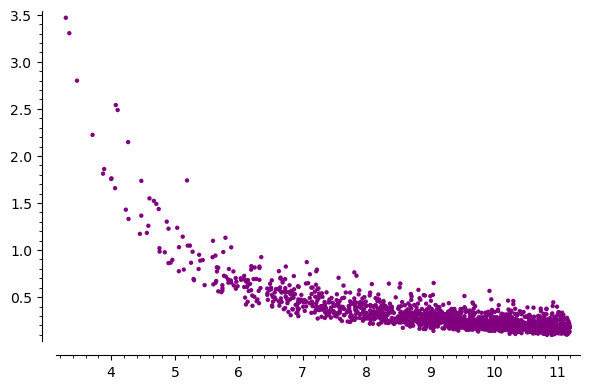

In [9]:
list_plot(Liste4_discri_bounds, color='purple')
# x : the root discriminant
# y : the bound

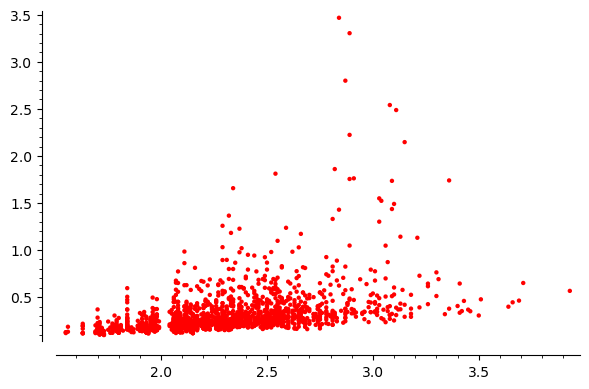

In [10]:
list_plot(Liste4_lambda_bounds, color='red')
# x : lambda
# y : the bound

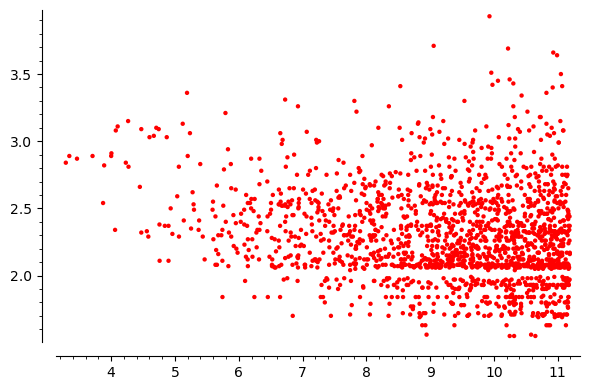

In [11]:
list_plot(Liste4_lambda_discri, color='red')
# x : root discriminant
# y : the optimal lambda for "the" field associated to this root discriminant

In [12]:
Liste4_discri_bounds

[(3.288868167986058, 3.46755262345163),
 (3.34370152488211, 3.30387231882854),
 (3.4641016151377544, 2.79948893185683),
 (3.7077927510673407, 2.22358309181960),
 (3.872983346207417, 1.81152295056784),
 (3.8900830261604384, 1.86040572271741),
 (4.0, 1.75505118687058),
 (4.003900540957704, 1.76179603951759),
 (4.061086369737861, 1.65739492466130),
 (4.072238199292497, 2.54071079785632),
 (4.10153676580629, 2.48741031117361),
 (4.229485053762256, 1.42887211544824),
 (4.265372832316098, 2.14673331806738),
 (4.271801445630948, 1.33045412525956),
 (4.4496055862540596, 1.17206501557201),
 (4.47213595499958, 1.73512129401383),
 (4.47213595499958, 1.36553300099199),
 (4.559014113909555, 1.18231037183149),
 (4.58257569495584, 1.25796295605454),
 (4.600653267582412, 1.54925722727412),
 (4.66845742378608, 1.52316334943345),
 (4.707283697225008, 1.49007816629714),
 (4.7451723360058695, 1.43601588088307),
 (4.756828460010884, 1.01976312727330),
 (4.759149430918539, 0.984133985612753),
 (4.8405318951

In [13]:
Liste4_lambda_bounds 

[(2.84000000000000, 3.46755262345163),
 (2.89000000000000, 3.30387231882854),
 (2.87000000000000, 2.79948893185683),
 (2.89000000000000, 2.22358309181960),
 (2.54000000000000, 1.81152295056784),
 (2.82000000000000, 1.86040572271741),
 (2.89000000000000, 1.75505118687058),
 (2.91000000000000, 1.76179603951759),
 (2.34000000000000, 1.65739492466130),
 (3.08000000000000, 2.54071079785632),
 (3.11000000000000, 2.48741031117361),
 (2.84000000000000, 1.42887211544824),
 (3.15000000000000, 2.14673331806738),
 (2.81000000000000, 1.33045412525956),
 (2.66000000000000, 1.17206501557201),
 (3.09000000000000, 1.73512129401383),
 (2.32000000000000, 1.36553300099199),
 (2.33000000000000, 1.18231037183149),
 (2.29000000000000, 1.25796295605454),
 (3.03000000000000, 1.54925722727412),
 (3.04000000000000, 1.52316334943345),
 (3.10000000000000, 1.49007816629714),
 (3.09000000000000, 1.43601588088307),
 (2.38000000000000, 1.01976312727330),
 (2.11000000000000, 0.984133985612753),
 (2.37000000000000, 0.97

In [14]:
Liste4_lambda_discri

[(3.288868167986058, 2.84000000000000),
 (3.34370152488211, 2.89000000000000),
 (3.4641016151377544, 2.87000000000000),
 (3.7077927510673407, 2.89000000000000),
 (3.872983346207417, 2.54000000000000),
 (3.8900830261604384, 2.82000000000000),
 (4.0, 2.89000000000000),
 (4.003900540957704, 2.91000000000000),
 (4.061086369737861, 2.34000000000000),
 (4.072238199292497, 3.08000000000000),
 (4.10153676580629, 3.11000000000000),
 (4.229485053762256, 2.84000000000000),
 (4.265372832316098, 3.15000000000000),
 (4.271801445630948, 2.81000000000000),
 (4.4496055862540596, 2.66000000000000),
 (4.47213595499958, 3.09000000000000),
 (4.47213595499958, 2.32000000000000),
 (4.559014113909555, 2.33000000000000),
 (4.58257569495584, 2.29000000000000),
 (4.600653267582412, 3.03000000000000),
 (4.66845742378608, 3.04000000000000),
 (4.707283697225008, 3.10000000000000),
 (4.7451723360058695, 3.09000000000000),
 (4.756828460010884, 2.38000000000000),
 (4.759149430918539, 2.11000000000000),
 (4.84053189512

In [15]:
Liste4_field_bounds

[(Number Field in a with defining polynomial x^4 - x^3 - x^2 + x + 1,
  3.46755262345163),
 (Number Field in a with defining polynomial x^4 - x^3 + x^2 - x + 1,
  3.30387231882854),
 (Number Field in a with defining polynomial x^4 - x^2 + 1, 2.79948893185683),
 (Number Field in a with defining polynomial x^4 - x^3 + 2*x + 1,
  2.22358309181960),
 (Number Field in a with defining polynomial x^4 - x^3 + 2*x^2 + x + 1,
  1.81152295056784),
 (Number Field in a with defining polynomial x^4 - x + 1, 1.86040572271741),
 (Number Field in a with defining polynomial x^4 + 1, 1.75505118687058),
 (Number Field in a with defining polynomial x^4 + x^2 - x + 1,
  1.76179603951759),
 (Number Field in a with defining polynomial x^4 + x^2 - 2*x + 1,
  1.65739492466130),
 (Number Field in a with defining polynomial x^4 - x^3 + 2*x - 1,
  2.54071079785632),
 (Number Field in a with defining polynomial x^4 - x - 1, 2.48741031117361),
 (Number Field in a with defining polynomial x^4 - 2*x^3 + 2,
  1.4288721

In [19]:
a = nb_fields_without_EGE
b = len(fields4)
print(a,b,float(a/b))

35 1771 0.019762845849802372


In [22]:
for k in Liste4_field_bounds:
    if k[1] > 1: 
        print(k)

(Number Field in a with defining polynomial x^4 - x^3 - x^2 + x + 1, 3.46755262345163)
(Number Field in a with defining polynomial x^4 - x^3 + x^2 - x + 1, 3.30387231882854)
(Number Field in a with defining polynomial x^4 - x^2 + 1, 2.79948893185683)
(Number Field in a with defining polynomial x^4 - x^3 + 2*x + 1, 2.22358309181960)
(Number Field in a with defining polynomial x^4 - x^3 + 2*x^2 + x + 1, 1.81152295056784)
(Number Field in a with defining polynomial x^4 - x + 1, 1.86040572271741)
(Number Field in a with defining polynomial x^4 + 1, 1.75505118687058)
(Number Field in a with defining polynomial x^4 + x^2 - x + 1, 1.76179603951759)
(Number Field in a with defining polynomial x^4 + x^2 - 2*x + 1, 1.65739492466130)
(Number Field in a with defining polynomial x^4 - x^3 + 2*x - 1, 2.54071079785632)
(Number Field in a with defining polynomial x^4 - x - 1, 2.48741031117361)
(Number Field in a with defining polynomial x^4 - 2*x^3 + 2, 1.42887211544824)
(Number Field in a with defini

In [38]:
K.<a> = NumberField(x^4 - x^3 - 4*x^2 + 4*x + 1)
K.optimized_subfields(0)

[
(Number Field in a0 with defining polynomial x, Ring morphism:
  From: Number Field in a0 with defining polynomial x
  To:   Number Field in a with defining polynomial x^4 - x^3 - 4*x^2 + 4*x + 1
  Defn: 0 |--> 0, None),
(Number Field in a1 with defining polynomial x^2 - 3*x + 1, Ring morphism:
  From: Number Field in a1 with defining polynomial x^2 - 3*x + 1
  To:   Number Field in a with defining polynomial x^4 - x^3 - 4*x^2 + 4*x + 1
  Defn: a1 |--> -a^3 + 3*a + 1, None),
(Number Field in a2 with defining polynomial x^2 - x - 1, Ring morphism:
  From: Number Field in a2 with defining polynomial x^2 - x - 1
  To:   Number Field in a with defining polynomial x^4 - x^3 - 4*x^2 + 4*x + 1
  Defn: a2 |--> -a^3 + 3*a, None),
(Number Field in a3 with defining polynomial x^2 - x - 1, Ring morphism:
  From: Number Field in a3 with defining polynomial x^2 - x - 1
  To:   Number Field in a with defining polynomial x^4 - x^3 - 4*x^2 + 4*x + 1
  Defn: a3 |--> a^3 - 3*a + 1, None),
(Number Field